#***PRECONFIGURATION***

In [1]:
#unzip the file if needed
!unzip  csv_files_definitivo.zip

Archive:  csv_files_definitivo.zip
   creating: csv_files/
  inflating: csv_files/www.foxnews.com_visit_7.csv  
  inflating: csv_files/www.foxnews.com_visit_1.csv  
  inflating: csv_files/www.dailymail.co.uk_visit_2.csv  
  inflating: csv_files/www.nytimes.com_visit_4.csv  
  inflating: csv_files/www.theguardian.com_visit_1.csv  
  inflating: csv_files/www.nytimes.com_visit_3.csv  
  inflating: csv_files/www.cnn.com_visit_2.csv  
  inflating: csv_files/www.msn.com_visit_8.csv  
  inflating: csv_files/www.cnn.com_visit_7.csv  
  inflating: csv_files/www.theguardian.com_visit_2.csv  
  inflating: csv_files/www.theguardian.com_visit_8.csv  
  inflating: csv_files/www.foxnews.com_visit_3.csv  
  inflating: csv_files/www.finance.yahoo.com_visit_5.csv  
  inflating: csv_files/www.news.google.com_visit_3.csv  
  inflating: csv_files/www.news.google.com_visit_9.csv  
  inflating: csv_files/www.finance.yahoo.com_visit_8.csv  
  inflating: csv_files/www.foxnews.com_visit_5.csv  
  inflating: csv

In [2]:
!apt-get install tcpdump
!apt-get install curl
!apt-get install tshark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpcap0.8
Suggested packages:
  apparmor
The following NEW packages will be installed:
  libpcap0.8 tcpdump
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 647 kB of archives.
After this operation, 1,773 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcap0.8 amd64 1.10.1-4build1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 tcpdump amd64 4.99.1-3ubuntu0.2 [501 kB]
Fetched 647 kB in 1s (1,038 kB/s)
Selecting previously unselected package libpcap0.8:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../libpcap0.8_1.10.1-4build1_amd64.deb ...
Unpacking libpcap0.8:amd64 (1.10.1-4build1) ...
Selecting previously unselected package tcpdump.
Preparing to unpack .../tcpdump_4.99.1-3ubunt

In [3]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import colormaps
from sklearn.preprocessing import MinMaxScaler

In [4]:
!ip a #check the interface

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
7: eth0@if8: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc noqueue state UP group default 
    link/ether 02:42:ac:1c:00:0c brd ff:ff:ff:ff:ff:ff link-netnsid 0
    inet 172.28.0.12/16 brd 172.28.255.255 scope global eth0
       valid_lft forever preferred_lft forever


#***READING SITES AND CAPTURING PACKETS***

First of all it has been created a text file containing all the websites. Consequently in this section has been read this file and has been created a bash script for capturing HTTPS packets by using the tcpdump command and filtering on port 443 (the one used by the protocol that we are interested in)

In [5]:
# Open the file in reading mode
with open('sites.txt', 'r') as file:

    # Read all the raws of the file and save them into a list
    sites = [line.strip() for line in file.readlines()]

print(sites)


['https://www.indiatimes.com', 'https://www.washingtonpost.com', 'https://www.ndtv.com', 'https://www.cnbc.com', 'https://www.timesofindia.com', 'https://www.express.co.uk', 'https://www.rt.com', 'https://www.news18.com', 'https://www.nypost.com', 'https://www.abc.net.au', 'https://www.bbc.co.uk', 'https://www.msn.com', 'https://www.cnn.com', 'https://www.news.google.com', 'https://www.dailymail.co.uk', 'https://www.nytimes.com', 'https://www.theguardian.com', 'https://www.foxnews.com', 'https://www.finance.yahoo.com', 'https://www.news.yahoo.com']


In [6]:
sites=sites[10:]
print(sites)
print(len(sites))

['https://www.bbc.co.uk', 'https://www.msn.com', 'https://www.cnn.com', 'https://www.news.google.com', 'https://www.dailymail.co.uk', 'https://www.nytimes.com', 'https://www.theguardian.com', 'https://www.foxnews.com', 'https://www.finance.yahoo.com', 'https://www.news.yahoo.com']
10


In [ ]:
%%shell
# List of websites to visit
websites=("https://www.bbc.co.uk" "https://www.msn.com" "https://www.cnn.com" 'https://www.news.google.com'
"https://www.dailymail.co.uk" "https://www.nytimes.com" "https://www.theguardian.com" "https://www.foxnews.com"
"https://www.finance.yahoo.com" "https://www.news.yahoo.com")

# Number of visits
visits=10

# Directory to save .pcap files
pcap_dir="./pcap_files"
# Directory to save .csv files
csv_dir="./csv_files"

# Create directory if it doesn't exist
mkdir -p "$pcap_dir"
mkdir -p "$csv_dir"

# Loop through each website
for website in "${websites[@]}"; do
    # Extract the domain name for the filename
    domain=$(echo "$website" | awk -F[/:] '{print $4}') #This line extracts the domain name from the URL and stores it in the variable domain.
    #It uses 'awk' to split the URL using the delimiters [/:] and prints the fourth field, which corresponds to the domain.
    # "|" is used to concatenate an output of a command with an input of another command, "awk -F[/:]" is used to manipulate a text file, in particular,
    # is used to divide each row into fields using the character : or \ as a delimiter

    # Loop through the visits
    for (( i=1; i<=$visits; i++ )); do
        echo "Visiting $website, visit $i..."

        # Set the filename for each visit
        filename="${pcap_dir}/${domain}_visit_${i}.pcap" #This line sets the filename for the .pcap file to be saved. It combines the pcap_dir with
        #the domain name and appends _all_visits.pcap. {pcap_dir}/${domain} describes the path for saving the pcap file

        tcpdump -i eth0 -nn -X -w "$filename" " port 443" &
        # This command is used to capture packets on the interface 'eth0, referred to a specific port, the 443, that is used by HTTPS protocol,
        # the '-nn' option is used to tell tcpdump to display numerical values for addresses and ports instead of attempting to resolve
        # them to hostnames or service names and the '-X' option  instructs tcpdump to print each packet in both hex and ASCII format.

        #wait for the activation of tcpdump
        sleep 1

        # Visit the website using curl
        curl -s "$website" > /dev/null #-s means silent, so is used for not showing the output,

        # wait for the capture to be completed
        sleep 2

        pkill -2 tcpdump

        # Wait for a brief moment before the next visit
        sleep 2
    done

    # Wait for all visits to complete
    sleep 1

    echo "All visits to $website captured in $filename"

    for (( i=1; i<=$visits; i++ )); do
        pcap_filename="${pcap_dir}/${domain}_visit_${i}.pcap"

        #tshark is used to covert the pcap file into a CSV file
        tshark -r "$pcap_filename" -T fields -E header=y -E quote=d -E separator=, -e frame.number -e frame.time -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e frame.len -e tcp.len -e tcp.flags > "${csv_dir}/${domain}_visit_${i}.csv"
    done
done

echo "Packet capturing complete."

#***PACKETS ANALYSIS***

In [7]:
!zip -r csv_files_definitivo.zip csv_files
# This line of code has been used to zip the csv file in order to save it

updating: csv_files/ (stored 0%)
updating: csv_files/www.foxnews.com_visit_7.csv (deflated 90%)
updating: csv_files/www.foxnews.com_visit_1.csv (deflated 90%)
updating: csv_files/www.dailymail.co.uk_visit_2.csv (deflated 85%)
updating: csv_files/www.nytimes.com_visit_4.csv (deflated 91%)
updating: csv_files/www.theguardian.com_visit_1.csv (deflated 87%)
updating: csv_files/www.nytimes.com_visit_3.csv (deflated 90%)
updating: csv_files/www.cnn.com_visit_2.csv (deflated 91%)
updating: csv_files/www.msn.com_visit_8.csv (deflated 87%)
updating: csv_files/www.cnn.com_visit_7.csv (deflated 91%)
updating: csv_files/www.theguardian.com_visit_2.csv (deflated 86%)
updating: csv_files/www.theguardian.com_visit_8.csv (deflated 86%)
updating: csv_files/www.foxnews.com_visit_3.csv (deflated 90%)
updating: csv_files/www.finance.yahoo.com_visit_5.csv (deflated 86%)
updating: csv_files/www.news.google.com_visit_3.csv (deflated 84%)
updating: csv_files/www.news.google.com_visit_9.csv (deflated 85%)
upda

Grouping tcp flows

In [8]:
k=0

# Function to extract features from flow data
def extract_features(flow,df_flow,filename):
  flow_features = {}

  # Checking if the flow is an uplink flow (source IP starts with '172')
  if (flow[0].split('.')[0]=='172'):

    # Setting direction as 'uplink'
    flow_features['direction']= 'uplink'

    # Extracting source and destination ports
    flow_features['srcport']=flow[2]
    flow_features['dport']=flow[3]

    # Calculating features related to uplink flow
    flow_features['num_packets_up'] = len(df_flow)
    pkt_size = df_flow['frame.len'].astype(float)
    flow_features['total_bytes_up'] = pkt_size.sum()
    flow_features['min_pkt_size_up'] = pkt_size.min()
    flow_features['max_pkt_size_up'] = pkt_size.max()
    flow_features['mean_pkt_size_up'] = pkt_size.mean()
    flow_features['std_pkt_size_up'] = pkt_size.std()

    # Converting frame time to datetime format
    df_flow['frame.time_up'] = pd.to_datetime(df_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
    iat = df_flow['frame.time_up'].diff(1).dt.total_seconds().iloc[1:]
    flow_features['min_iat_up'] = iat.min()
    flow_features['max_iat_up'] = iat.max()
    flow_features['mean_iat_up'] = iat.mean()
    flow_features['std_iat_up'] = iat.std()
    flow_features['duration_up'] = iat.sum()

    # Extracting site name from filename
    flow_features['site'] = filename.split('_')[0]

  # If flow is not an uplink flow
  else:

    flow_features['direction']= 'downlink'
    flow_features['srcport']=flow[2]
    flow_features['dport']=flow[3]

    # Calculating features related to downlink flow
    flow_features['num_packets_down'] = len(df_flow)
    pkt_size = df_flow['frame.len'].astype(float)
    flow_features['total_bytes_down'] = pkt_size.sum()
    flow_features['min_pkt_size_down'] = pkt_size.min()
    flow_features['max_pkt_size_down'] = pkt_size.max()
    flow_features['mean_pkt_size_down'] = pkt_size.mean()
    flow_features['std_pkt_size_down'] = pkt_size.std()

#29	Mar 15, 2024 09:52:42.145755000 UTC

    # Converting frame time to datetime format
    df_flow['frame.time_down'] = pd.to_datetime(df_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
    iat = df_flow['frame.time_down'].diff(1).dt.total_seconds().iloc[1:]
    flow_features['min_iat_down'] = iat.min()
    flow_features['max_iat_down'] = iat.max()
    flow_features['mean_iat_down'] = iat.mean()
    flow_features['std_iat_down'] = iat.std()
    flow_features['duration_down'] = iat.sum()

  return flow_features

In [9]:
# Defining the path to the folder containing CSV files
path = "/content/csv_files"

# Creating a list containing all the CSV files in the specified path
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path,f))]

# Extracting unique site names from the filenames
site = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(site ,len(site), len(tcpdumpfiles))

# Initializing empty lists to store dataset information for downlink and uplink flows
dataset_list = []
dataset_down = []
dataset_up = []

# Iterating through each file in the list of TCP dump files
for f in tcpdumpfiles:
  print("Processing file:  ",f)

  # Reading the CSV file into a DataFrame
  df = pd.read_csv(join(path,f),low_memory=False)
  # Grouping data by source IP, destination IP, source port, and destination port
  df_flow_tcp = df.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

  # Iterating through each flow in the grouped data
  for flow,df_flow in df_flow_tcp:
    flow_features = extract_features(flow,df_flow,f)

    if (flow_features['direction']=='downlink'):
      # Remove the 'direction' key
      flow_features.pop('direction')
      dataset_down.append(pd.DataFrame([flow_features]))
    else:
      flow_features.pop('direction')
      dataset_up.append(pd.DataFrame([flow_features]))

print(len(dataset_up))
print(len(dataset_down))

if len(dataset_down) == len(dataset_up):

    # Iterating through both datasets together using zip
    for down, up in zip(dataset_down, dataset_up):
        # Combining downlink and uplink information into a single row and appending to the list
        combined_row = pd.concat([down, up.reset_index(drop=True)], axis=1)
        dataset_list.append(combined_row)
else:
    print("Errore: le lunghezze di dataset_down e dataset_up non corrispondono.")

print(dataset_list)


['www.bbc.co.uk' 'www.cnn.com' 'www.dailymail.co.uk'
 'www.finance.yahoo.com' 'www.foxnews.com' 'www.msn.com'
 'www.news.google.com' 'www.news.yahoo.com' 'www.nytimes.com'
 'www.theguardian.com'] 10 100
Processing file:   www.nytimes.com_visit_8.csv
Processing file:   www.foxnews.com_visit_2.csv
Processing file:   www.theguardian.com_visit_10.csv
Processing file:   www.finance.yahoo.com_visit_1.csv
Processing file:   www.news.yahoo.com_visit_8.csv
Processing file:   www.msn.com_visit_2.csv
Processing file:   www.msn.com_visit_9.csv
Processing file:   www.msn.com_visit_10.csv
Processing file:   www.cnn.com_visit_2.csv
Processing file:   www.theguardian.com_visit_1.csv
Processing file:   www.theguardian.com_visit_3.csv
Processing file:   www.cnn.com_visit_4.csv
Processing file:   www.finance.yahoo.com_visit_4.csv
Processing file:   www.foxnews.com_visit_6.csv
Processing file:   www.news.yahoo.com_visit_9.csv
Processing file:   www.msn.com_visit_8.csv
Processing file:   www.nytimes.com_vi

In [10]:
# Create a dataframe
dataset = pd.DataFrame()
dataset = pd.concat(dataset_list,ignore_index=True)

display(dataset)
#len(dataset)

,srcport,dport,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,...,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,duration_up,site
0,443,39424,89,717529.0,66.0,20282.0,8062.123596,7241.564834,0.000000,0.034054,...,54.0,583.0,75.616279,57.142581,0.000004,0.027451,0.001473,0.003308,0.125204,www.nytimes.com
1,443,56198,69,636563.0,66.0,43506.0,9225.550725,10797.185982,0.000000,0.033297,...,54.0,583.0,77.676056,62.747743,0.000003,0.026427,0.002128,0.004588,0.148944,www.foxnews.com
2,443,44406,16,6381.0,66.0,2954.0,398.812500,794.211745,0.000000,0.055469,...,54.0,583.0,116.187500,127.301332,0.000003,0.049058,0.005269,0.012456,0.079040,www.theguardian.com
3,443,53008,14,11968.0,66.0,4162.0,854.857143,1207.001489,0.000043,0.056215,...,66.0,583.0,108.650000,114.013053,0.000014,0.047659,0.008361,0.016378,0.158856,www.finance.yahoo.com
4,443,41336,19,12300.0,66.0,2710.0,647.368421,748.645162,0.000000,0.041916,...,66.0,583.0,105.227273,108.975284,0.000003,0.050071,0.006670,0.014011,0.140076,www.news.yahoo.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,443,45856,13,11906.0,66.0,4162.0,915.846154,1398.546439,0.000001,0.033223,...,66.0,583.0,110.894737,116.682330,0.000004,0.031477,0.005859,0.010758,0.105465,www.finance.yahoo.com
96,443,38594,37,54035.0,54.0,4434.0,1460.405405,1665.861647,0.000000,0.033391,...,54.0,571.0,98.636364,111.999807,0.000009,0.032780,0.005022,0.008844,0.105472,www.msn.com
97,443,35456,17,11480.0,66.0,4162.0,675.294118,1139.721828,0.000001,0.038607,...,66.0,583.0,118.562500,126.230461,0.000005,0.047099,0.009384,0.016657,0.140758,www.finance.yahoo.com
98,443,51790,13,11760.0,54.0,4150.0,904.615385,1450.259261,0.000001,0.034504,...,66.0,583.0,110.789474,116.662180,0.000003,0.032113,0.006076,0.010957,0.109372,www.news.yahoo.com


In [11]:
dataset.columns # Show all the packets' features

Index(['srcport', 'dport', 'num_packets_down', 'total_bytes_down',
       'min_pkt_size_down', 'max_pkt_size_down', 'mean_pkt_size_down',
       'std_pkt_size_down', 'min_iat_down', 'max_iat_down', 'mean_iat_down',
       'std_iat_down', 'duration_down', 'srcport', 'dport', 'num_packets_up',
       'total_bytes_up', 'min_pkt_size_up', 'max_pkt_size_up',
       'mean_pkt_size_up', 'std_pkt_size_up', 'min_iat_up', 'max_iat_up',
       'mean_iat_up', 'std_iat_up', 'duration_up', 'site'],
      dtype='object')

#***KNN AND ACCURACY ANALYSIS***

In this piece of code have been tried two kinds of scaler (the StandardScaler and the MinMaxScaler) for scaling datas, but in both cases has been detected a relevant decrease in the performances (approximately 10-20%), this could be due to the fact that there are some features that are more important than others and when we scale datas, the fact that we are given the same importance to all the features causes a downgrade in accuracy

Accuracy: [0.8666666666666667, 0.9333333333333333, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7666666666666667]
[0.92 0.92 0.88 0.92]


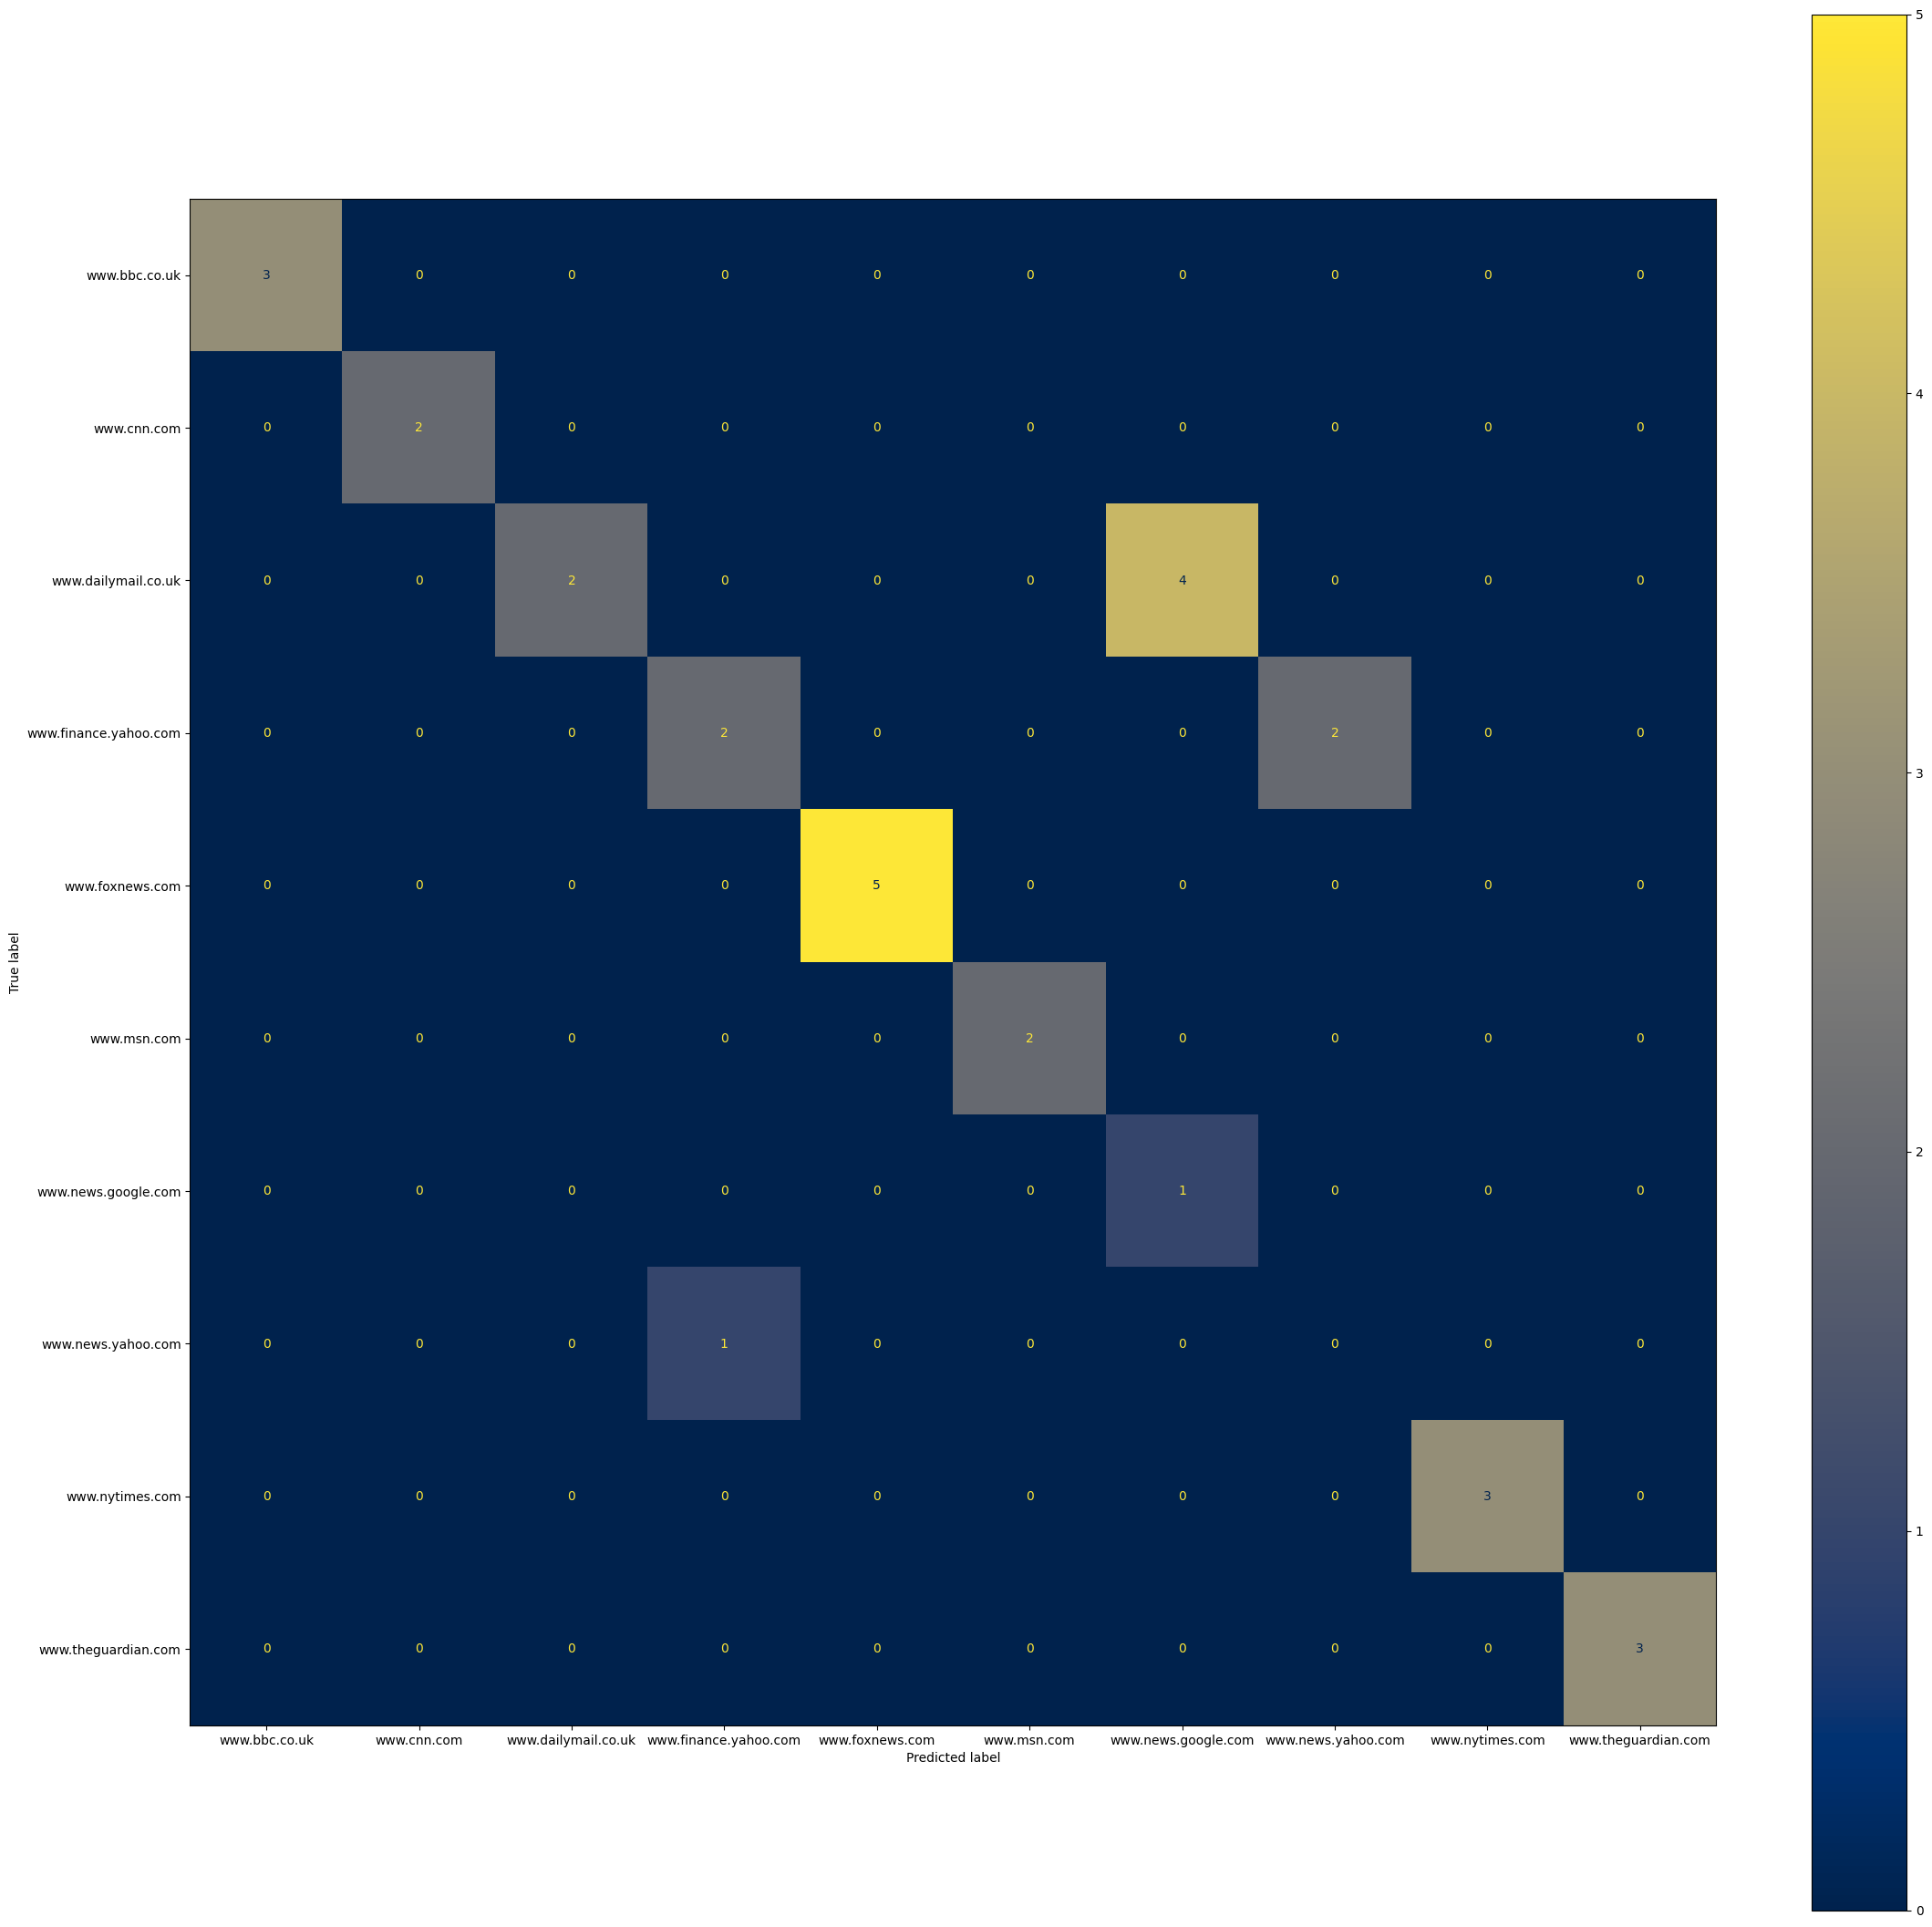

[0.96 0.88 0.92 0.92]


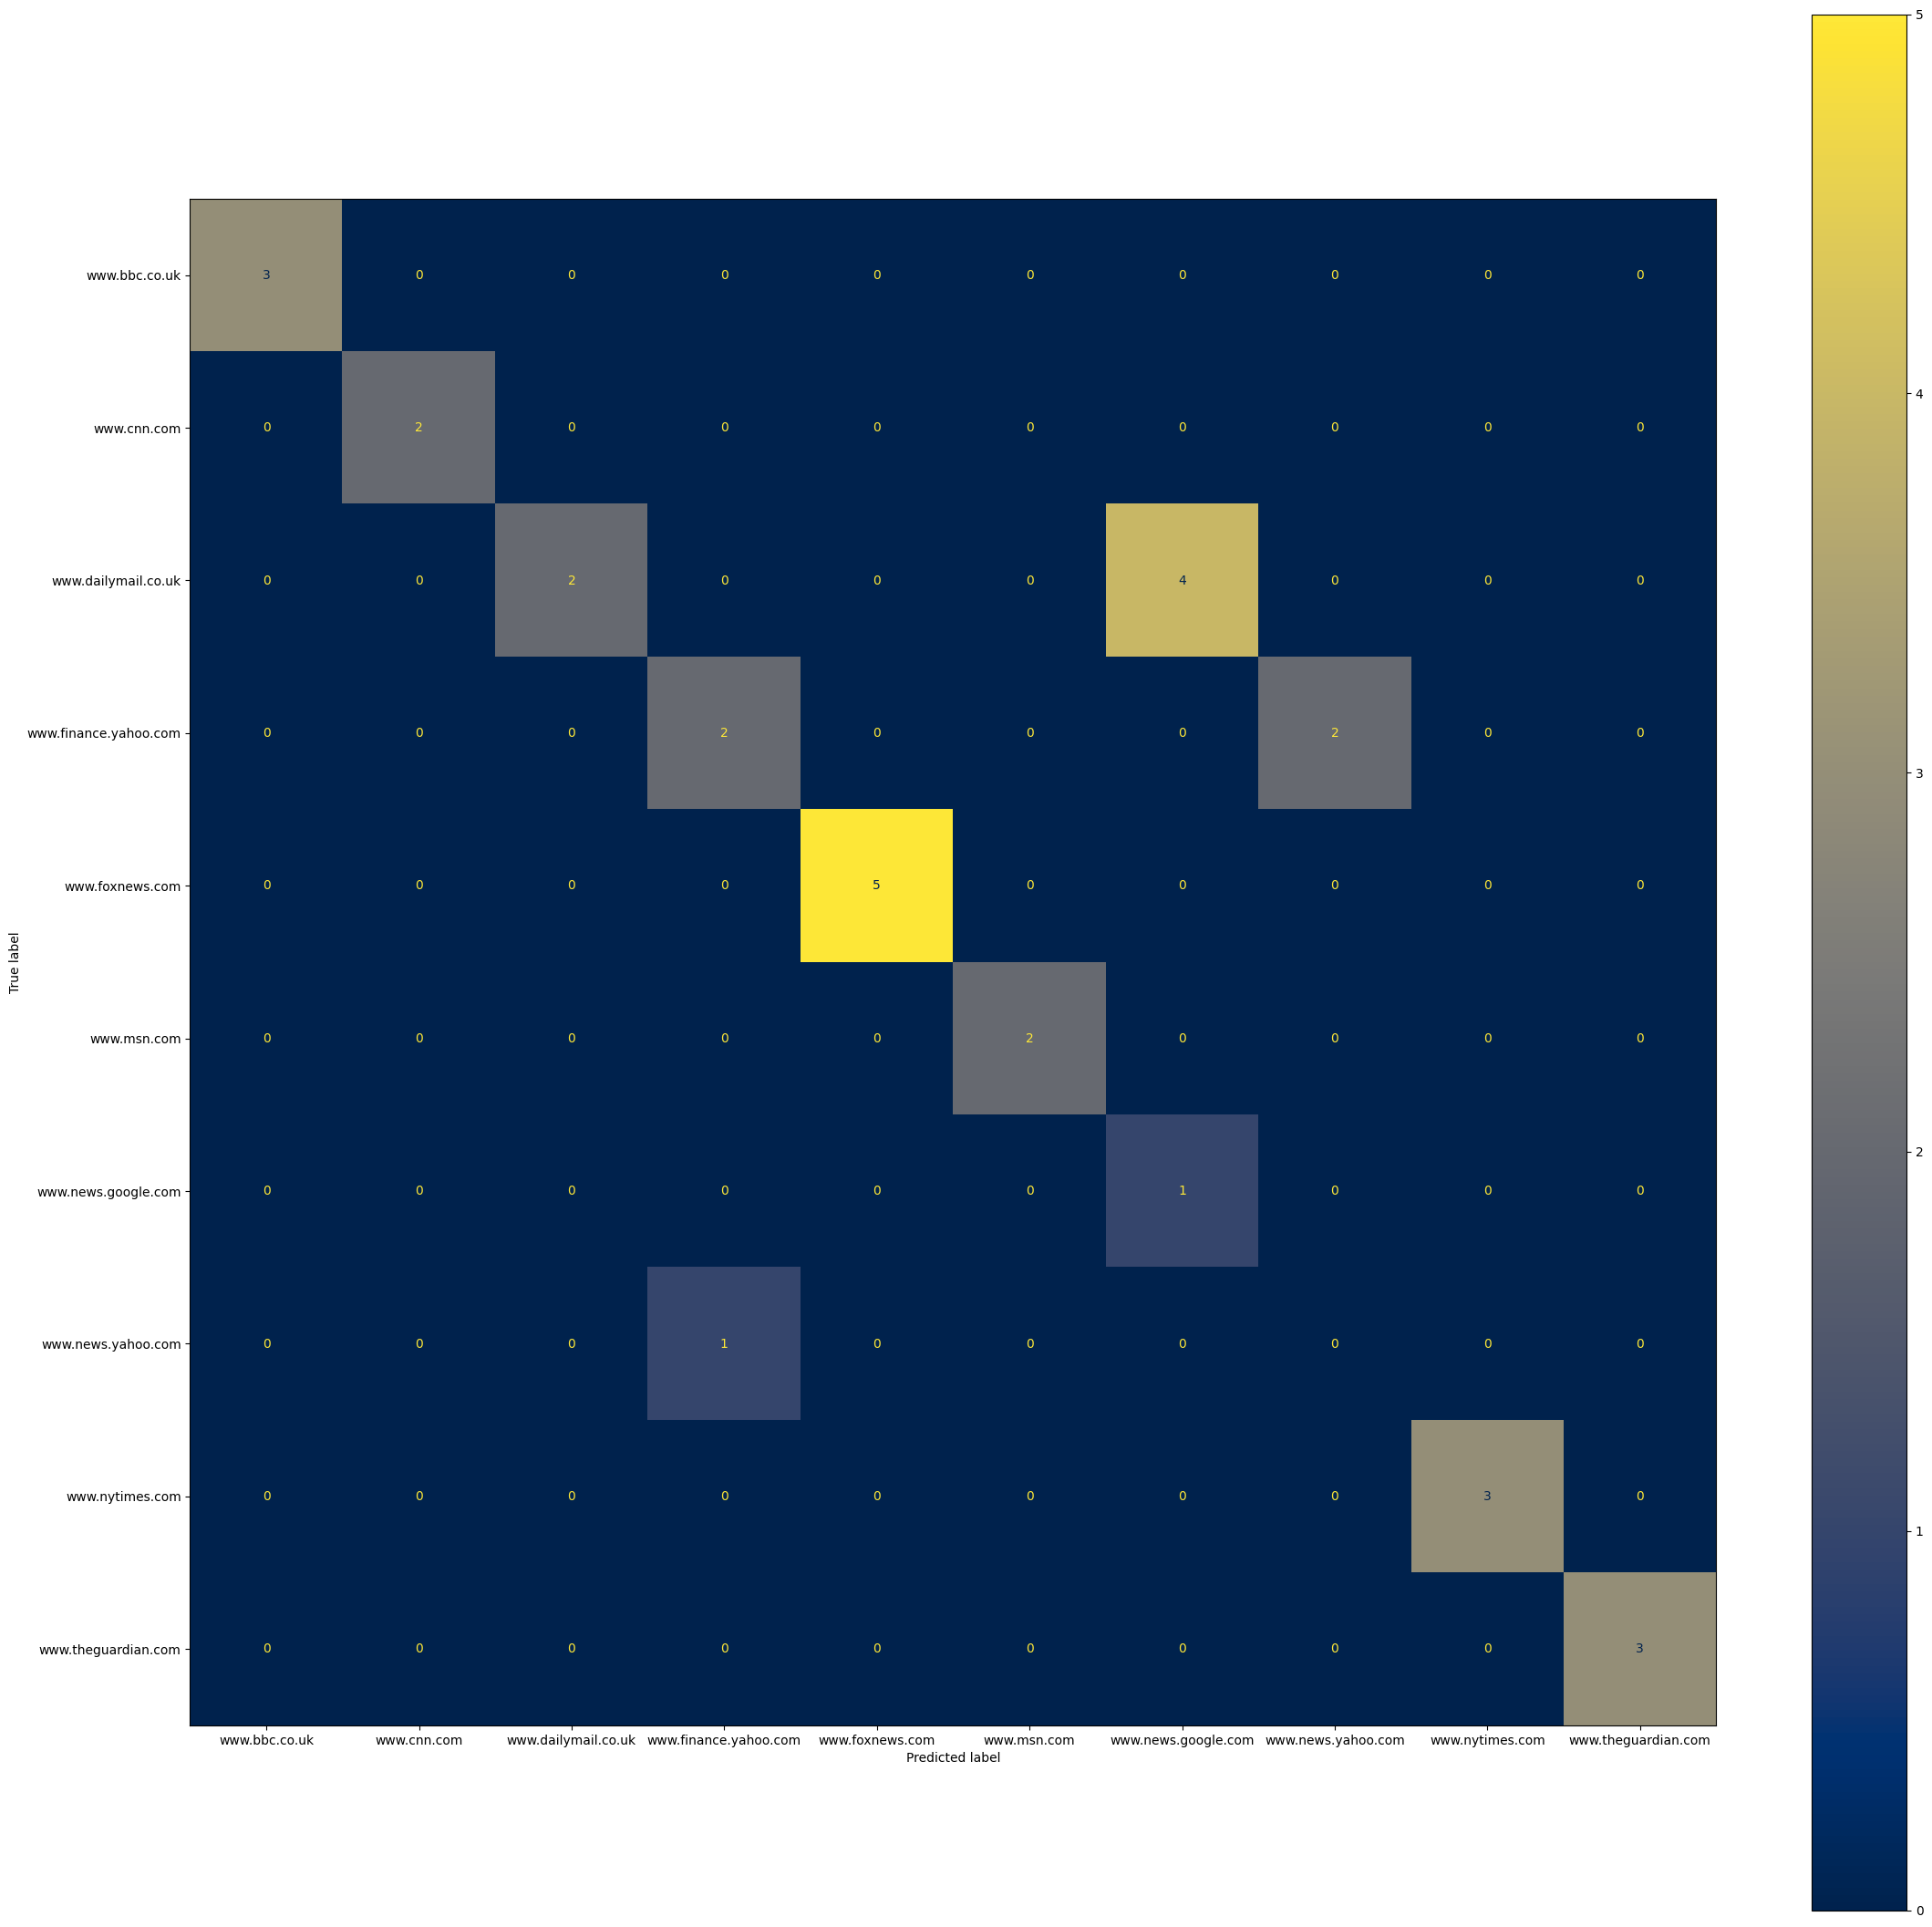

[0.92 1.   0.88 0.92]


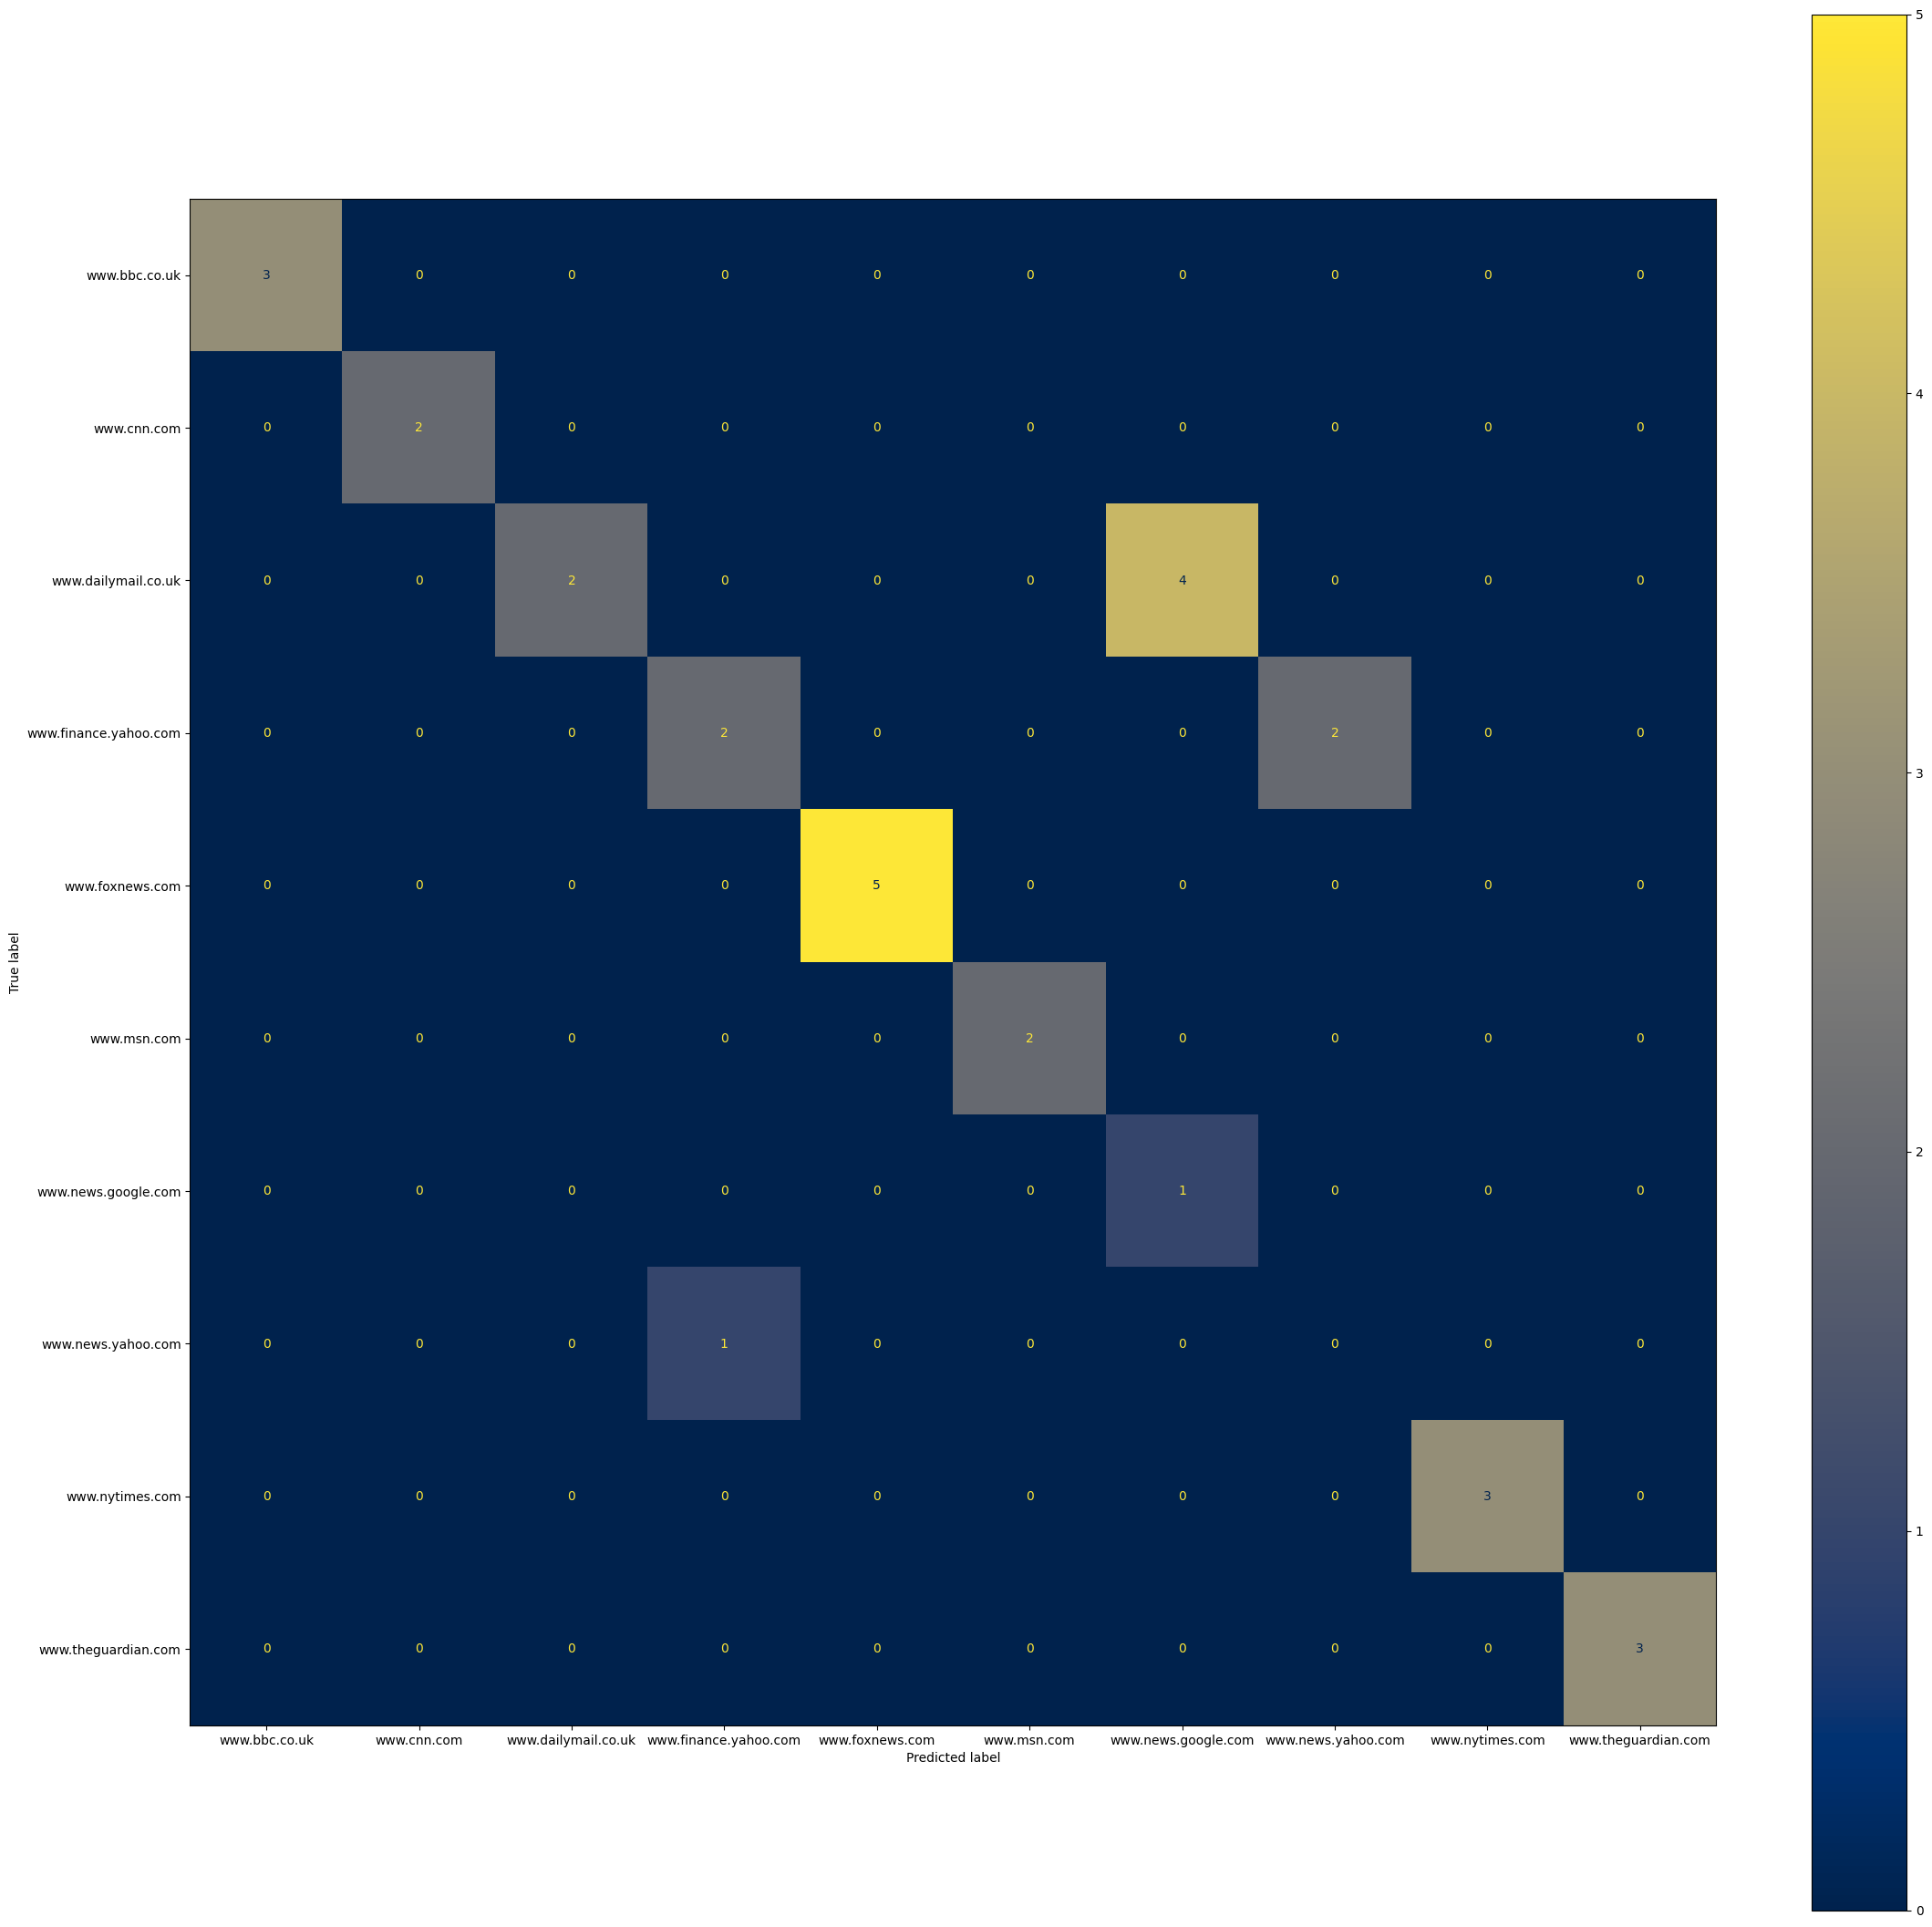

[0.92 0.88 0.88 0.92]


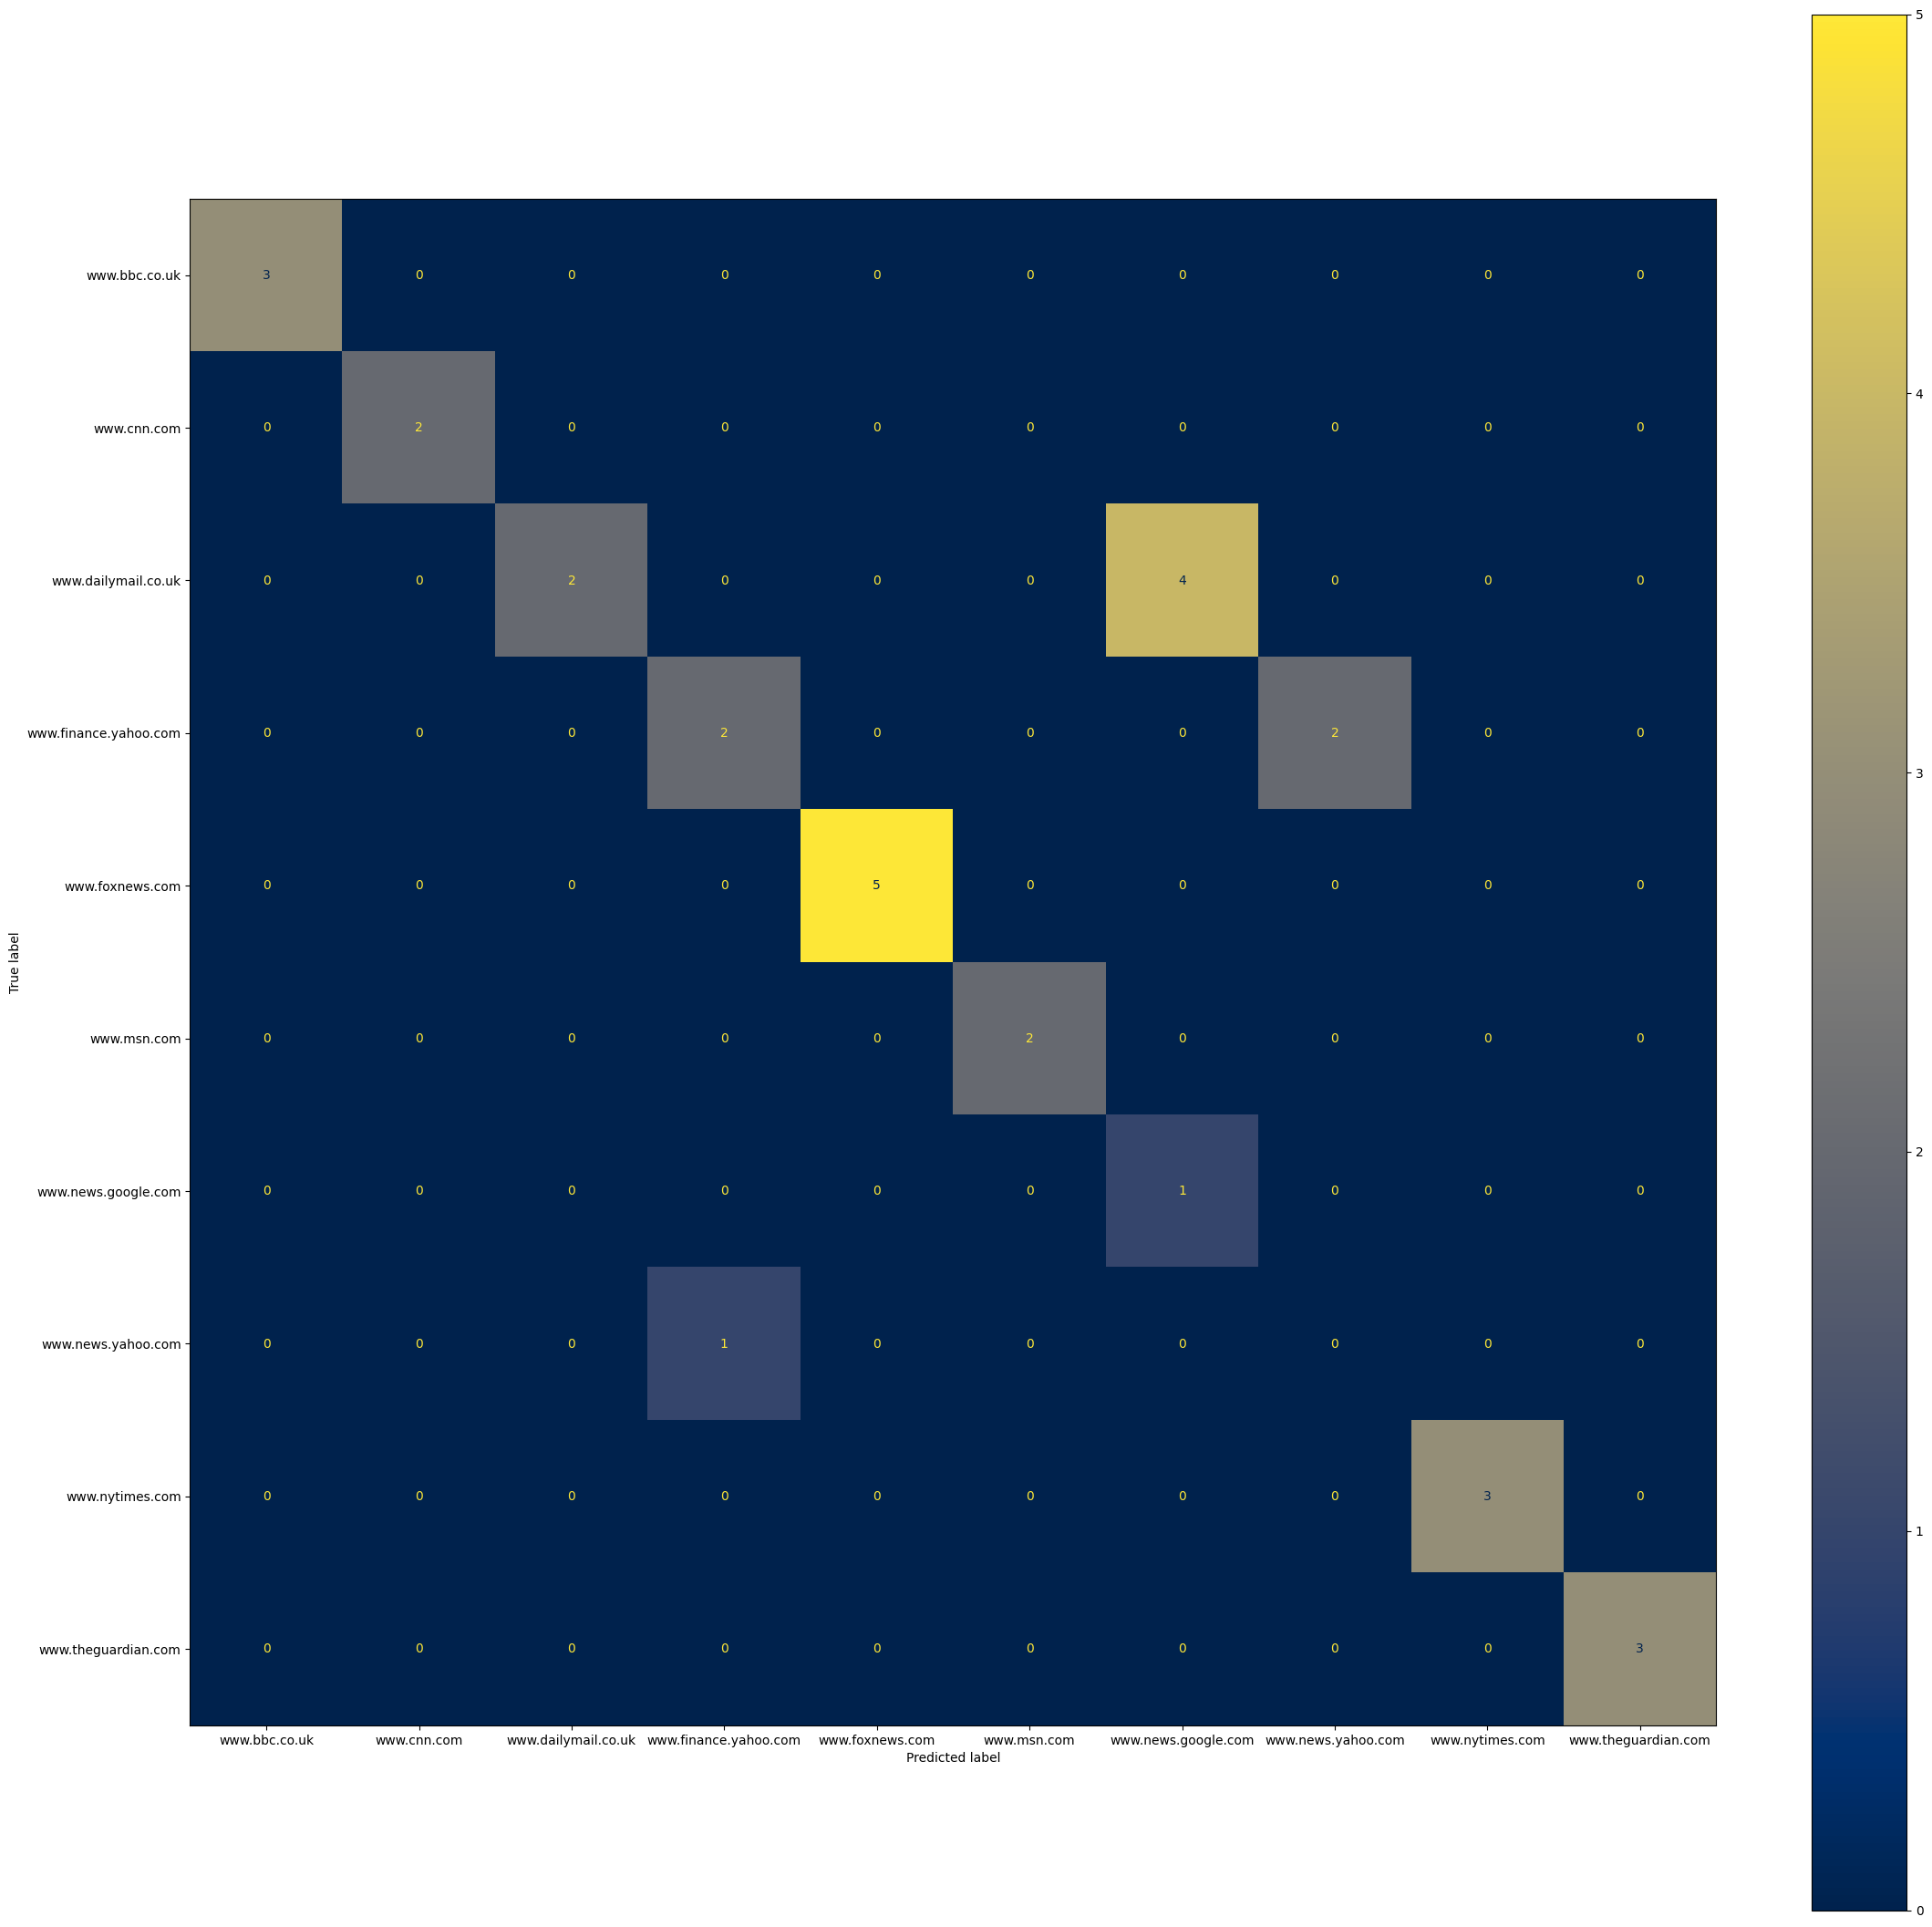

[0.92 0.96 0.88 0.88]


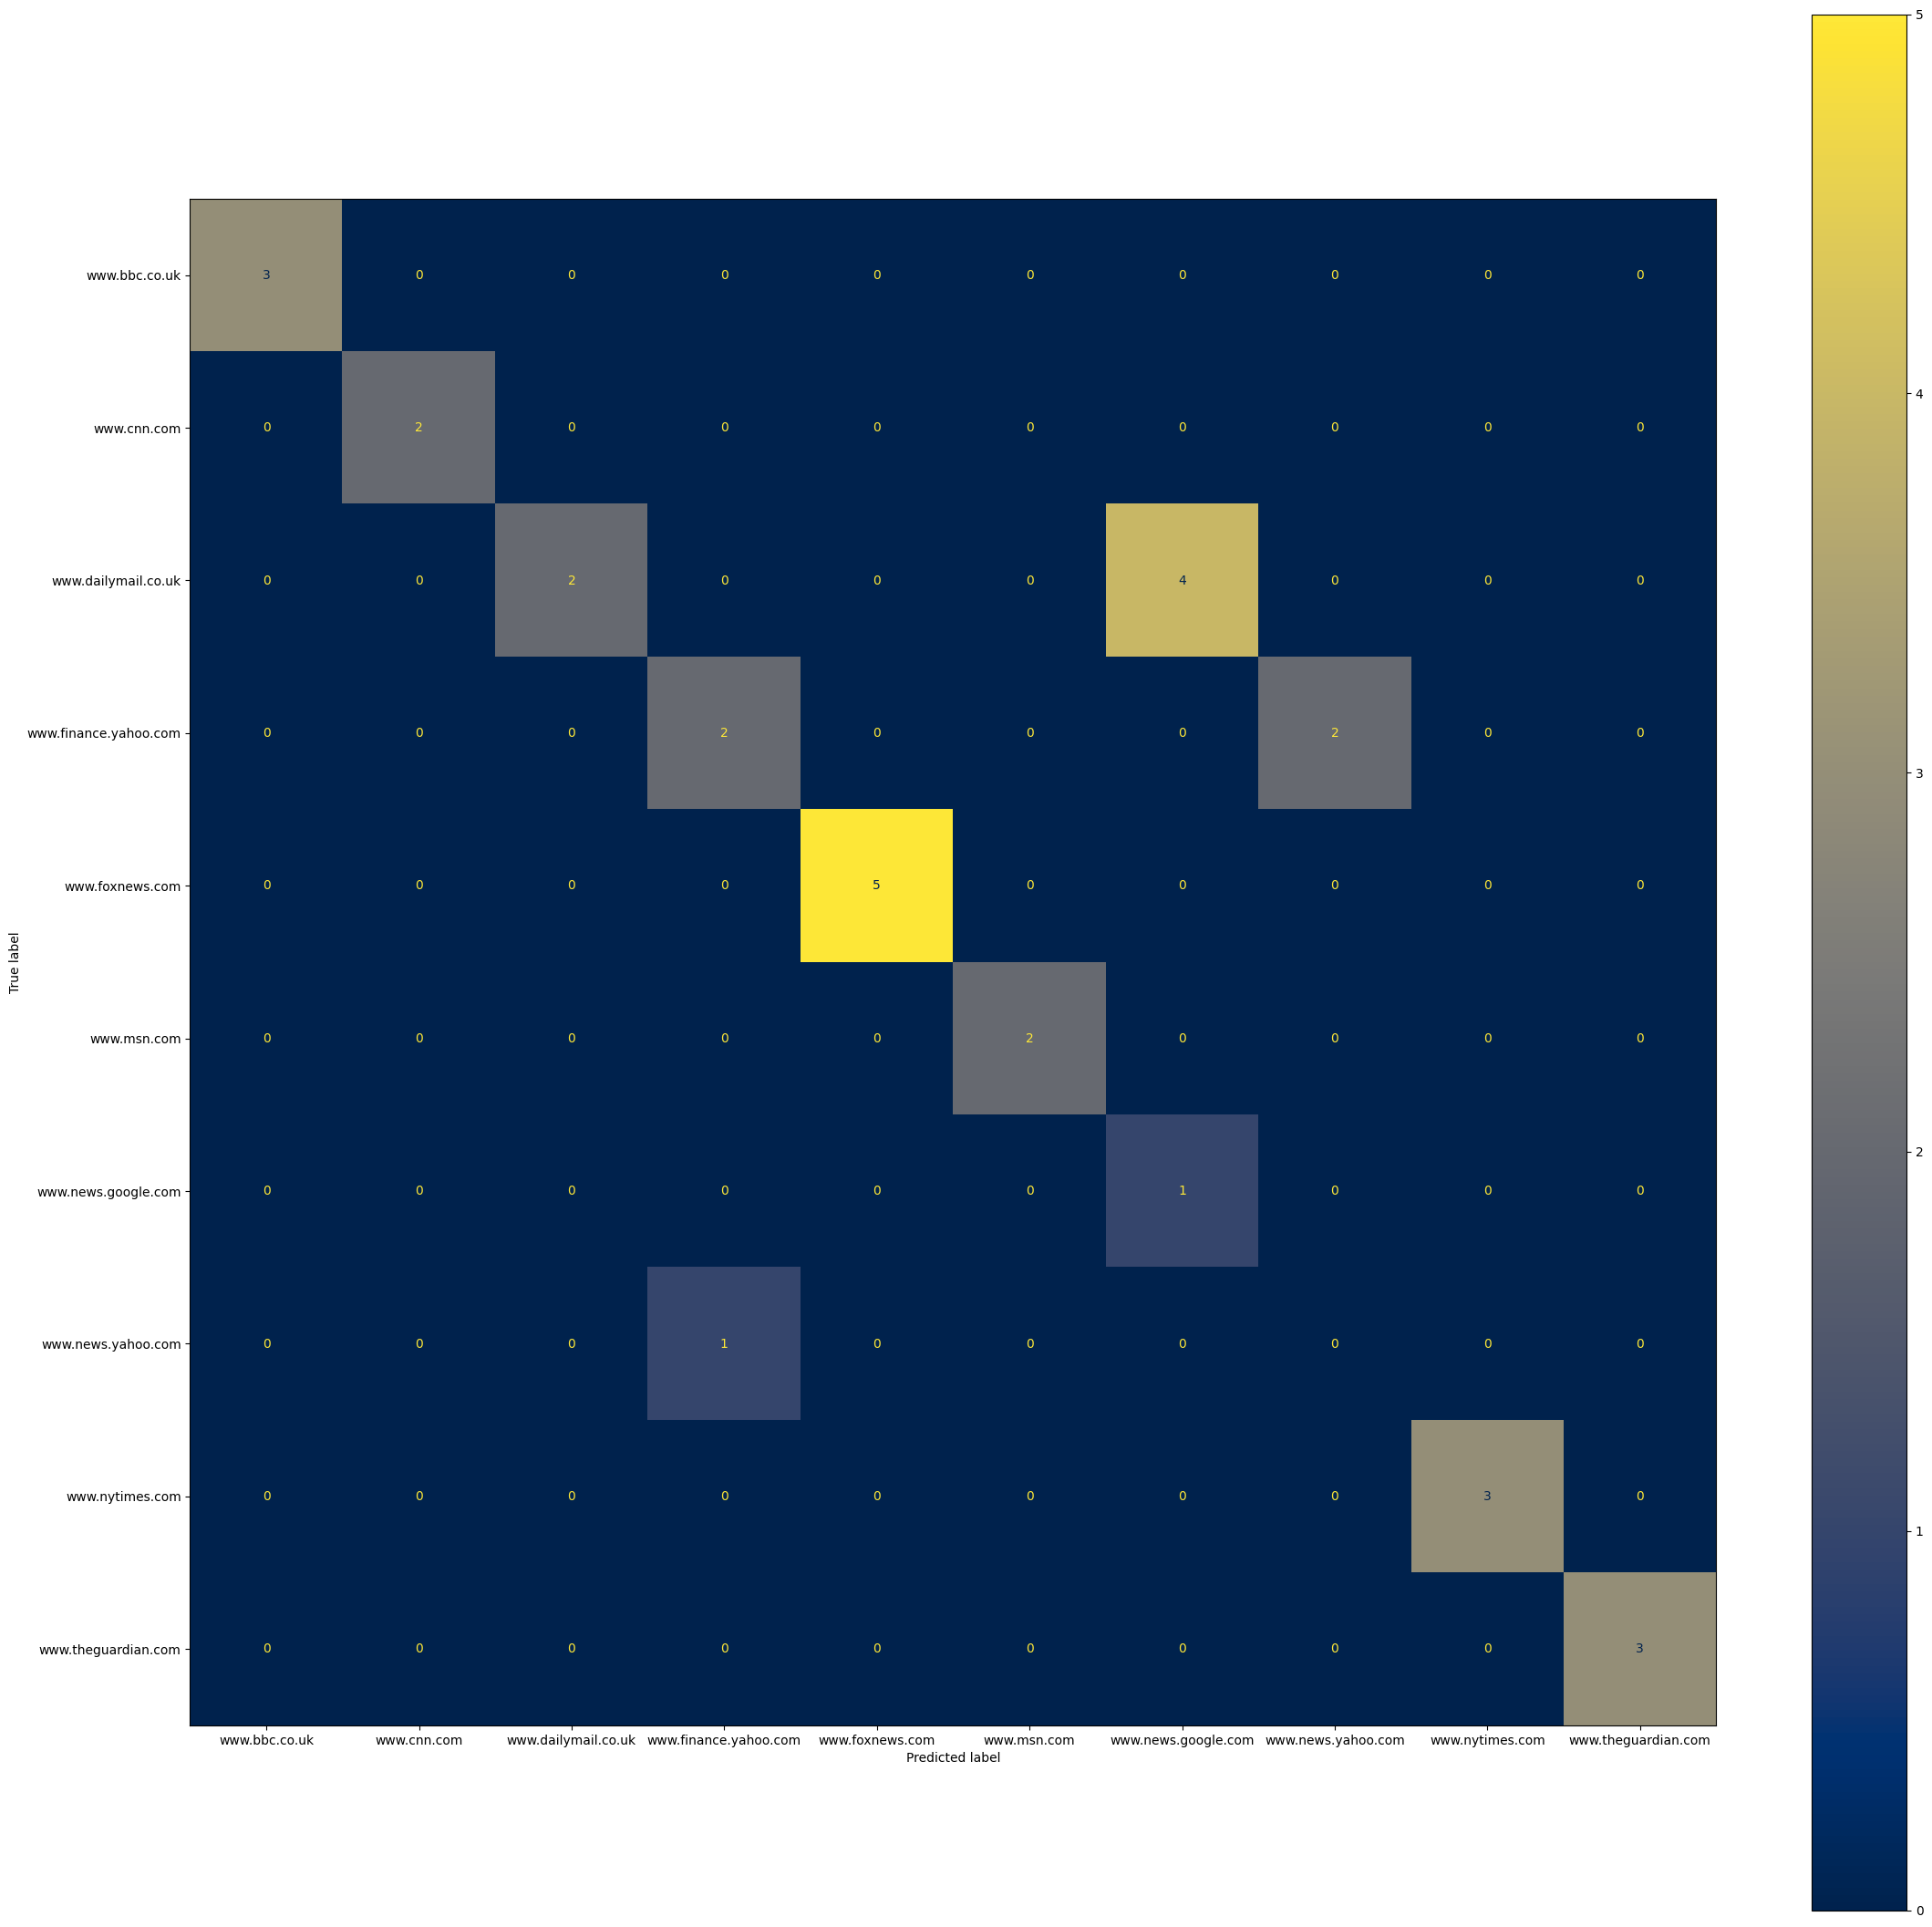

[0.92 0.96 0.88 0.92]


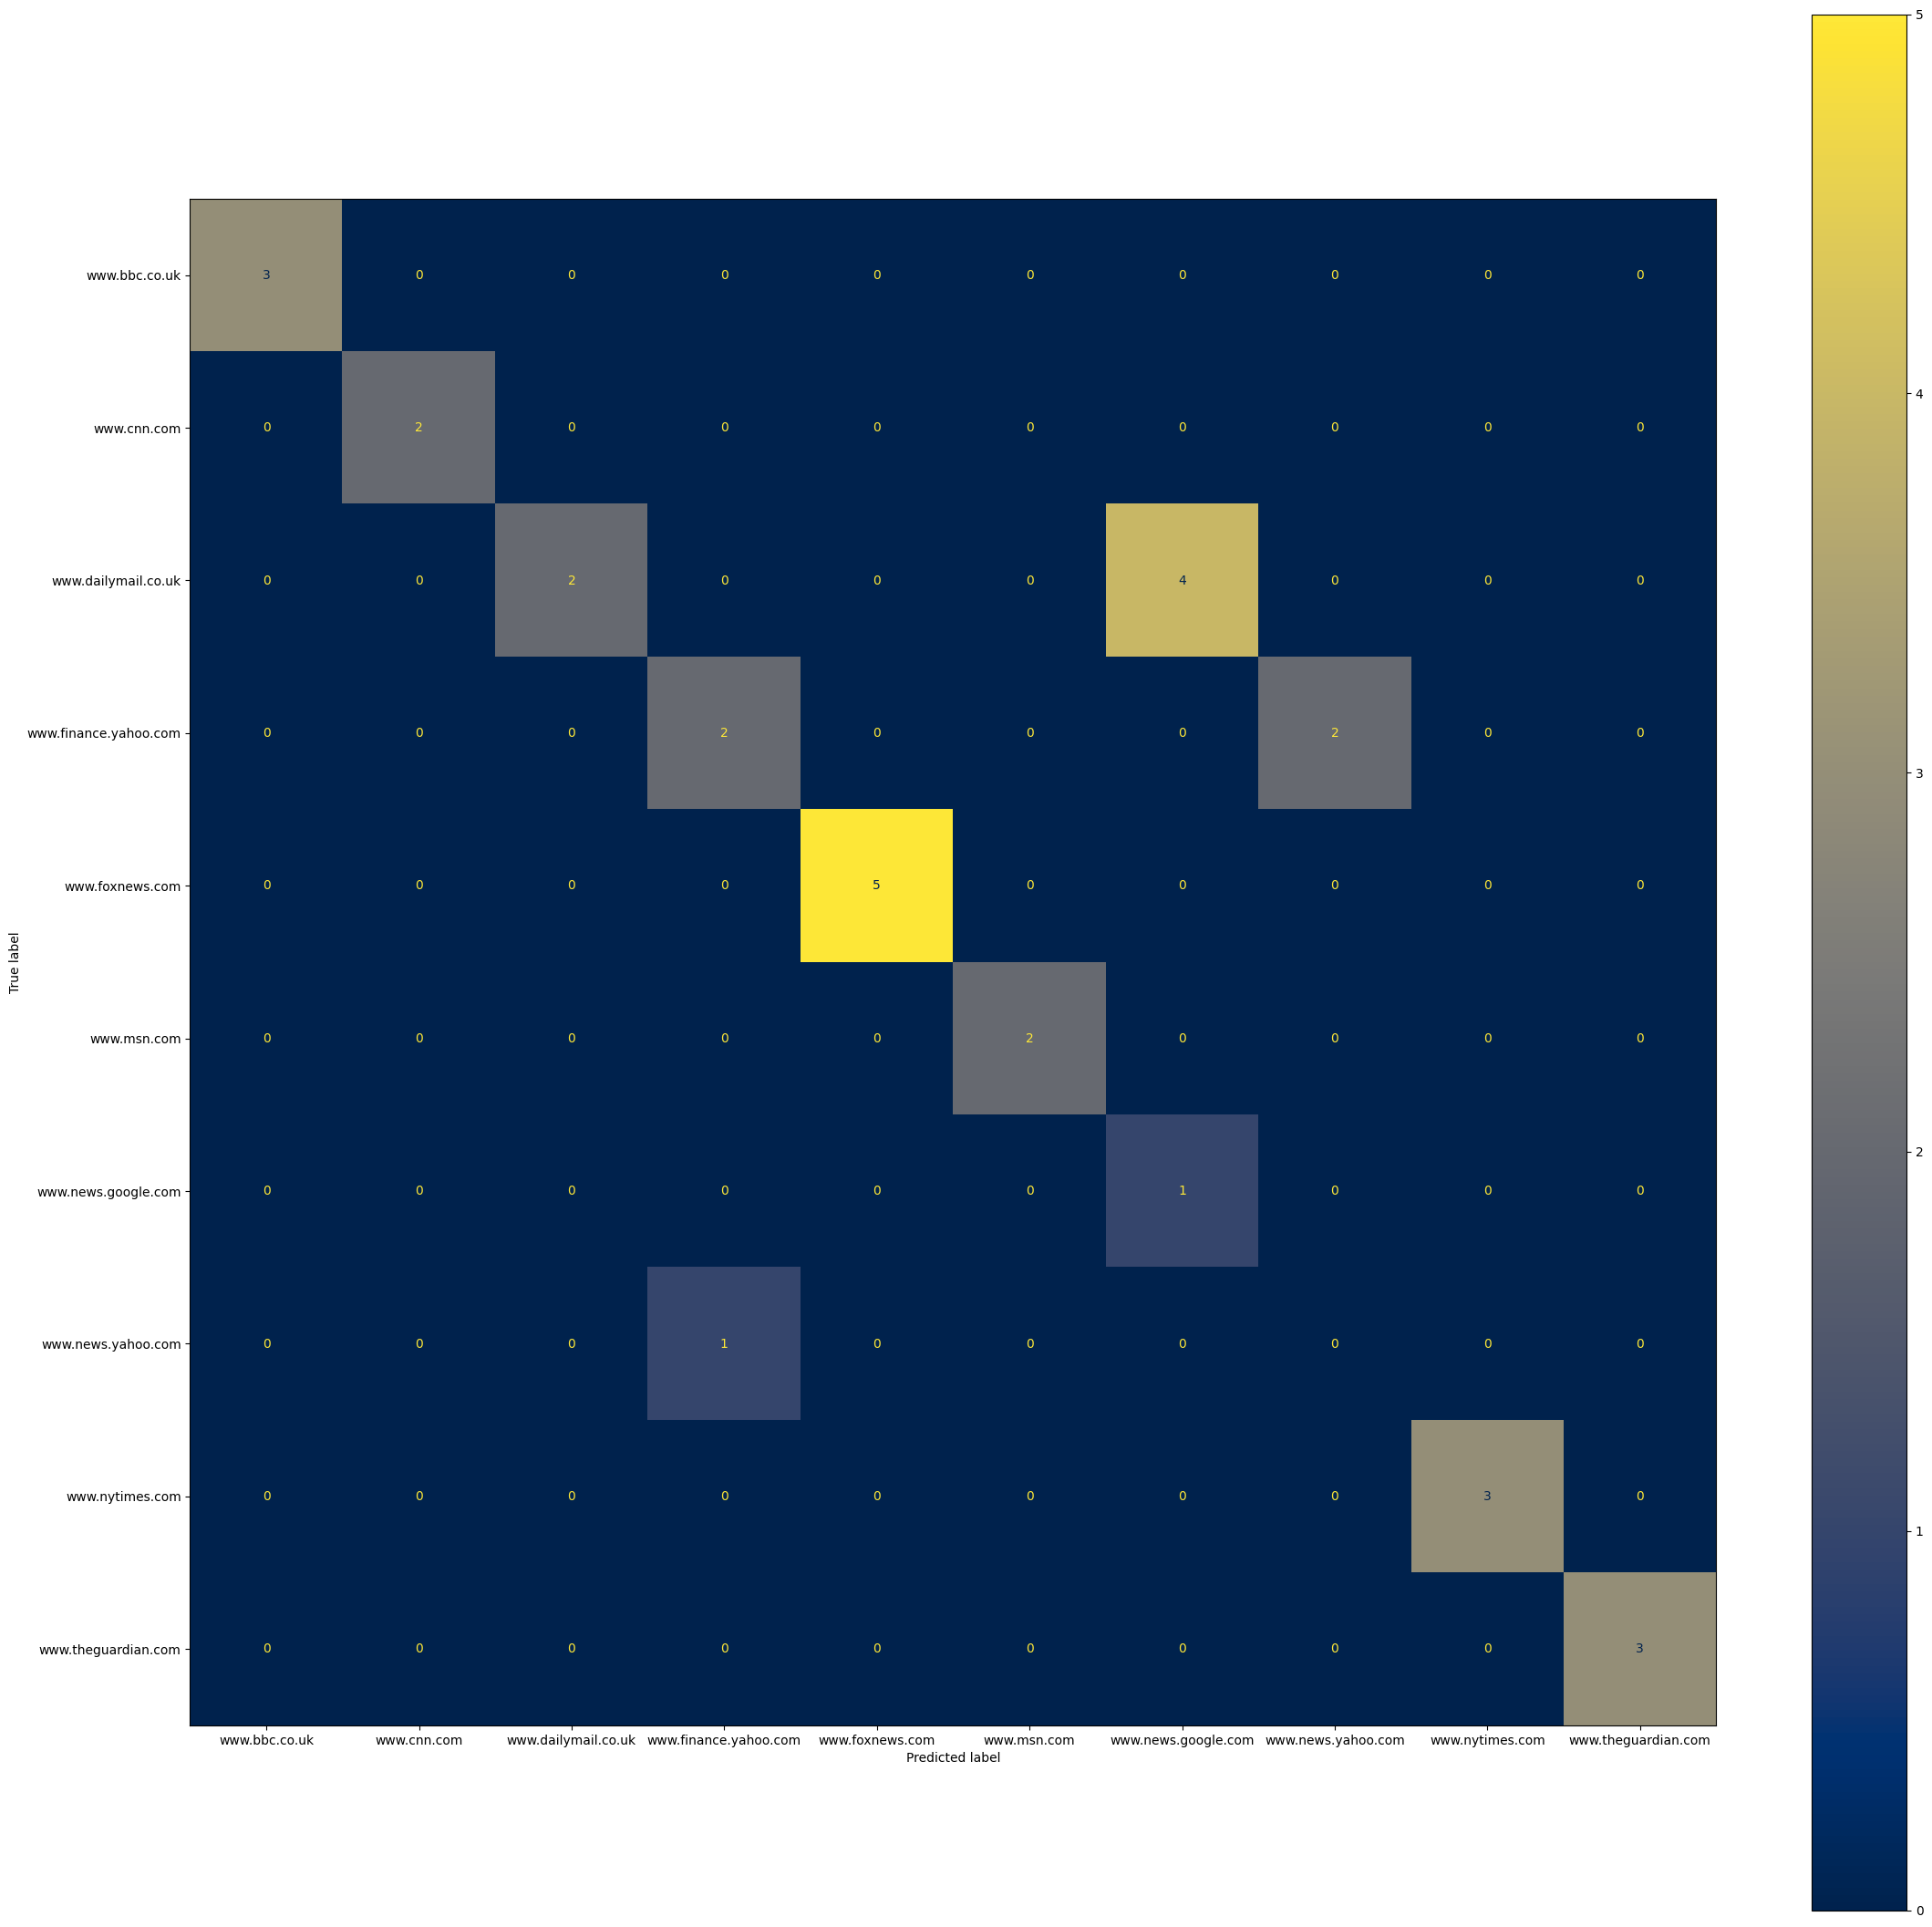

[0.92 0.96 0.88 0.92]


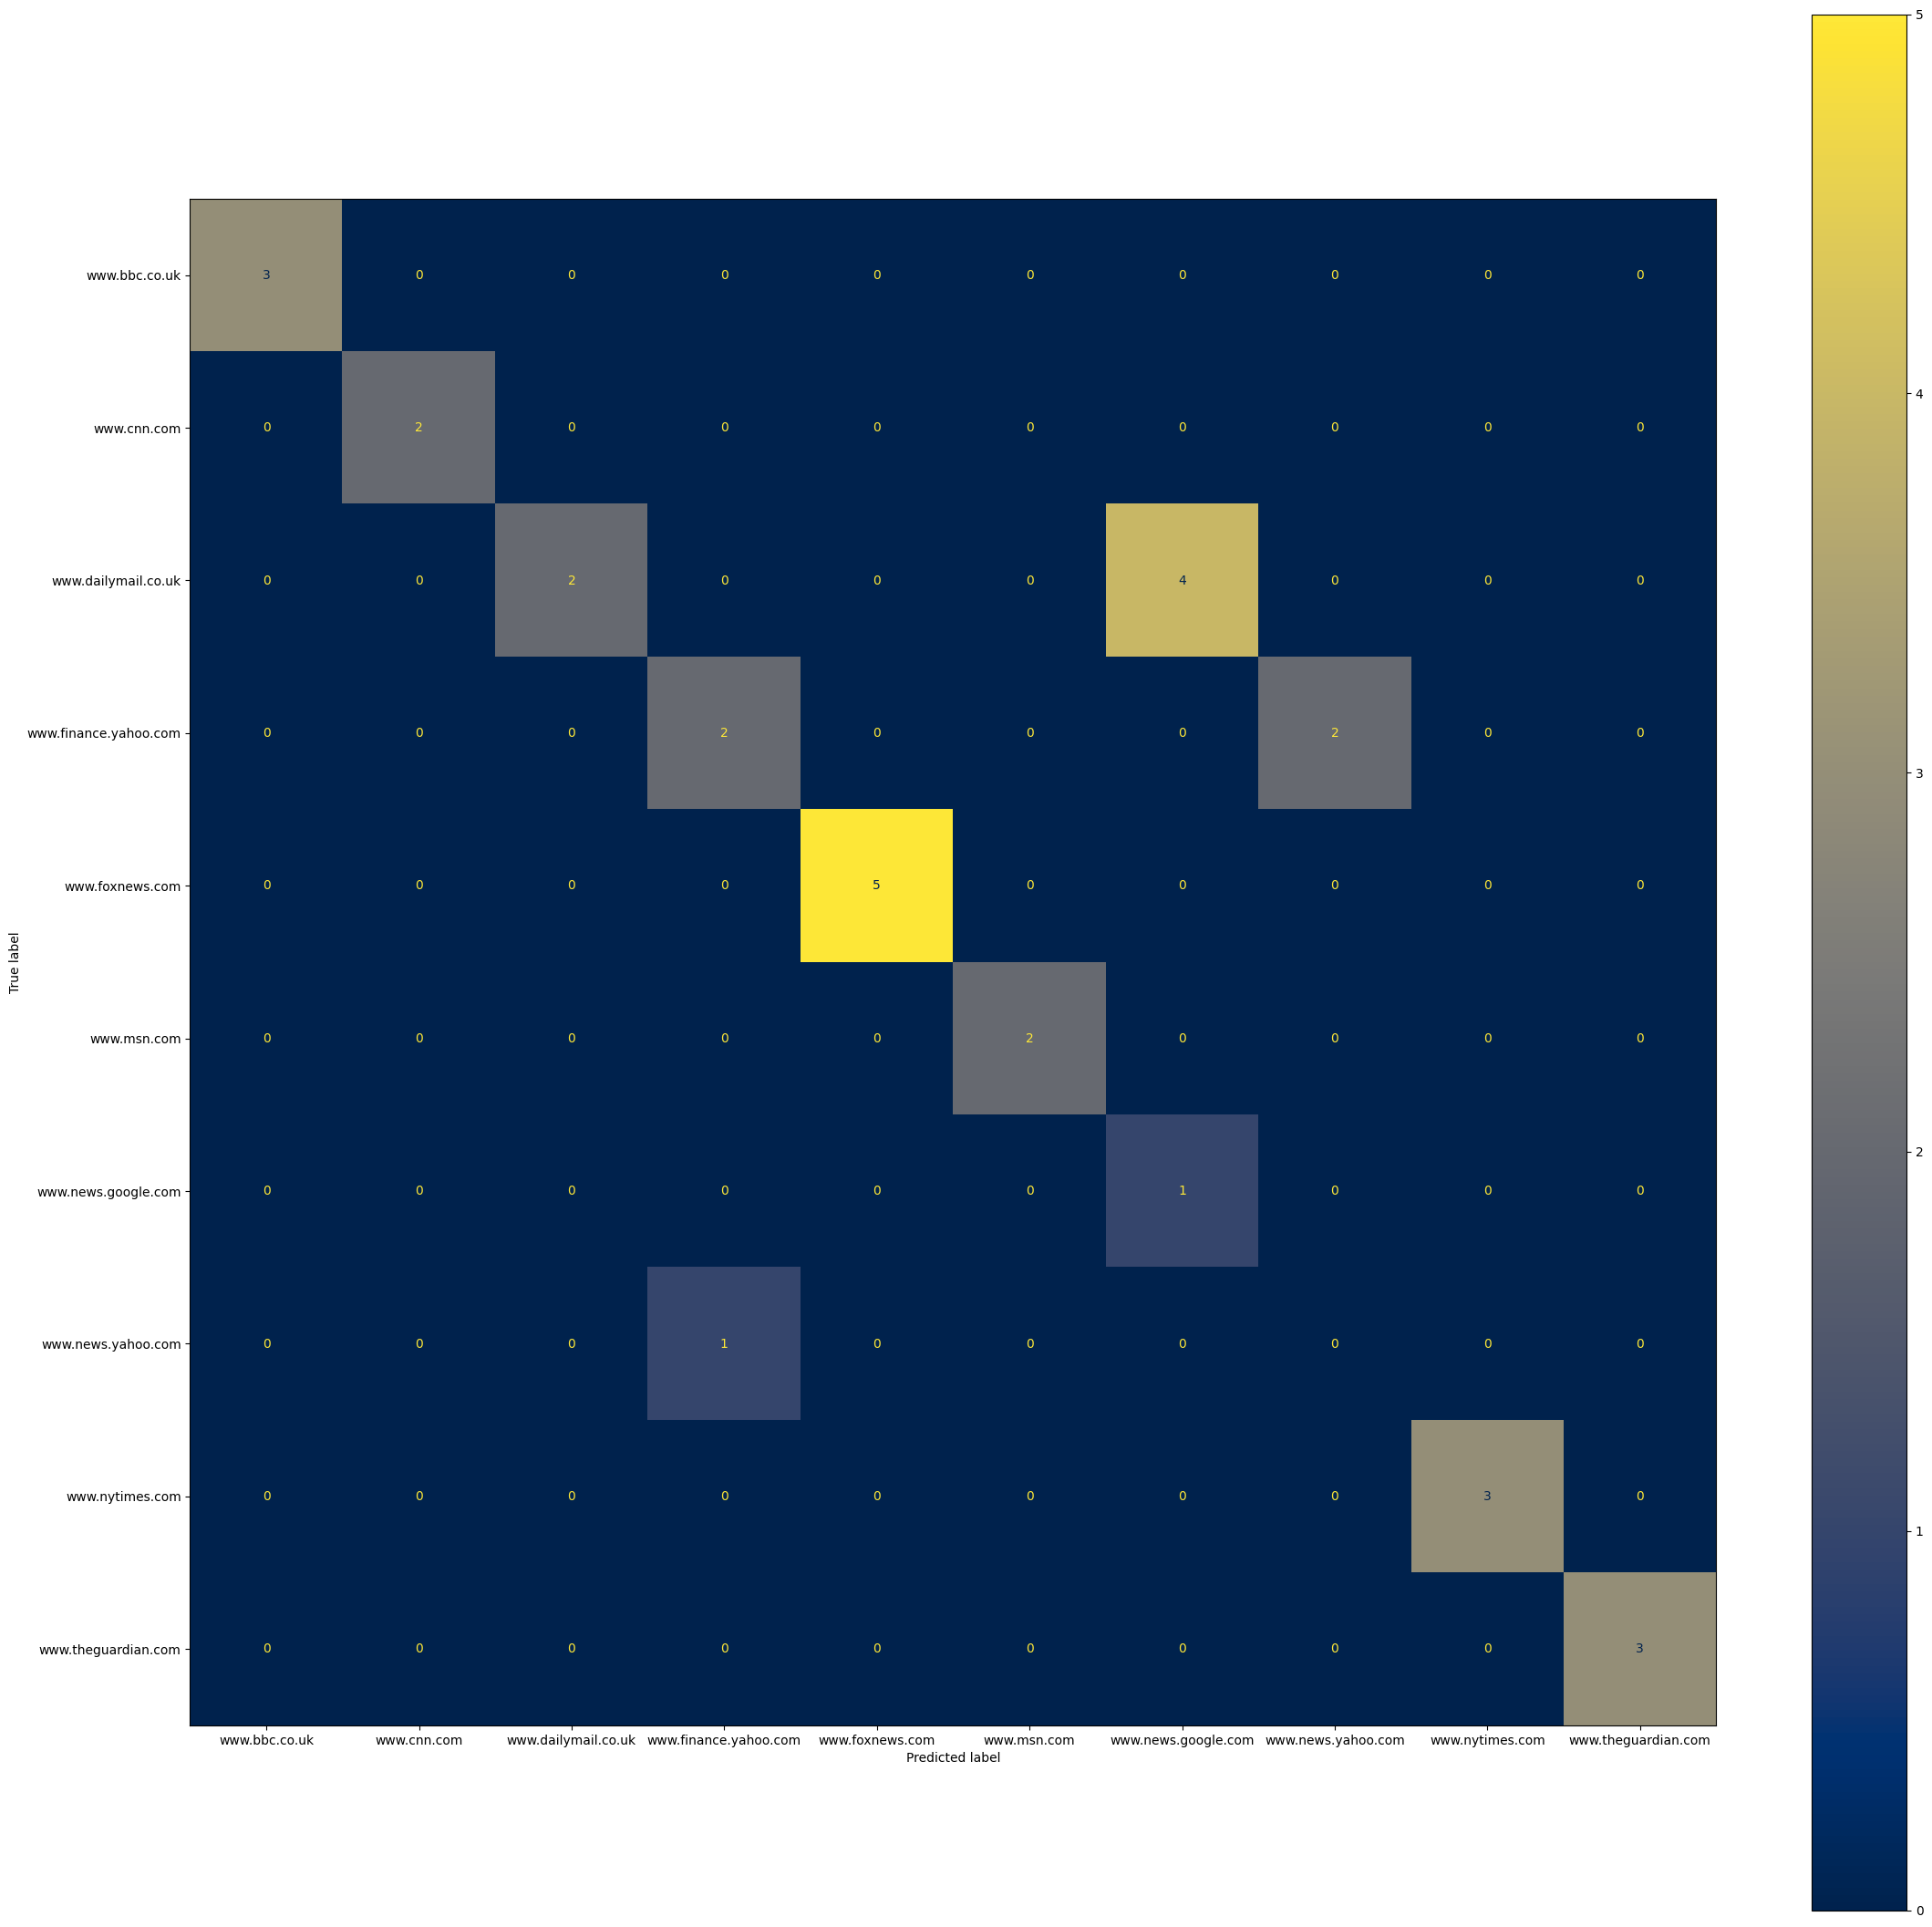

[0.92 0.88 0.88 0.92]


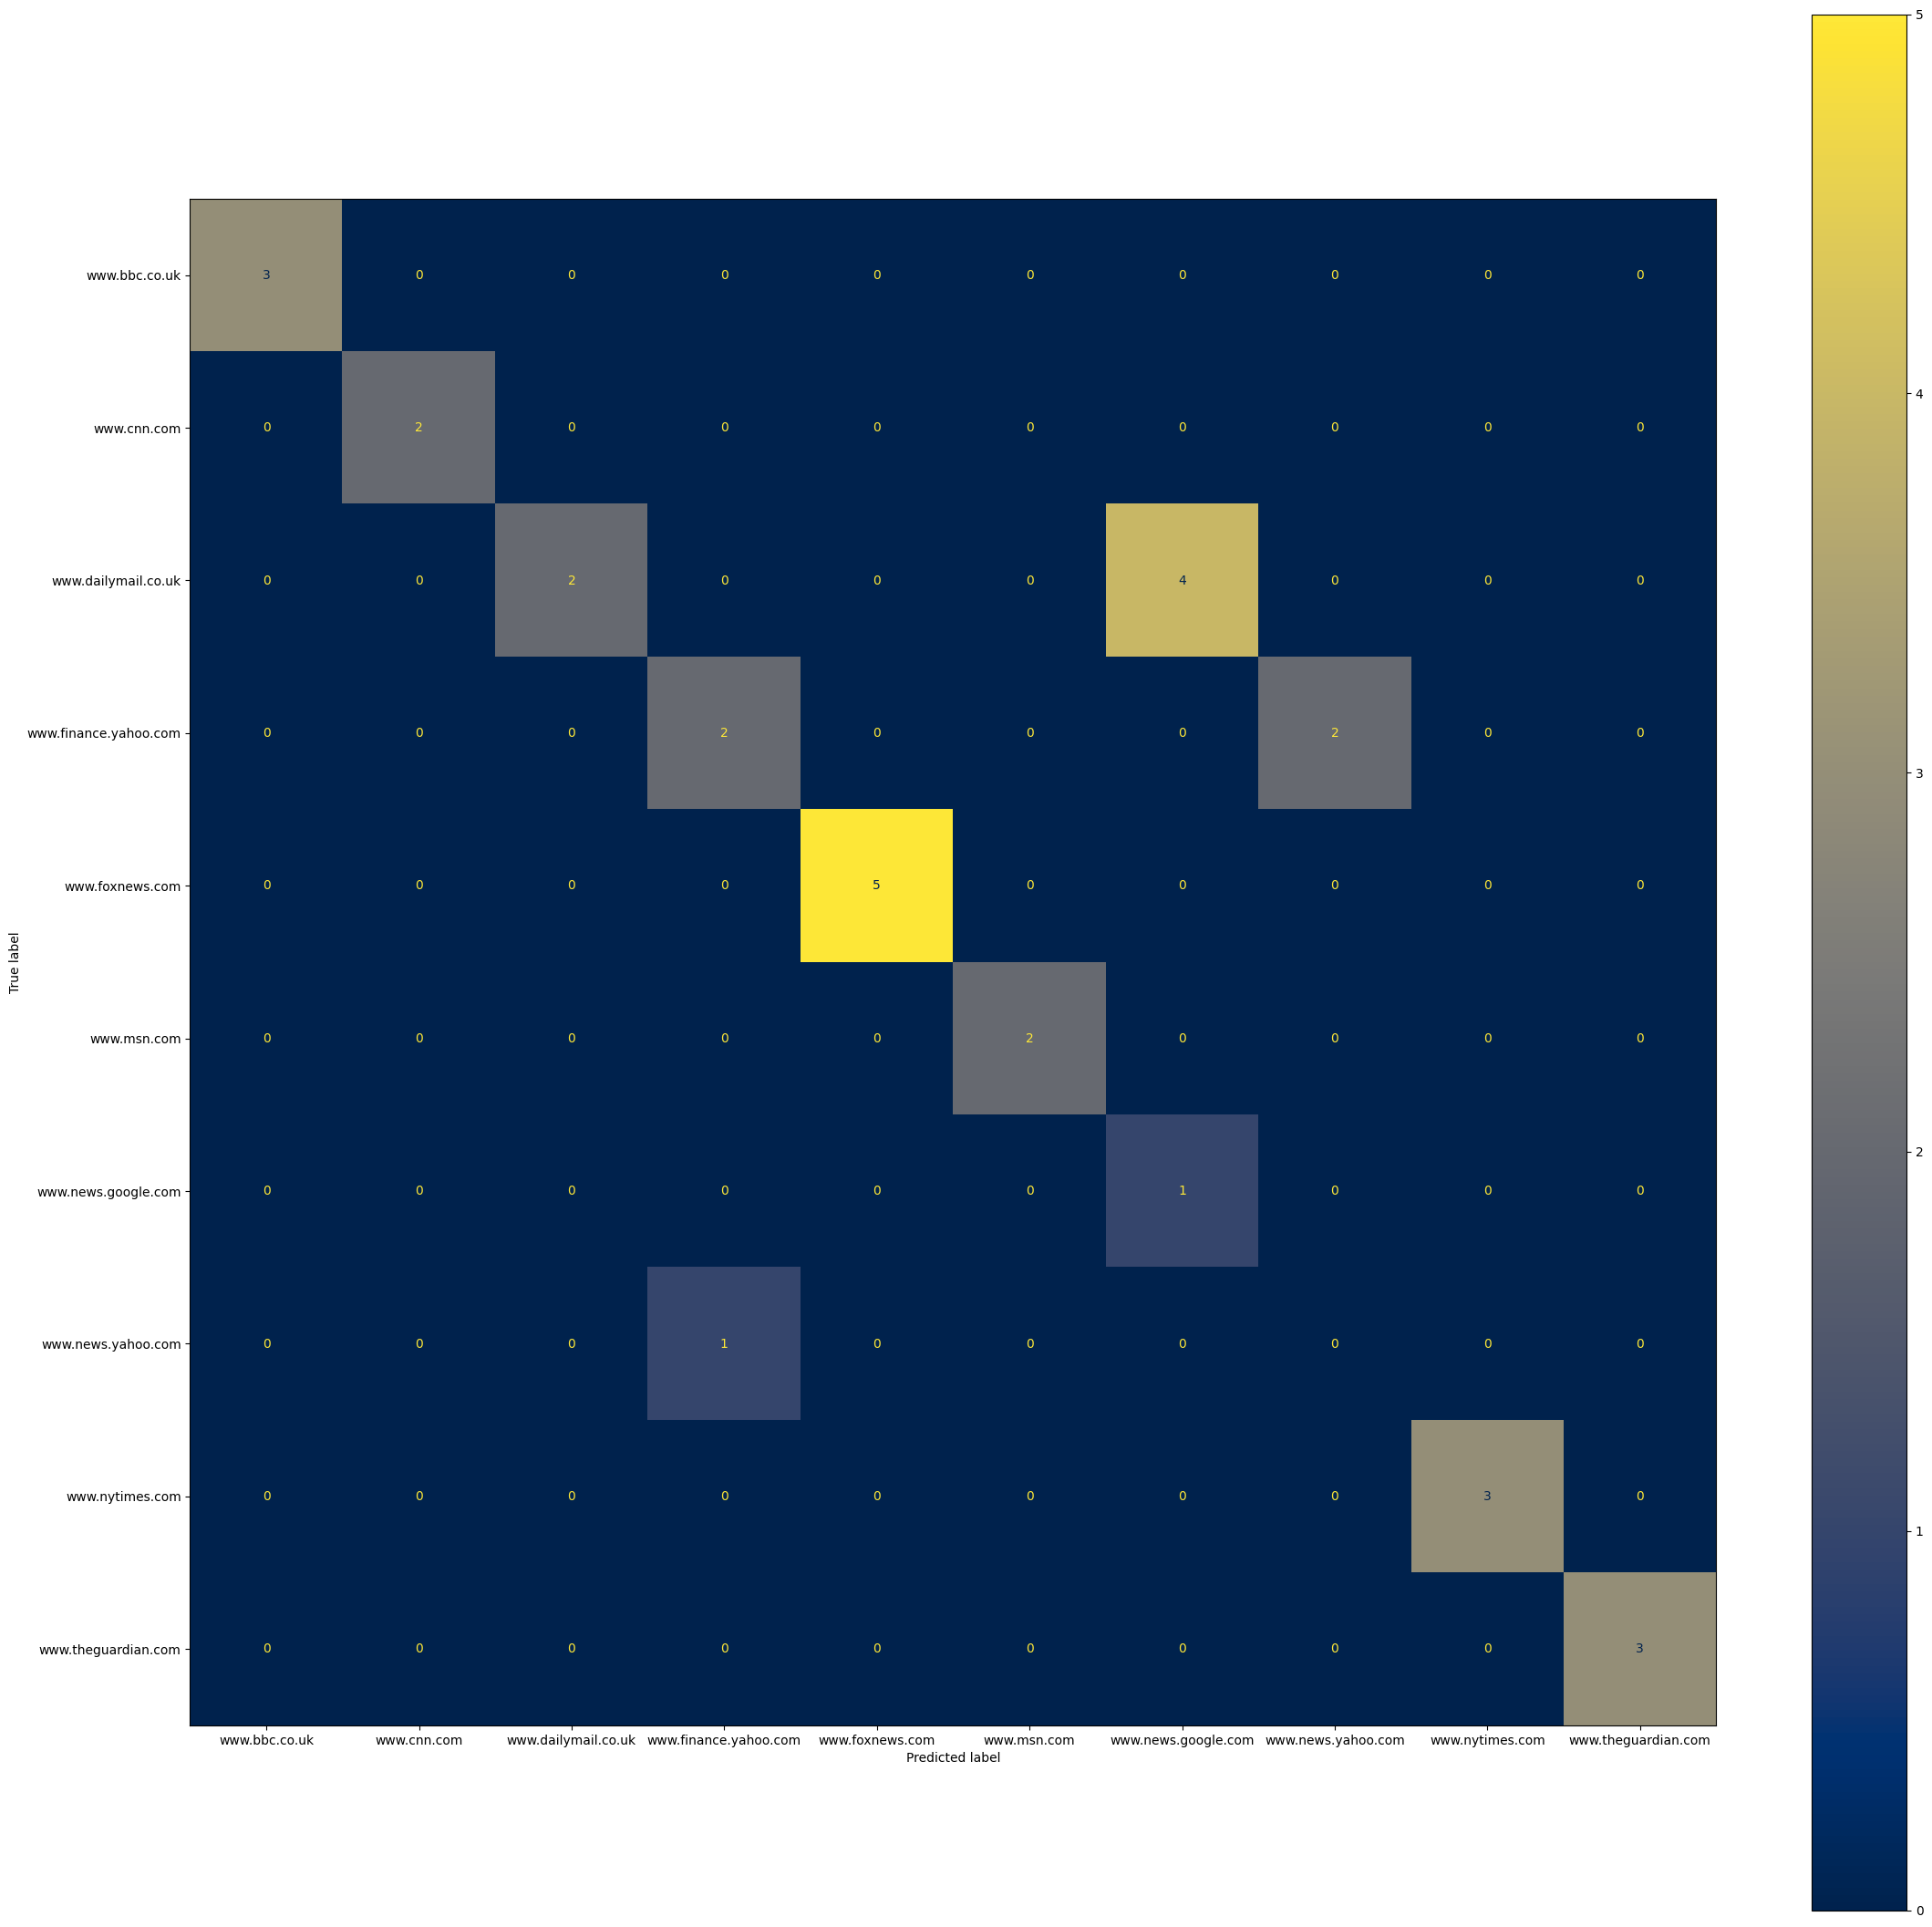

[0.92 0.88 0.88 0.92]


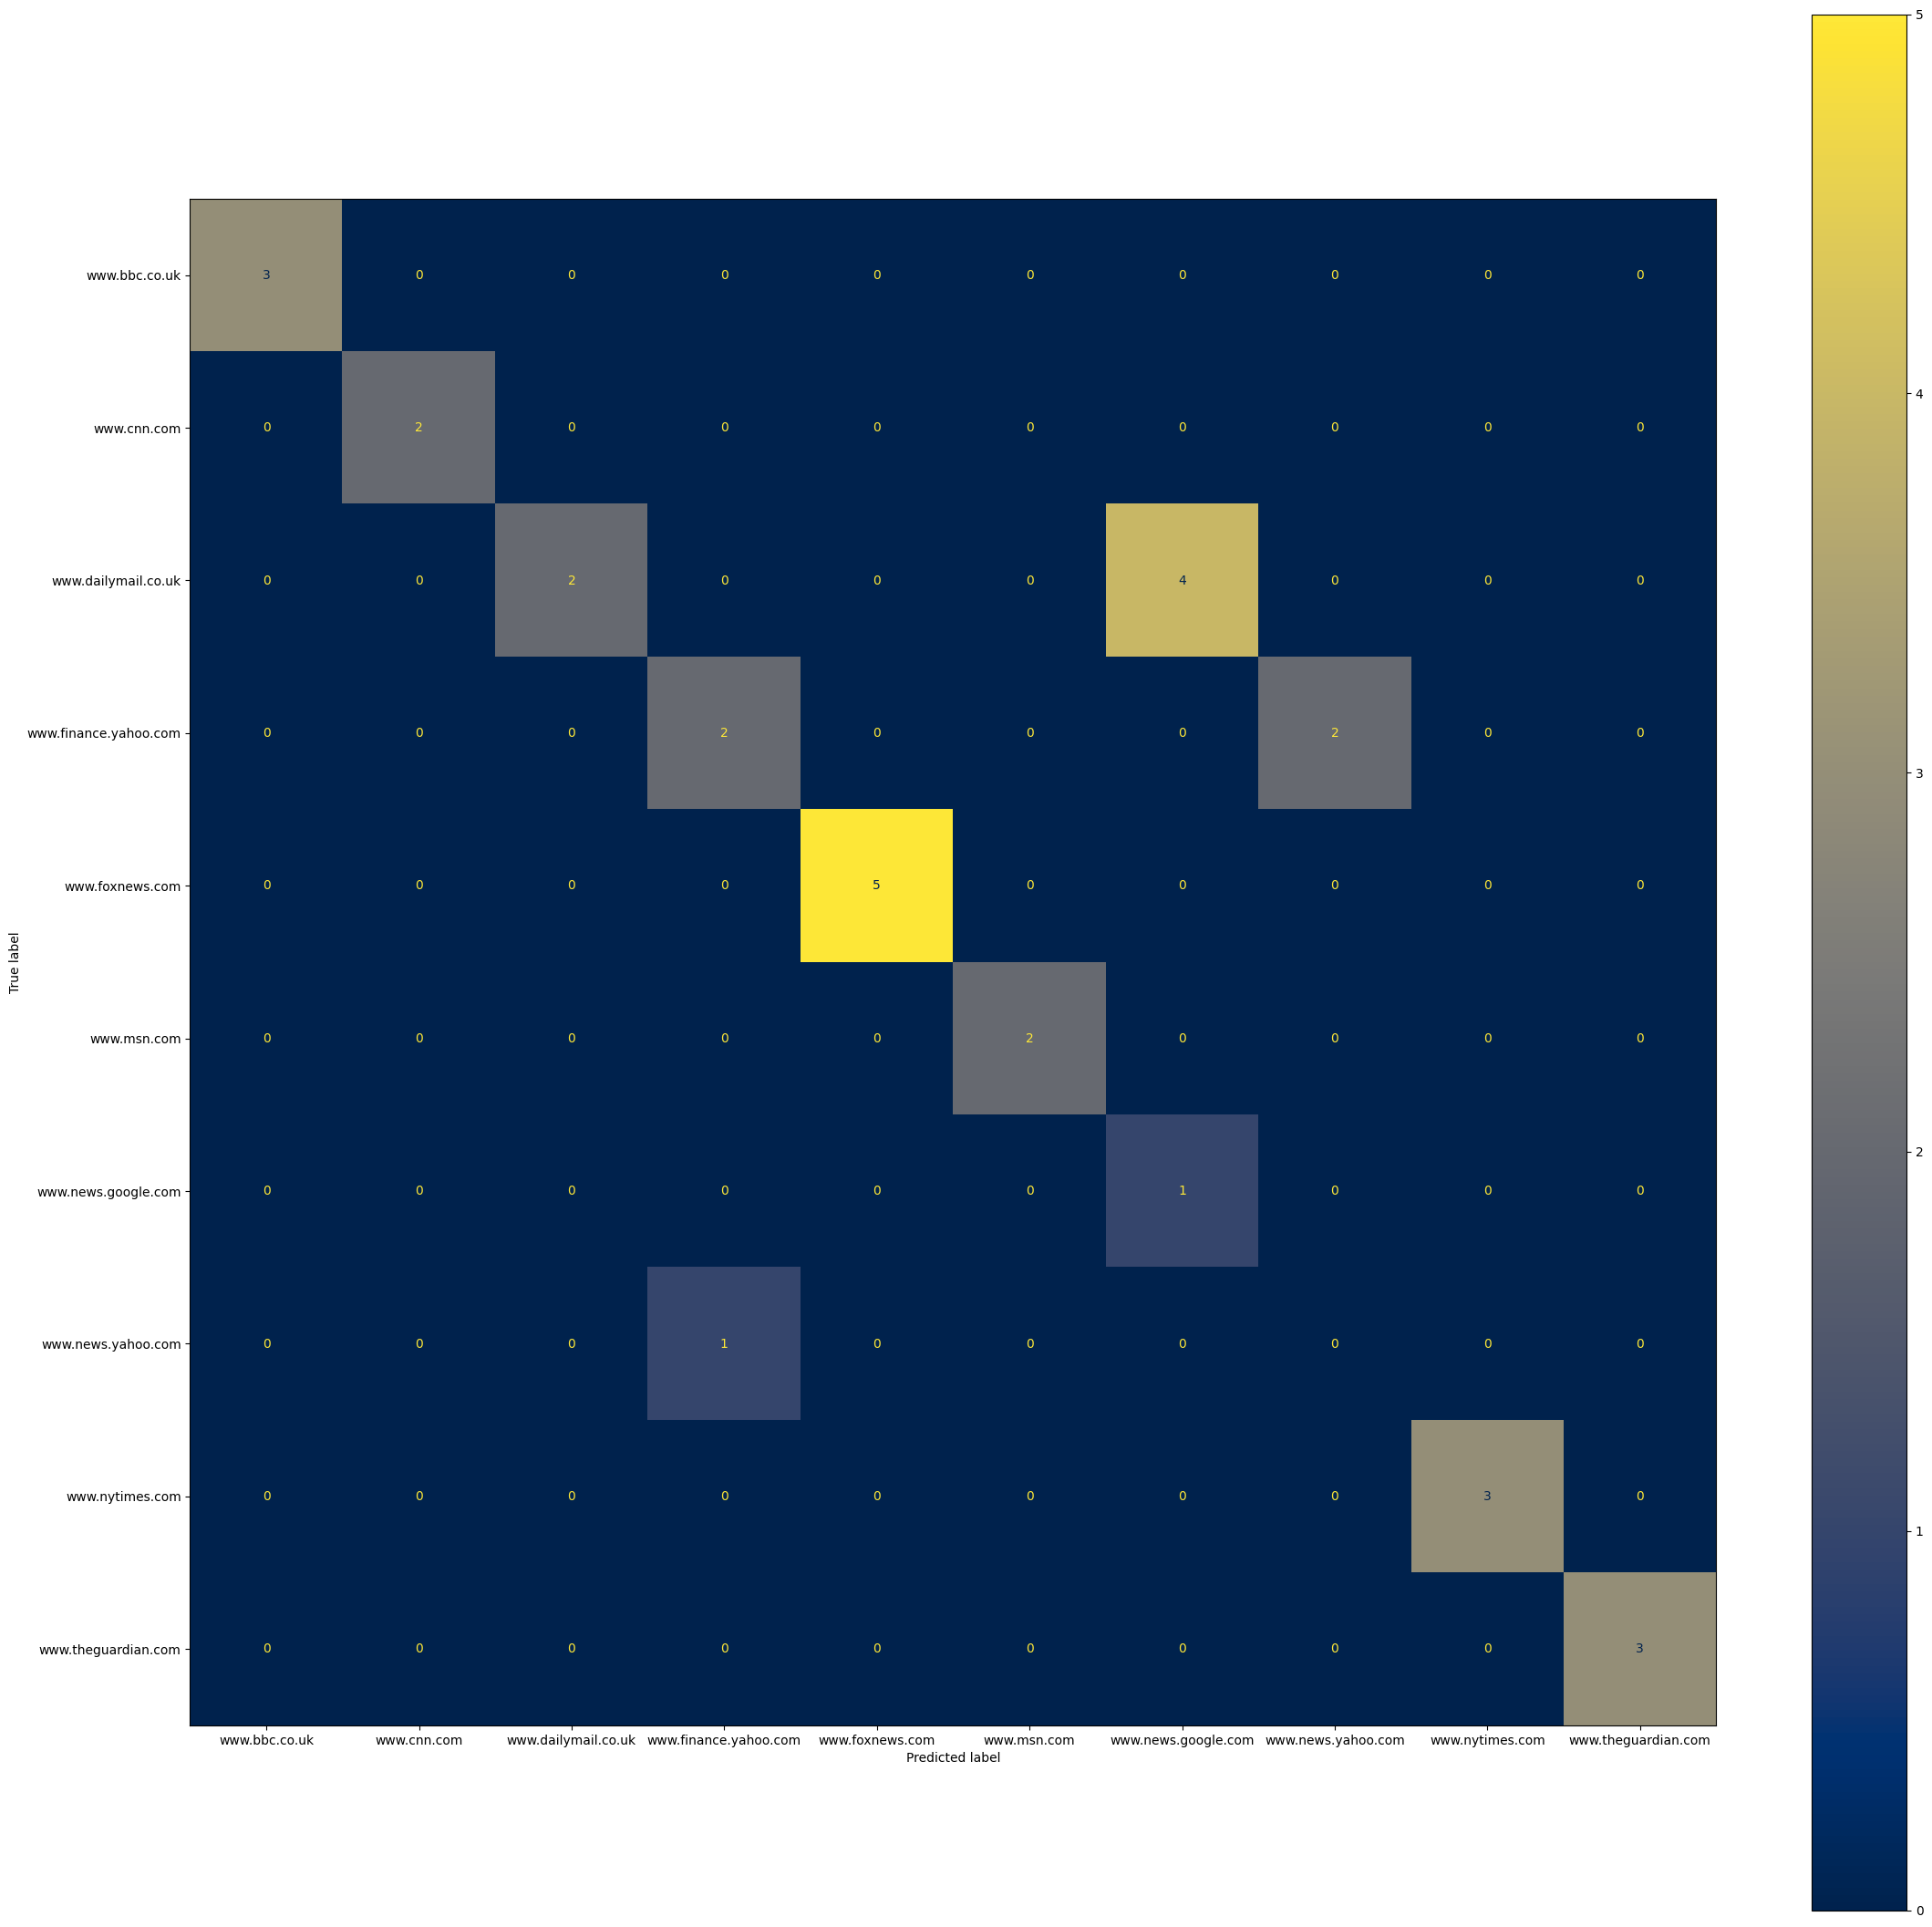

[0.88 0.88 0.92 0.92]


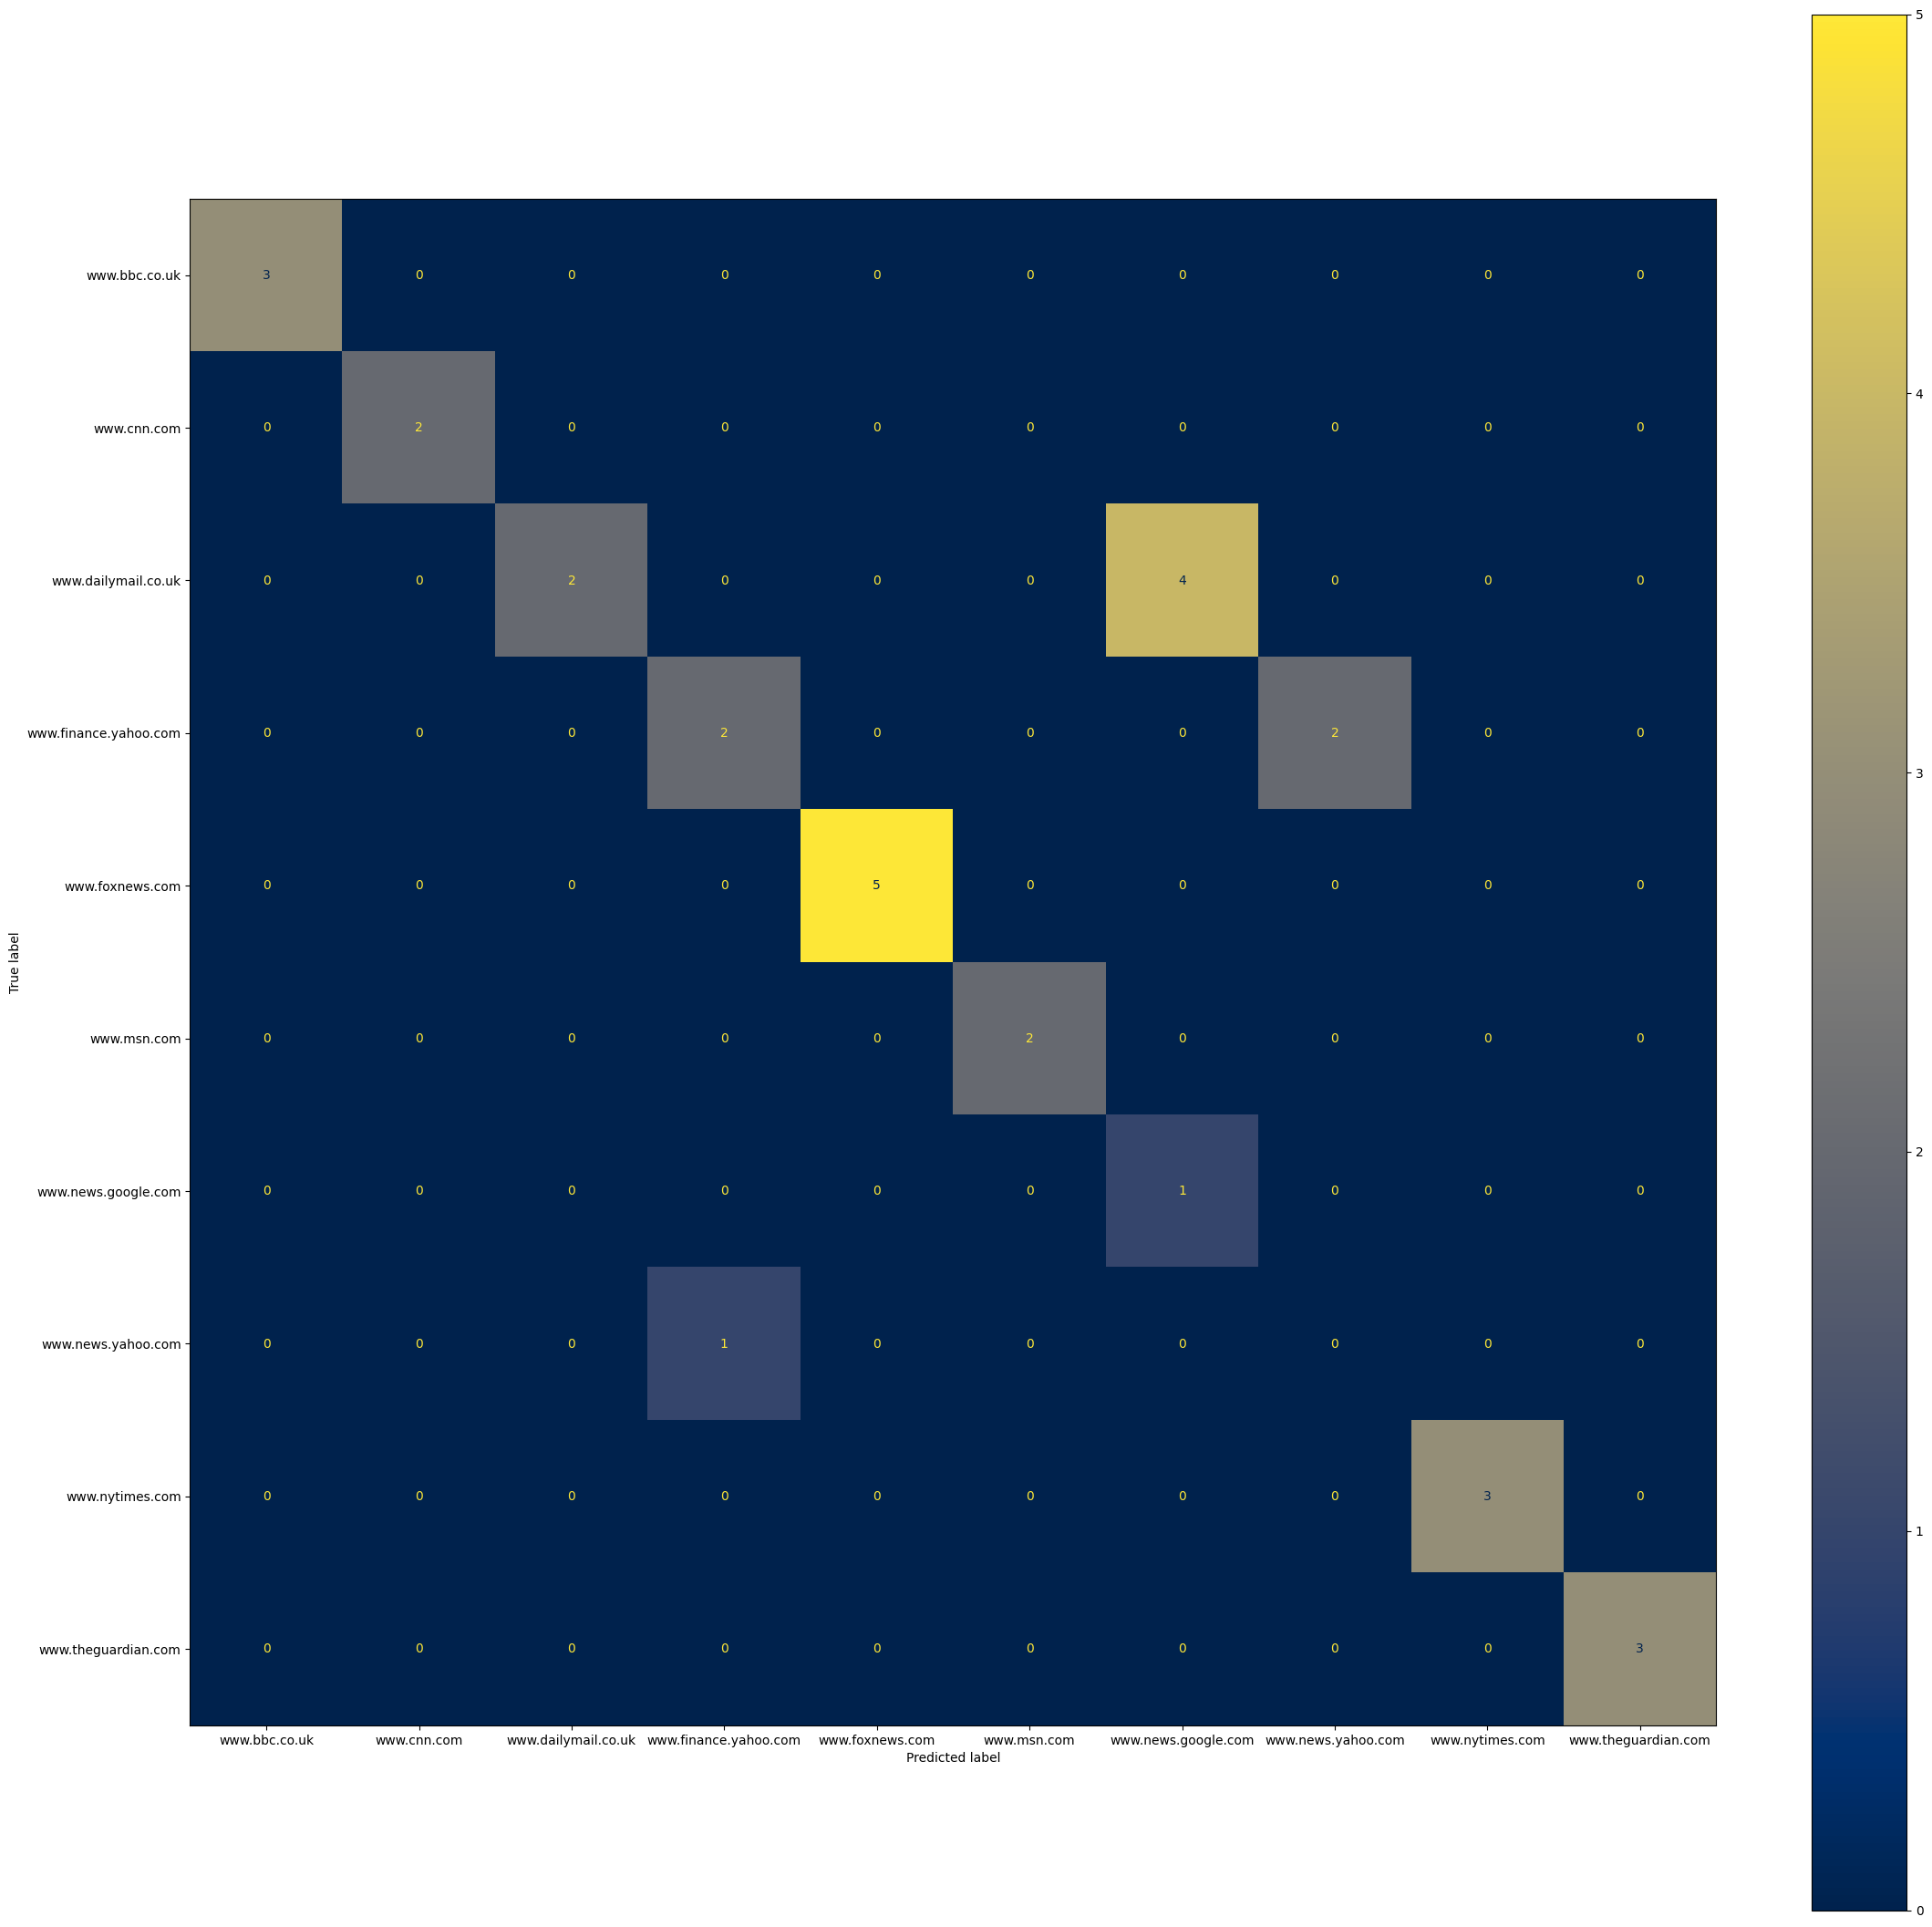

[0.91, 0.9199999999999999, 0.9299999999999999, 0.9, 0.9099999999999999, 0.9199999999999999, 0.9199999999999999, 0.9, 0.9, 0.9]


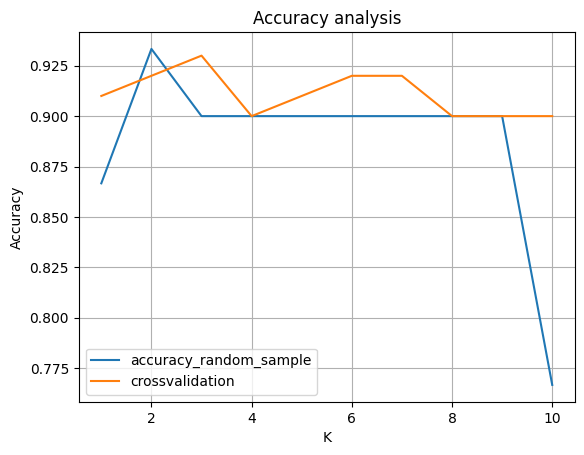

In [17]:
# drop the columns related to the ports from the dataset
X = dataset.drop(['srcport','dport'],axis=1).dropna();

#assign the label
y = X['site']
#display(y)

X = X.drop(['site'],axis=1)

# Divide the dataset in training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Uncomment to see results with scaled datas
# Scaling datas
#scaler = MinMaxScaler()
#X_norm_train = scaler.fit_transform(X_train)
#X_norm_test = scaler.transform(X_test)

#scaler = StandardScaler()
#X_norm_train = scaler.fit_transform(X_train)
#X_norm_test = scaler.transform(X_test)

X_norm_train = X_train
X_norm_test = X_test

k_tot = 10;
accuracy = []
k = []

for i in range(1, k_tot+1):

  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_norm_train, y_train)

  # Do predictions on the test set
  y_pred = knn.predict(X_norm_test)

  # Calculate the accuracy
  accuracy.append(accuracy_score(y_test, y_pred))
  k.append(i)
print("Accuracy:", accuracy)

scores = []

#scaler = StandardScaler()
#X_cross = scaler.fit_transform(X)

for j in range(1, k_tot+1):

    knn = KNeighborsClassifier(n_neighbors=j)
    score = cross_val_score(knn, X, y, cv=4)
    print(score)
    scores.append(np.mean(score))

    # Show the confusion matrix
    fig, ax = plt.subplots(figsize=(27, 27));
    ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax,cmap='cividis');
    plt.show()

print(scores)

plt.title('Accuracy analysis')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(visible= True)
plt.plot(k,accuracy)

plt.plot(k,scores)
plt.legend(["accuracy_random_sample", "crossvalidation"])

The plot shows that the accuracy decrease when k increase.For a better evaluation also the cross-validation has been added. The cross validation is a reliable way to analyze the accuracy of the system. Also in this case the accuracy is decreasing when K is increasing because up to a certain K it can happen that the correct class cannot have the majority.

In [ ]:
from matplotlib import colormaps
list(colormaps)

#***SECOND CAPTURE***

In [ ]:
%%shell
# List of websites to visit
websites=("https://www.bbc.co.uk" "https://www.msn.com" "https://www.cnn.com" 'https://www.news.google.com'
"https://www.dailymail.co.uk" "https://www.nytimes.com" "https://www.theguardian.com" "https://www.foxnews.com"
"https://www.finance.yahoo.com" "https://www.news.yahoo.com")

# Number of visits
visits=3

# Directory to save .pcap files
pcap_dir="./pcap_files_new"
# Directory to save .csv files
csv_dir="./csv_files_new"

# Create directory if it doesn't exist
mkdir -p "$pcap_dir"
mkdir -p "$csv_dir"

# Loop through each website
for website in "${websites[@]}"; do
    # Extract the domain name for the filename
    domain=$(echo "$website" | awk -F[/:] '{print $4}') #This line extracts the domain name from the URL and stores it in the variable domain.
    #It uses 'awk' to split the URL using the delimiters [/:] and prints the fourth field, which corresponds to the domain.
    # "|" is used to concatenate an output of a command with an input of another command, "awk -F[/:]" is used to manipulate a text file, in particular,
    # is used to divide each row into fields using the character : or \ as a delimiter

    # Loop through the visits
    for (( i=1; i<=$visits; i++ )); do
        echo "Visiting $website, visit $i..."

        # Set the filename for each visit
        filename="${pcap_dir}/${domain}_visit_${i}.pcap" #This line sets the filename for the .pcap file to be saved. It combines the pcap_dir with
        #the domain name and appends _all_visits.pcap. {pcap_dir}/${domain} describes the path for saving the pcap file

        tcpdump -i eth0 -nn -X -w "$filename" " port 443" &
        # This command is used to capture packets on the interface 'eth0, referred to a specific port, the 443, that is used by HTTPS protocol,
        # the '-nn' option is used to tell tcpdump to display numerical values for addresses and ports instead of attempting to resolve
        # them to hostnames or service names and the '-X' option  instructs tcpdump to print each packet in both hex and ASCII format.

        #wait for the activation of tcpdump
        sleep 1

        # Visit the website using curl
        curl -s "$website" > /dev/null #-s means silent, so is uset for not showing the output,

        # wait for the capture to be completed
        sleep 2

        pkill -2 tcpdump

        # Wait for a brief moment before the next visit
        sleep 2
    done

    # Wait for all visits to complete
    sleep 1

    echo "All visits to $website captured in $filename"

    for (( i=1; i<=$visits; i++ )); do
        pcap_filename="${pcap_dir}/${domain}_visit_${i}.pcap"

        #tshark is used to convert the pcap file into a CSV file
        tshark -r "$pcap_filename" -T fields -E header=y -E quote=d -E separator=, -e frame.number -e frame.time -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e frame.len -e tcp.len -e tcp.flags > "${csv_dir}/${domain}_visit_${i}.csv"
    done
done

echo "Packet capturing complete."

In [ ]:
!zip -r csv_files_new.zip csv_files_new
# This line of command is used to zip the folder containing the new captures

In [18]:
!unzip csv_files_new.zip
# This line of command is used to unzip the folder conatining the new captures

Archive:  csv_files_new.zip
   creating: csv_files_new/
  inflating: csv_files_new/www.foxnews.com_visit_1.csv  
  inflating: csv_files_new/www.dailymail.co.uk_visit_2.csv  
  inflating: csv_files_new/www.theguardian.com_visit_1.csv  
  inflating: csv_files_new/www.nytimes.com_visit_3.csv  
  inflating: csv_files_new/www.cnn.com_visit_2.csv  
  inflating: csv_files_new/www.theguardian.com_visit_2.csv  
  inflating: csv_files_new/www.foxnews.com_visit_3.csv  
  inflating: csv_files_new/www.news.google.com_visit_3.csv  
  inflating: csv_files_new/www.dailymail.co.uk_visit_3.csv  
  inflating: csv_files_new/www.msn.com_visit_2.csv  
  inflating: csv_files_new/www.theguardian.com_visit_3.csv  
  inflating: csv_files_new/www.news.yahoo.com_visit_3.csv  
  inflating: csv_files_new/www.bbc.co.uk_visit_2.csv  
  inflating: csv_files_new/www.finance.yahoo.com_visit_3.csv  
  inflating: csv_files_new/www.news.google.com_visit_1.csv  
  inflating: csv_files_new/www.nytimes.com_visit_2.csv  
  inf

In [19]:
path2 = "/content/csv_files_new"

# Create a list containing all the csv files
tcpdumpfiles = [f for f in listdir(path2) if isfile(join(path2,f))]#sto creando una lista contenente tutti i file csv

site2 = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(site2 ,len(site2), len(tcpdumpfiles))

dataset_list2 = []
dataset_down2 = []
dataset_up2 = []

for f in tcpdumpfiles:

  print("Processing file:  ",f)
  df2 = pd.read_csv(join(path2,f),low_memory=False)
  df_flow_tcp2 = df2.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

  for flow,df_flow in df_flow_tcp2:
    flow_features = extract_features(flow,df_flow,f)

    if (flow_features['direction']=='downlink'):
      # Remove the element having key element equal to 'direction'
      flow_features.pop('direction')
      dataset_down2.append(pd.DataFrame([flow_features]))
    else:
      flow_features.pop('direction')
      dataset_up2.append(pd.DataFrame([flow_features]))
print(len(dataset_up2))
print(len(dataset_down2))

if len(dataset_down2) == len(dataset_up2):
    # Iterating through both datasets together using zip
    for down, up in zip(dataset_down2, dataset_up2):
        # Combining downlink and uplink information into a single row and appending to the list
        combined_row2 = pd.concat([down, up.reset_index(drop=True)], axis=1)
        dataset_list2.append(combined_row2)
else:
    print("Errore: le lunghezze di dataset_down e dataset_up non corrispondono.")
  #except:
    #print('errore')
    #pass
print(dataset_list2)

['www.bbc.co.uk' 'www.cnn.com' 'www.dailymail.co.uk'
 'www.finance.yahoo.com' 'www.foxnews.com' 'www.msn.com'
 'www.news.google.com' 'www.news.yahoo.com' 'www.nytimes.com'
 'www.theguardian.com'] 10 30
Processing file:   www.foxnews.com_visit_2.csv
Processing file:   www.finance.yahoo.com_visit_1.csv
Processing file:   www.msn.com_visit_2.csv
Processing file:   www.cnn.com_visit_2.csv
Processing file:   www.theguardian.com_visit_1.csv
Processing file:   www.theguardian.com_visit_3.csv
Processing file:   www.finance.yahoo.com_visit_2.csv
Processing file:   www.dailymail.co.uk_visit_3.csv
Processing file:   www.nytimes.com_visit_3.csv
Processing file:   www.dailymail.co.uk_visit_1.csv
Processing file:   www.bbc.co.uk_visit_1.csv
Processing file:   www.nytimes.com_visit_1.csv
Processing file:   www.theguardian.com_visit_2.csv
Processing file:   www.cnn.com_visit_3.csv
Processing file:   www.bbc.co.uk_visit_2.csv
Processing file:   www.news.google.com_visit_2.csv
Processing file:   www.cnn

In [20]:
dataset_new = pd.DataFrame()
dataset_new = pd.concat(dataset_list2,ignore_index=True)

display(dataset_new)

,srcport,dport,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,...,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,duration_up,site
0,443,49472,76,641329.0,66.0,52194.0,8438.539474,10233.120102,0.000001,0.102112,...,54.0,583.0,77.428571,60.626646,0.000007,0.095325,0.003306,0.012357,0.251277,www.foxnews.com
1,443,37788,12,11838.0,66.0,4162.0,986.500000,1436.207284,0.000058,0.093525,...,66.0,583.0,116.176471,124.939603,0.000033,0.087510,0.010444,0.022706,0.167100,www.finance.yahoo.com
2,443,51176,36,54565.0,54.0,4434.0,1515.694444,1826.855203,0.000000,0.065539,...,54.0,571.0,111.764706,125.132694,0.000014,0.058965,0.008222,0.015489,0.131548,www.msn.com
3,443,58506,215,2639420.0,66.0,31834.0,12276.372093,8728.926839,0.000001,0.066066,...,54.0,583.0,69.764151,36.412344,0.000007,0.060156,0.001391,0.004170,0.293549,www.cnn.com
4,443,40360,17,6475.0,66.0,2954.0,380.882353,772.530815,0.000000,0.066310,...,54.0,583.0,116.187500,127.301332,0.000007,0.059004,0.006297,0.014936,0.094460,www.theguardian.com
5,443,48960,16,6387.0,66.0,2954.0,399.187500,794.075246,0.000001,0.107056,...,54.0,583.0,116.187500,127.301332,0.000008,0.099675,0.009064,0.025262,0.135956,www.theguardian.com
6,443,37798,13,11052.0,54.0,4150.0,850.153846,1255.419508,0.000001,0.062993,...,66.0,583.0,118.562500,126.230461,0.000009,0.057003,0.008979,0.016925,0.134692,www.finance.yahoo.com
7,443,49598,15,5226.0,66.0,2962.0,348.400000,734.543765,0.000002,0.099383,...,54.0,583.0,114.235294,124.063255,0.000008,0.092617,0.008400,0.022678,0.134397,www.dailymail.co.uk
8,443,45480,109,871569.0,66.0,18838.0,7996.045872,5924.818974,0.000001,0.068696,...,54.0,583.0,73.728972,51.313791,0.000012,0.062807,0.001741,0.006134,0.184588,www.nytimes.com
9,443,53886,12,5027.0,66.0,2962.0,418.916667,812.130583,0.000001,0.065508,...,54.0,583.0,118.000000,127.125135,0.000008,0.058487,0.010916,0.016554,0.163738,www.dailymail.co.uk


#***NEW KNN***


Accuracy: [0.8666666666666667, 0.8666666666666667, 0.9, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8333333333333334, 0.8666666666666667]


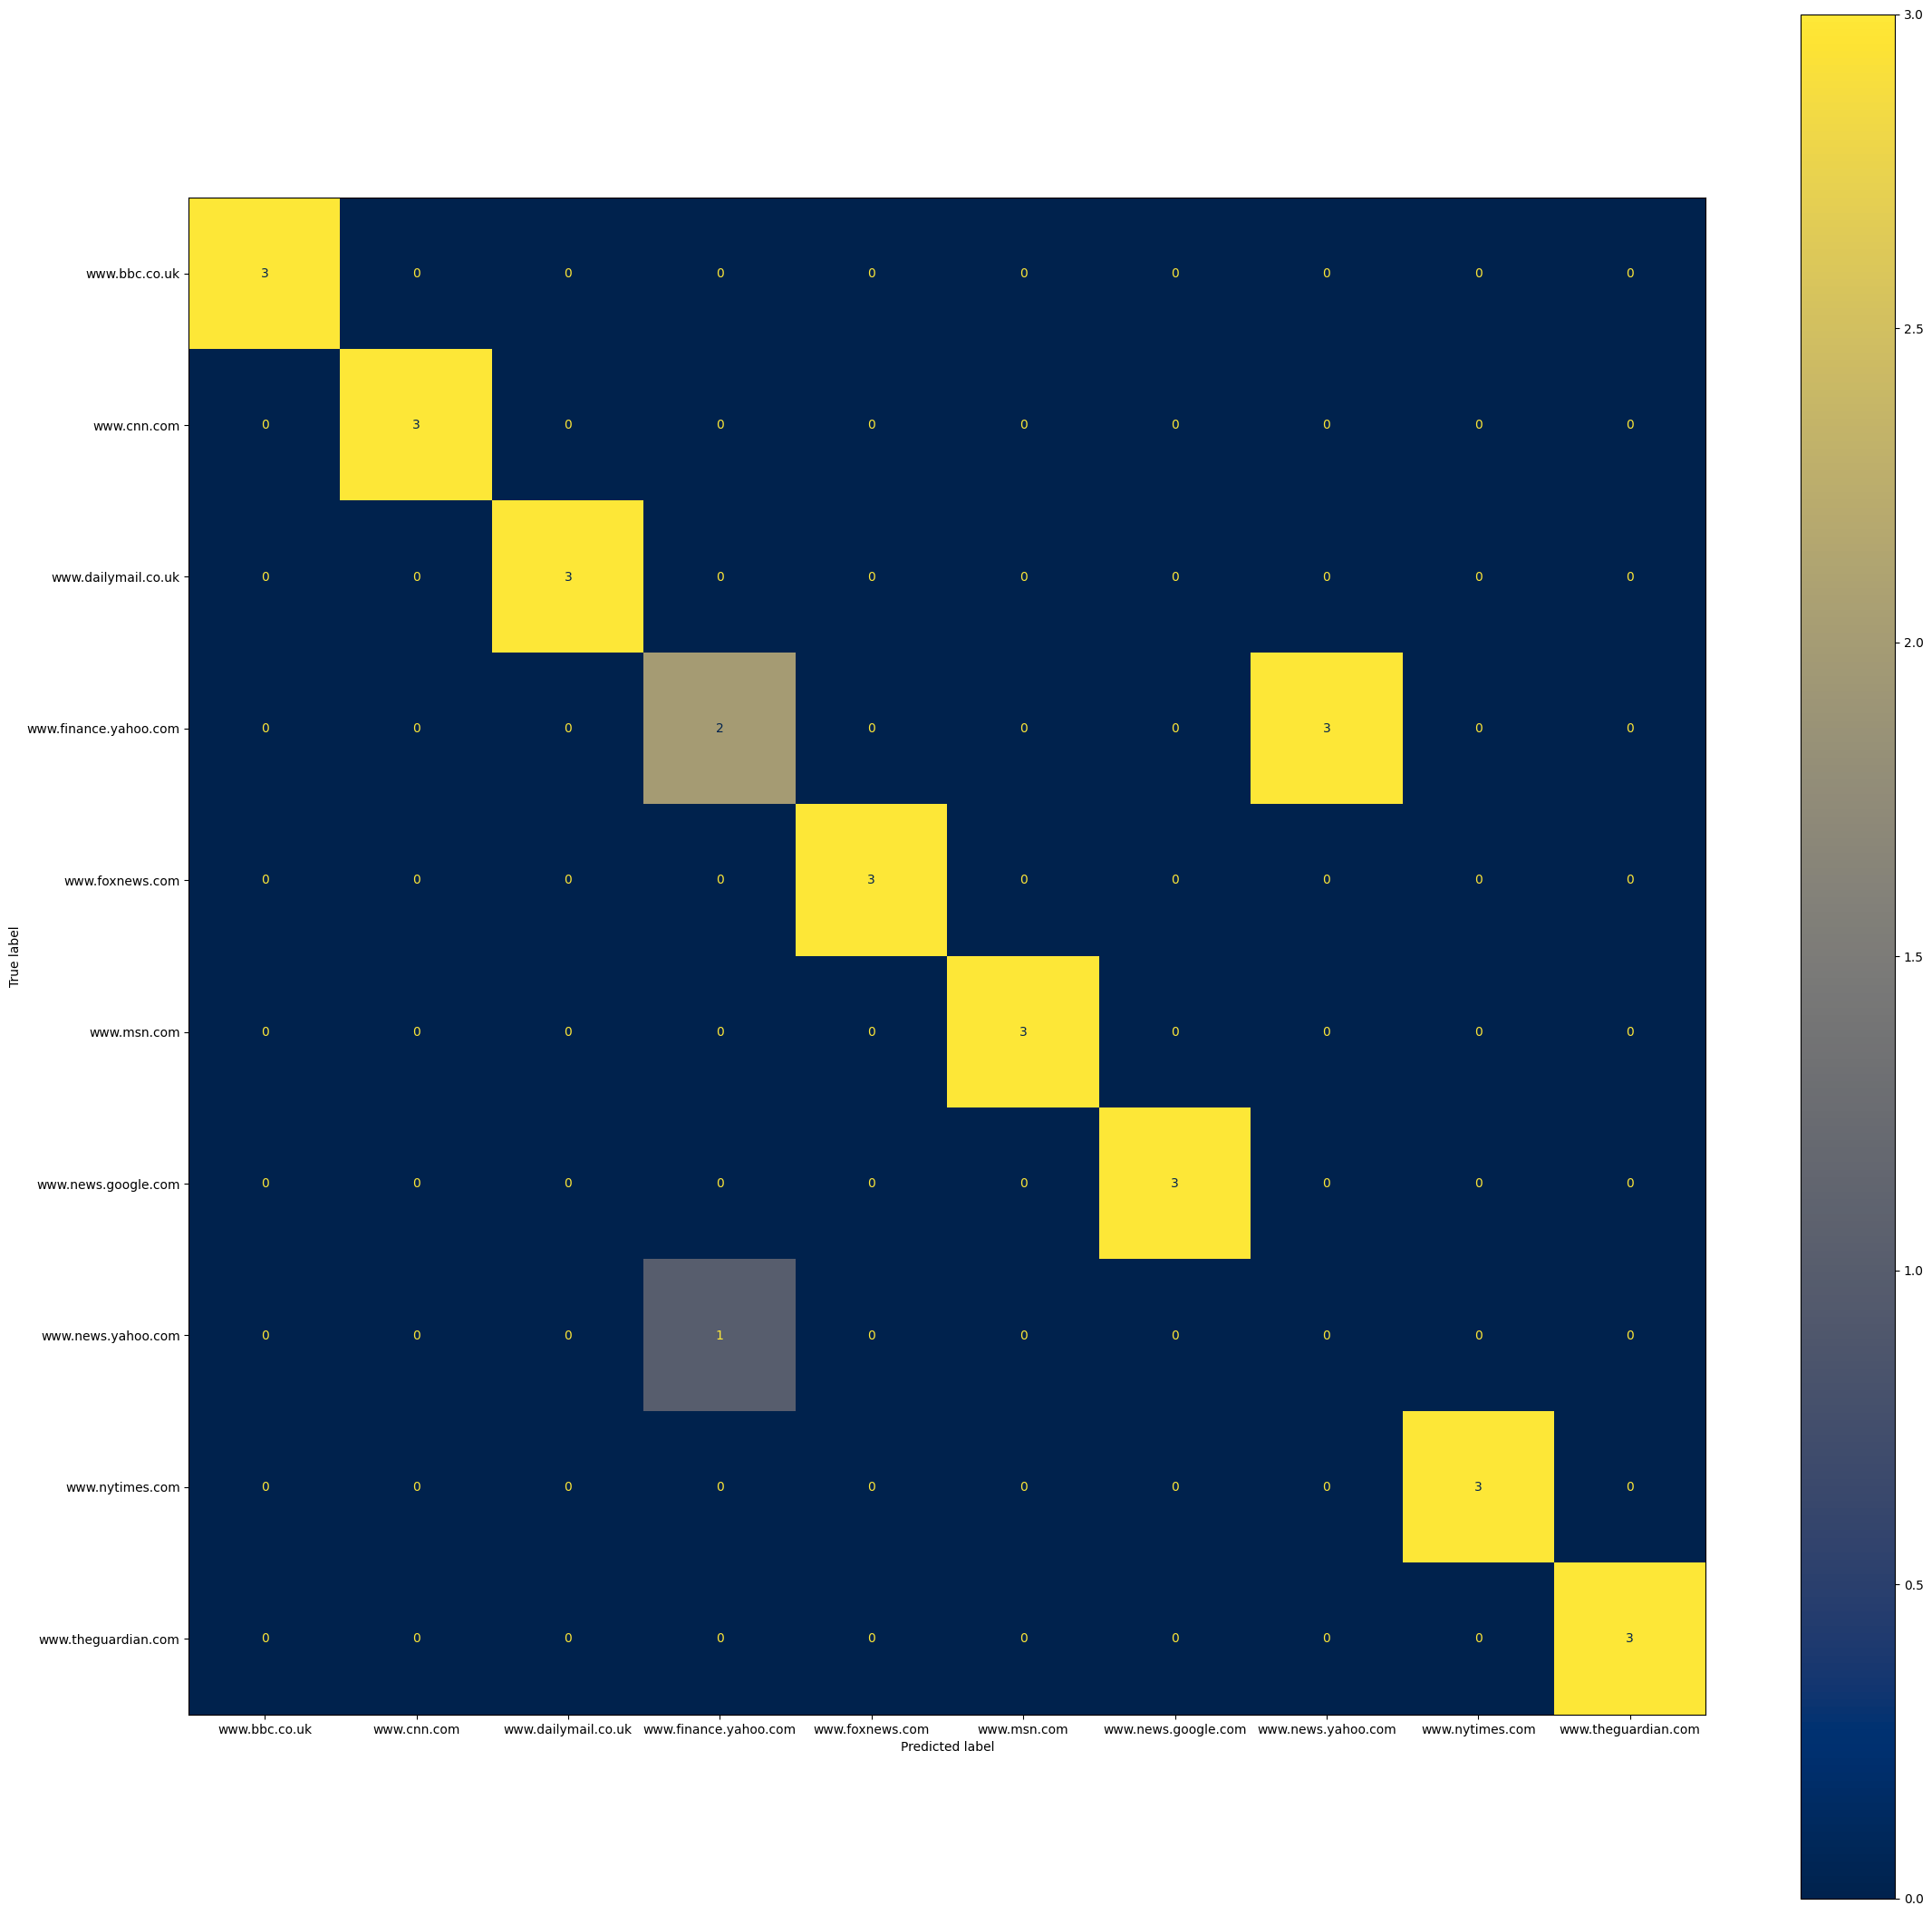

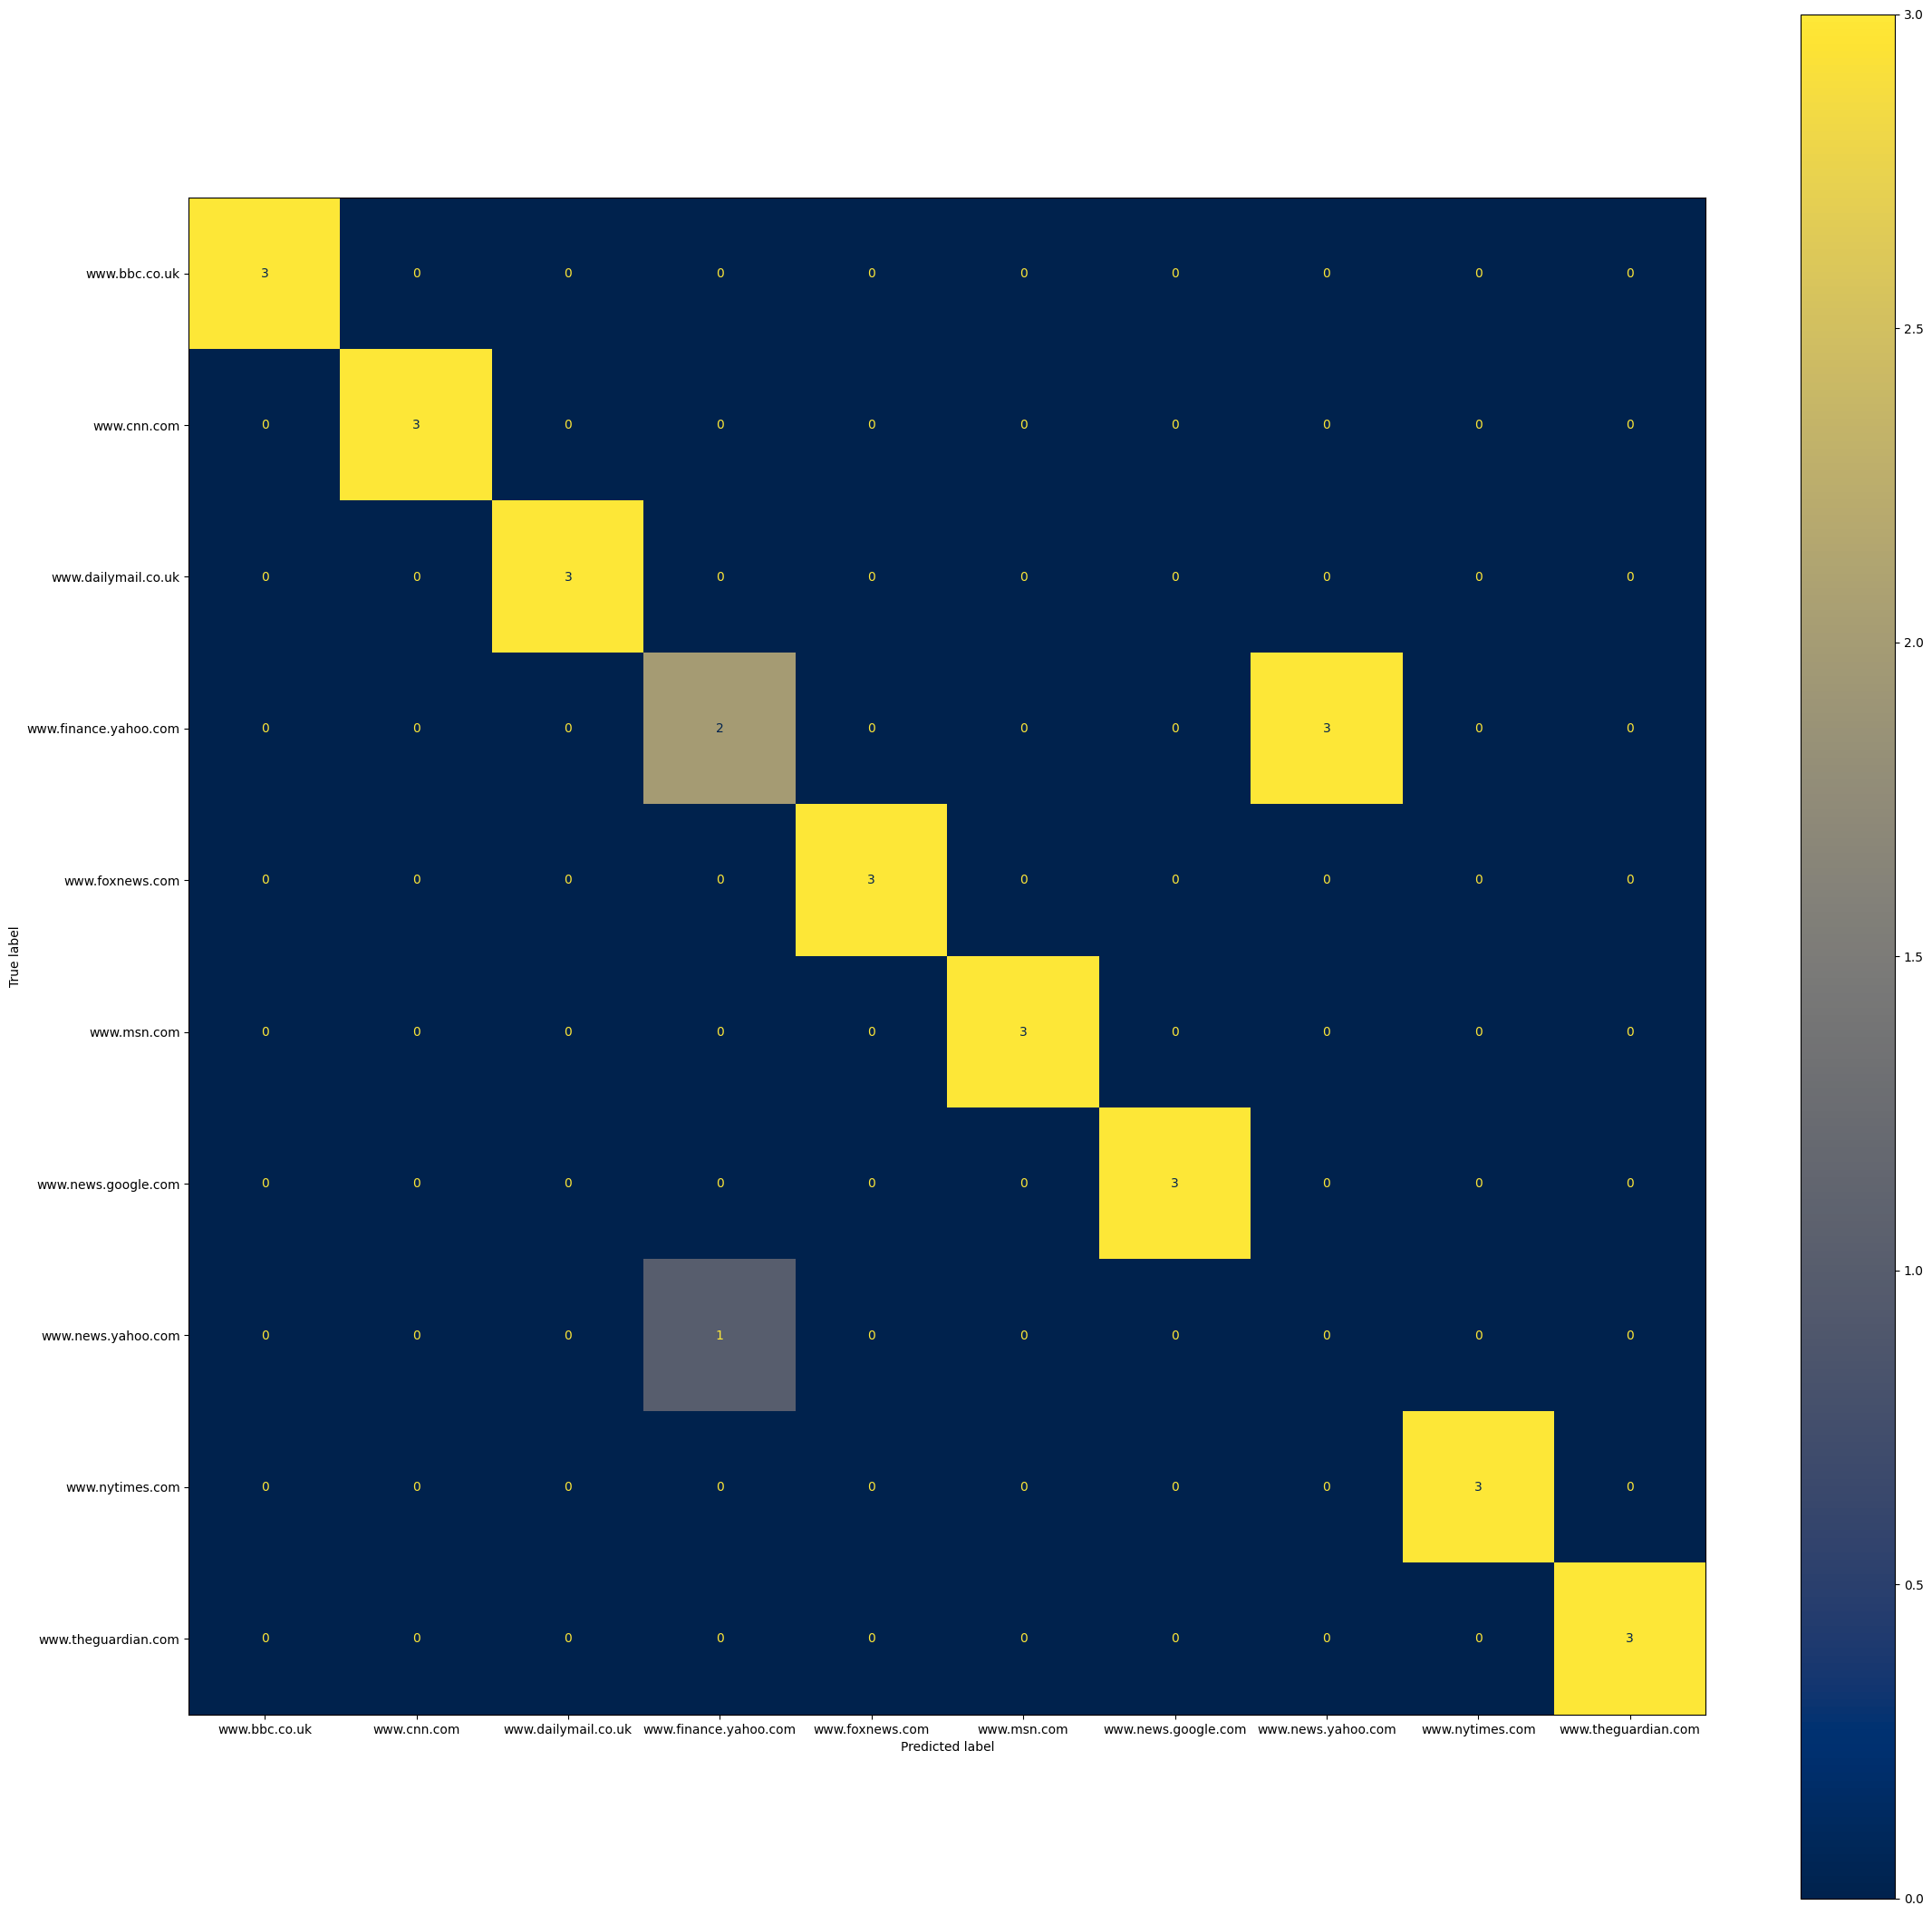

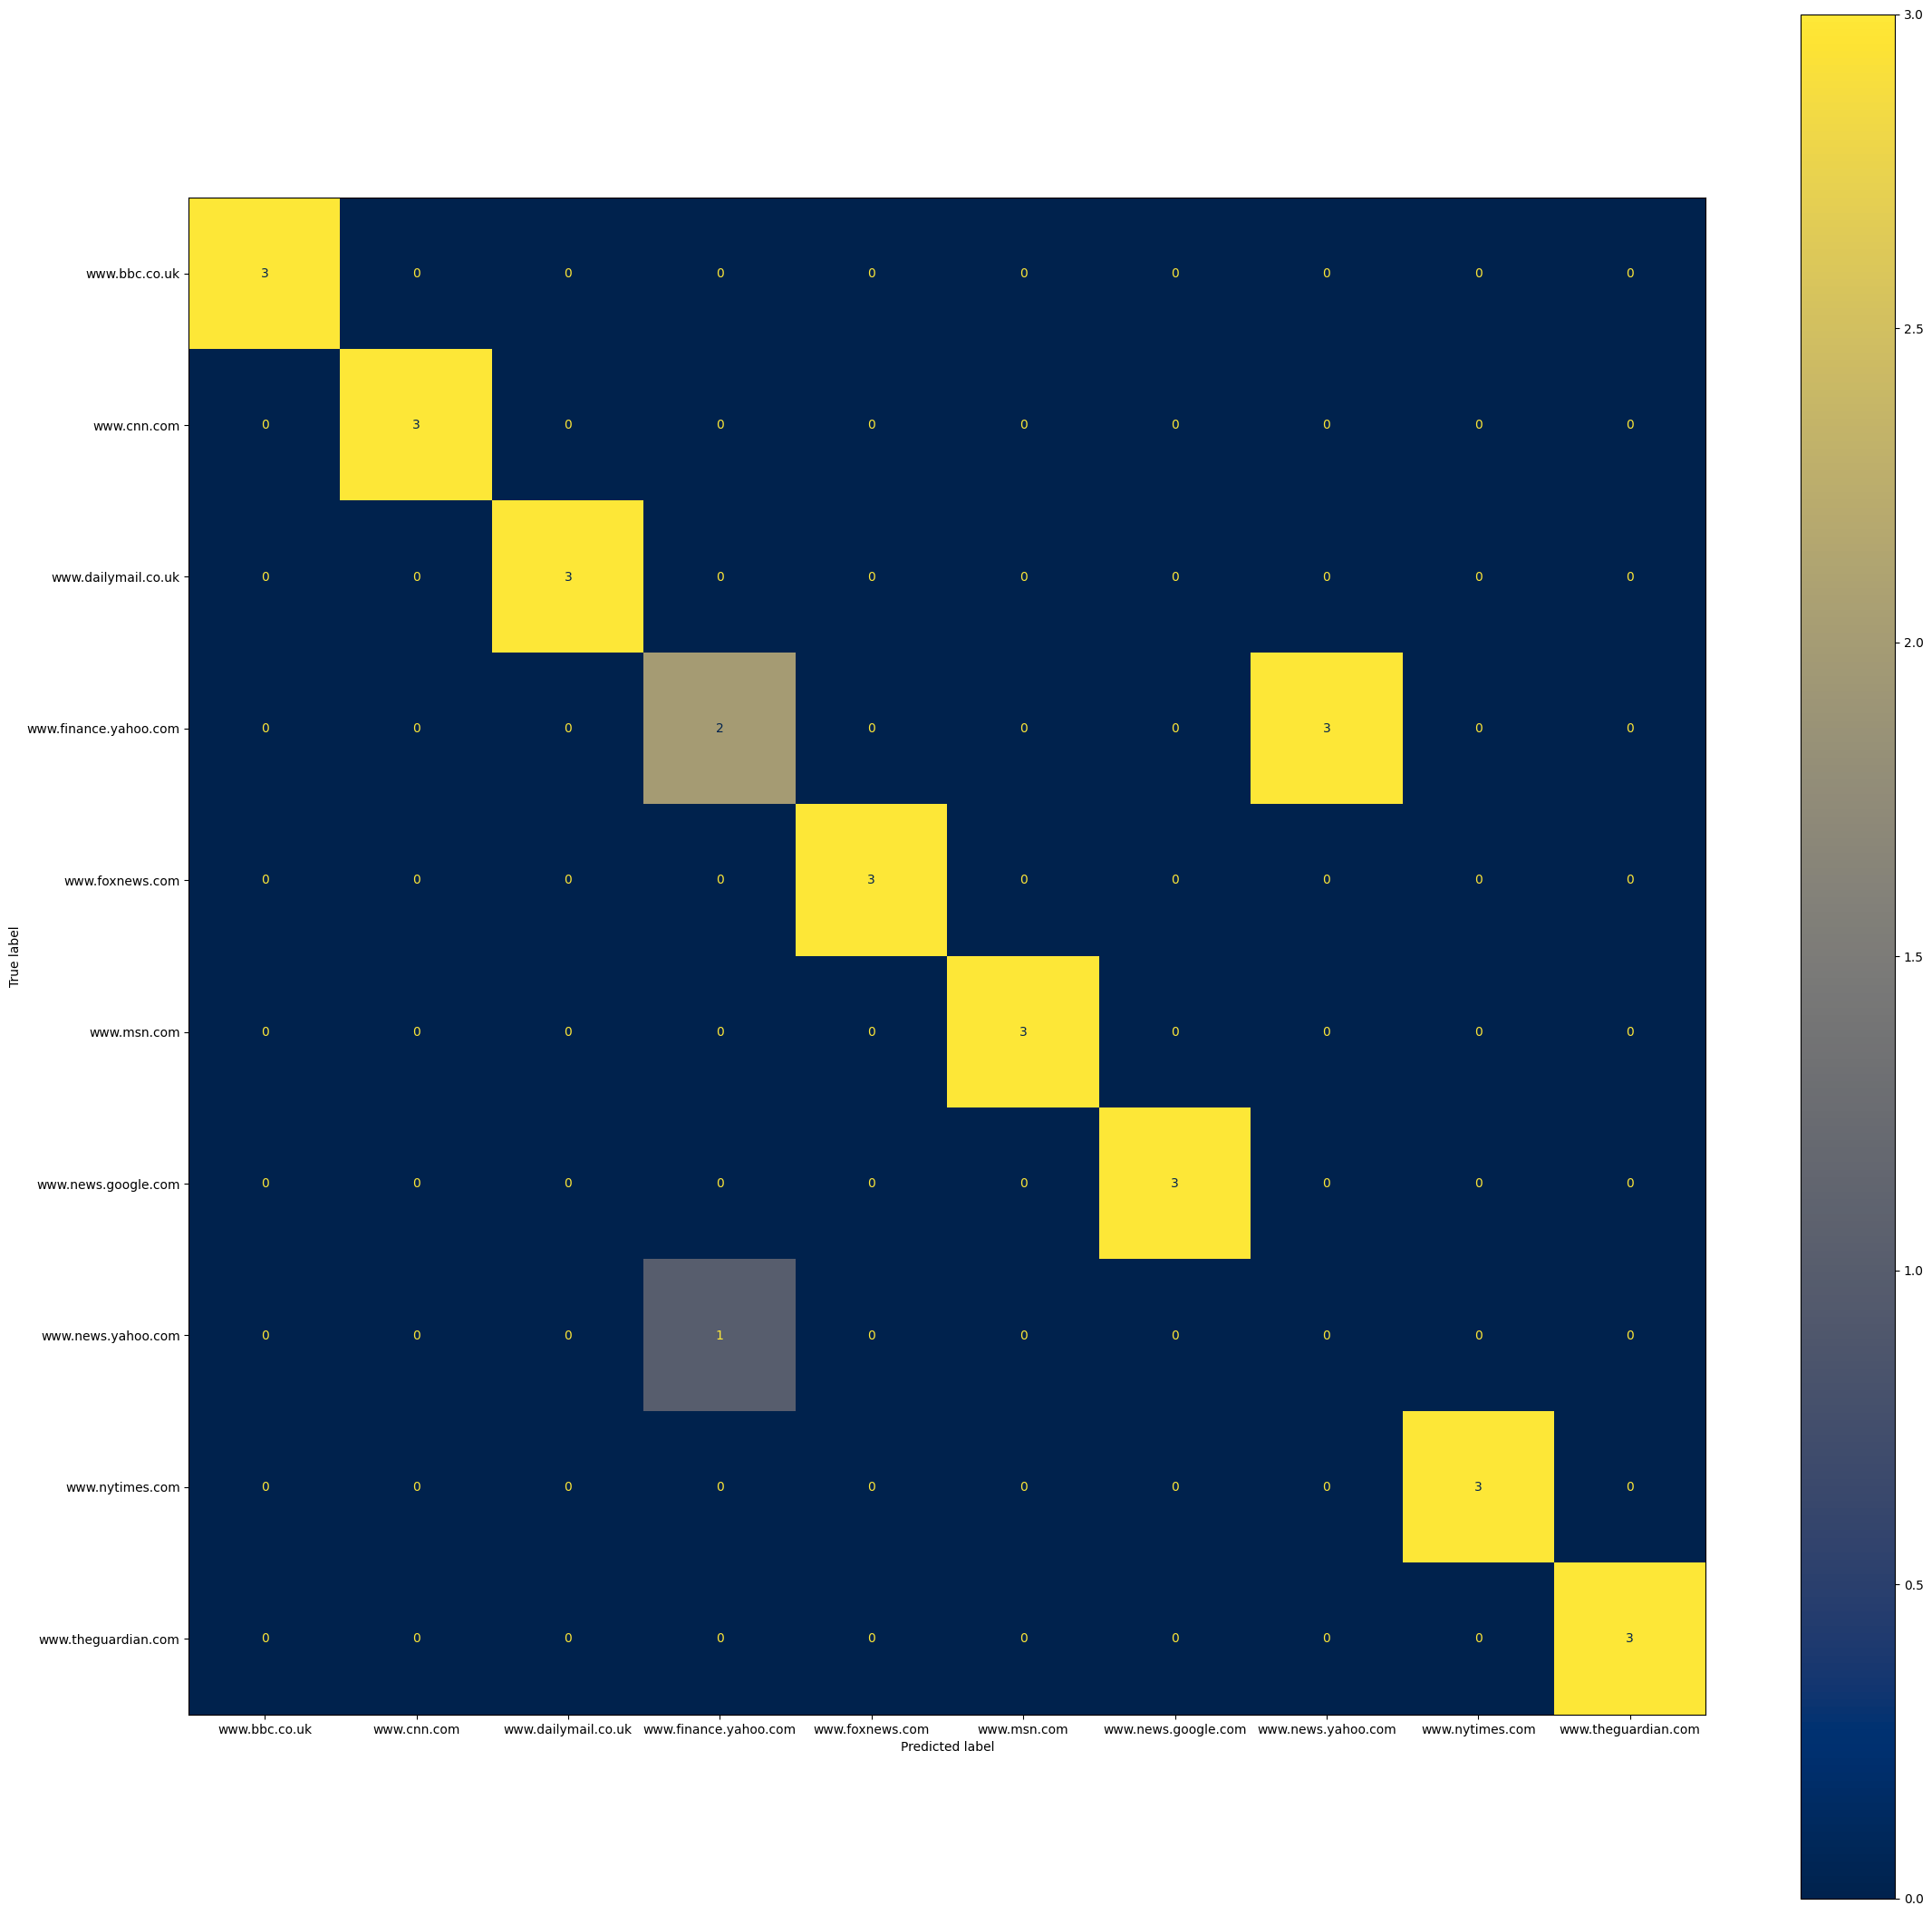

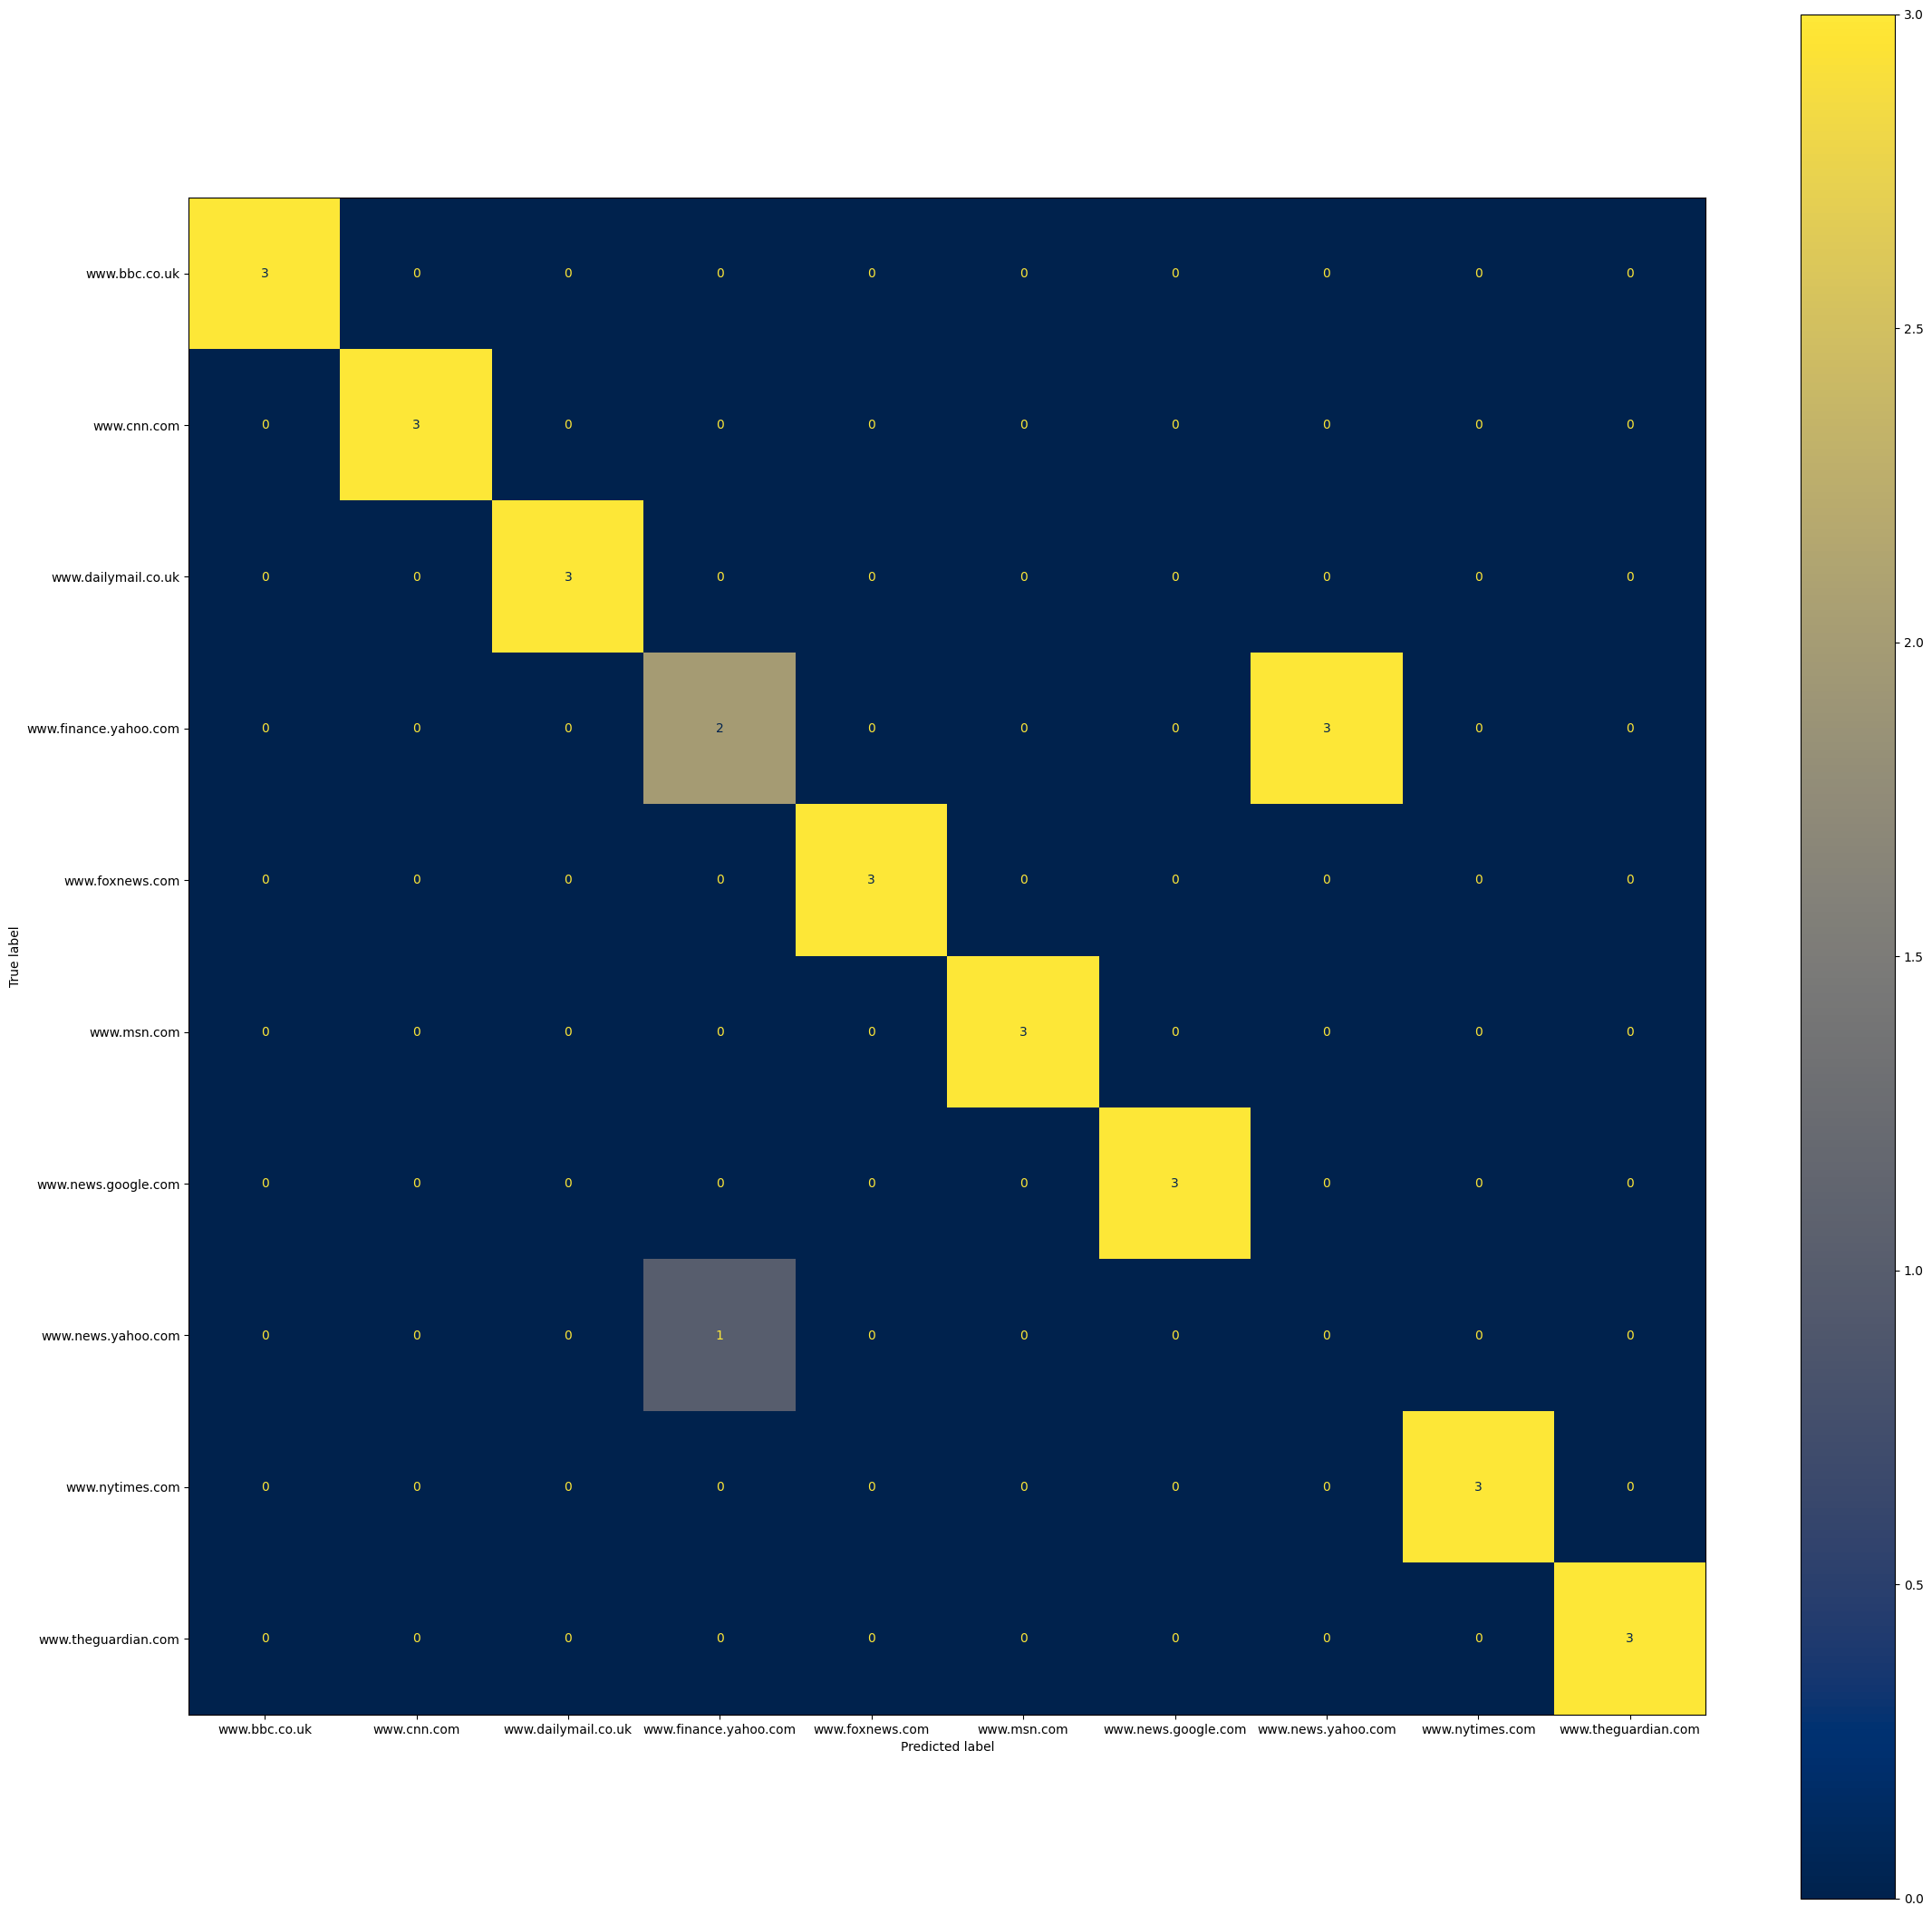

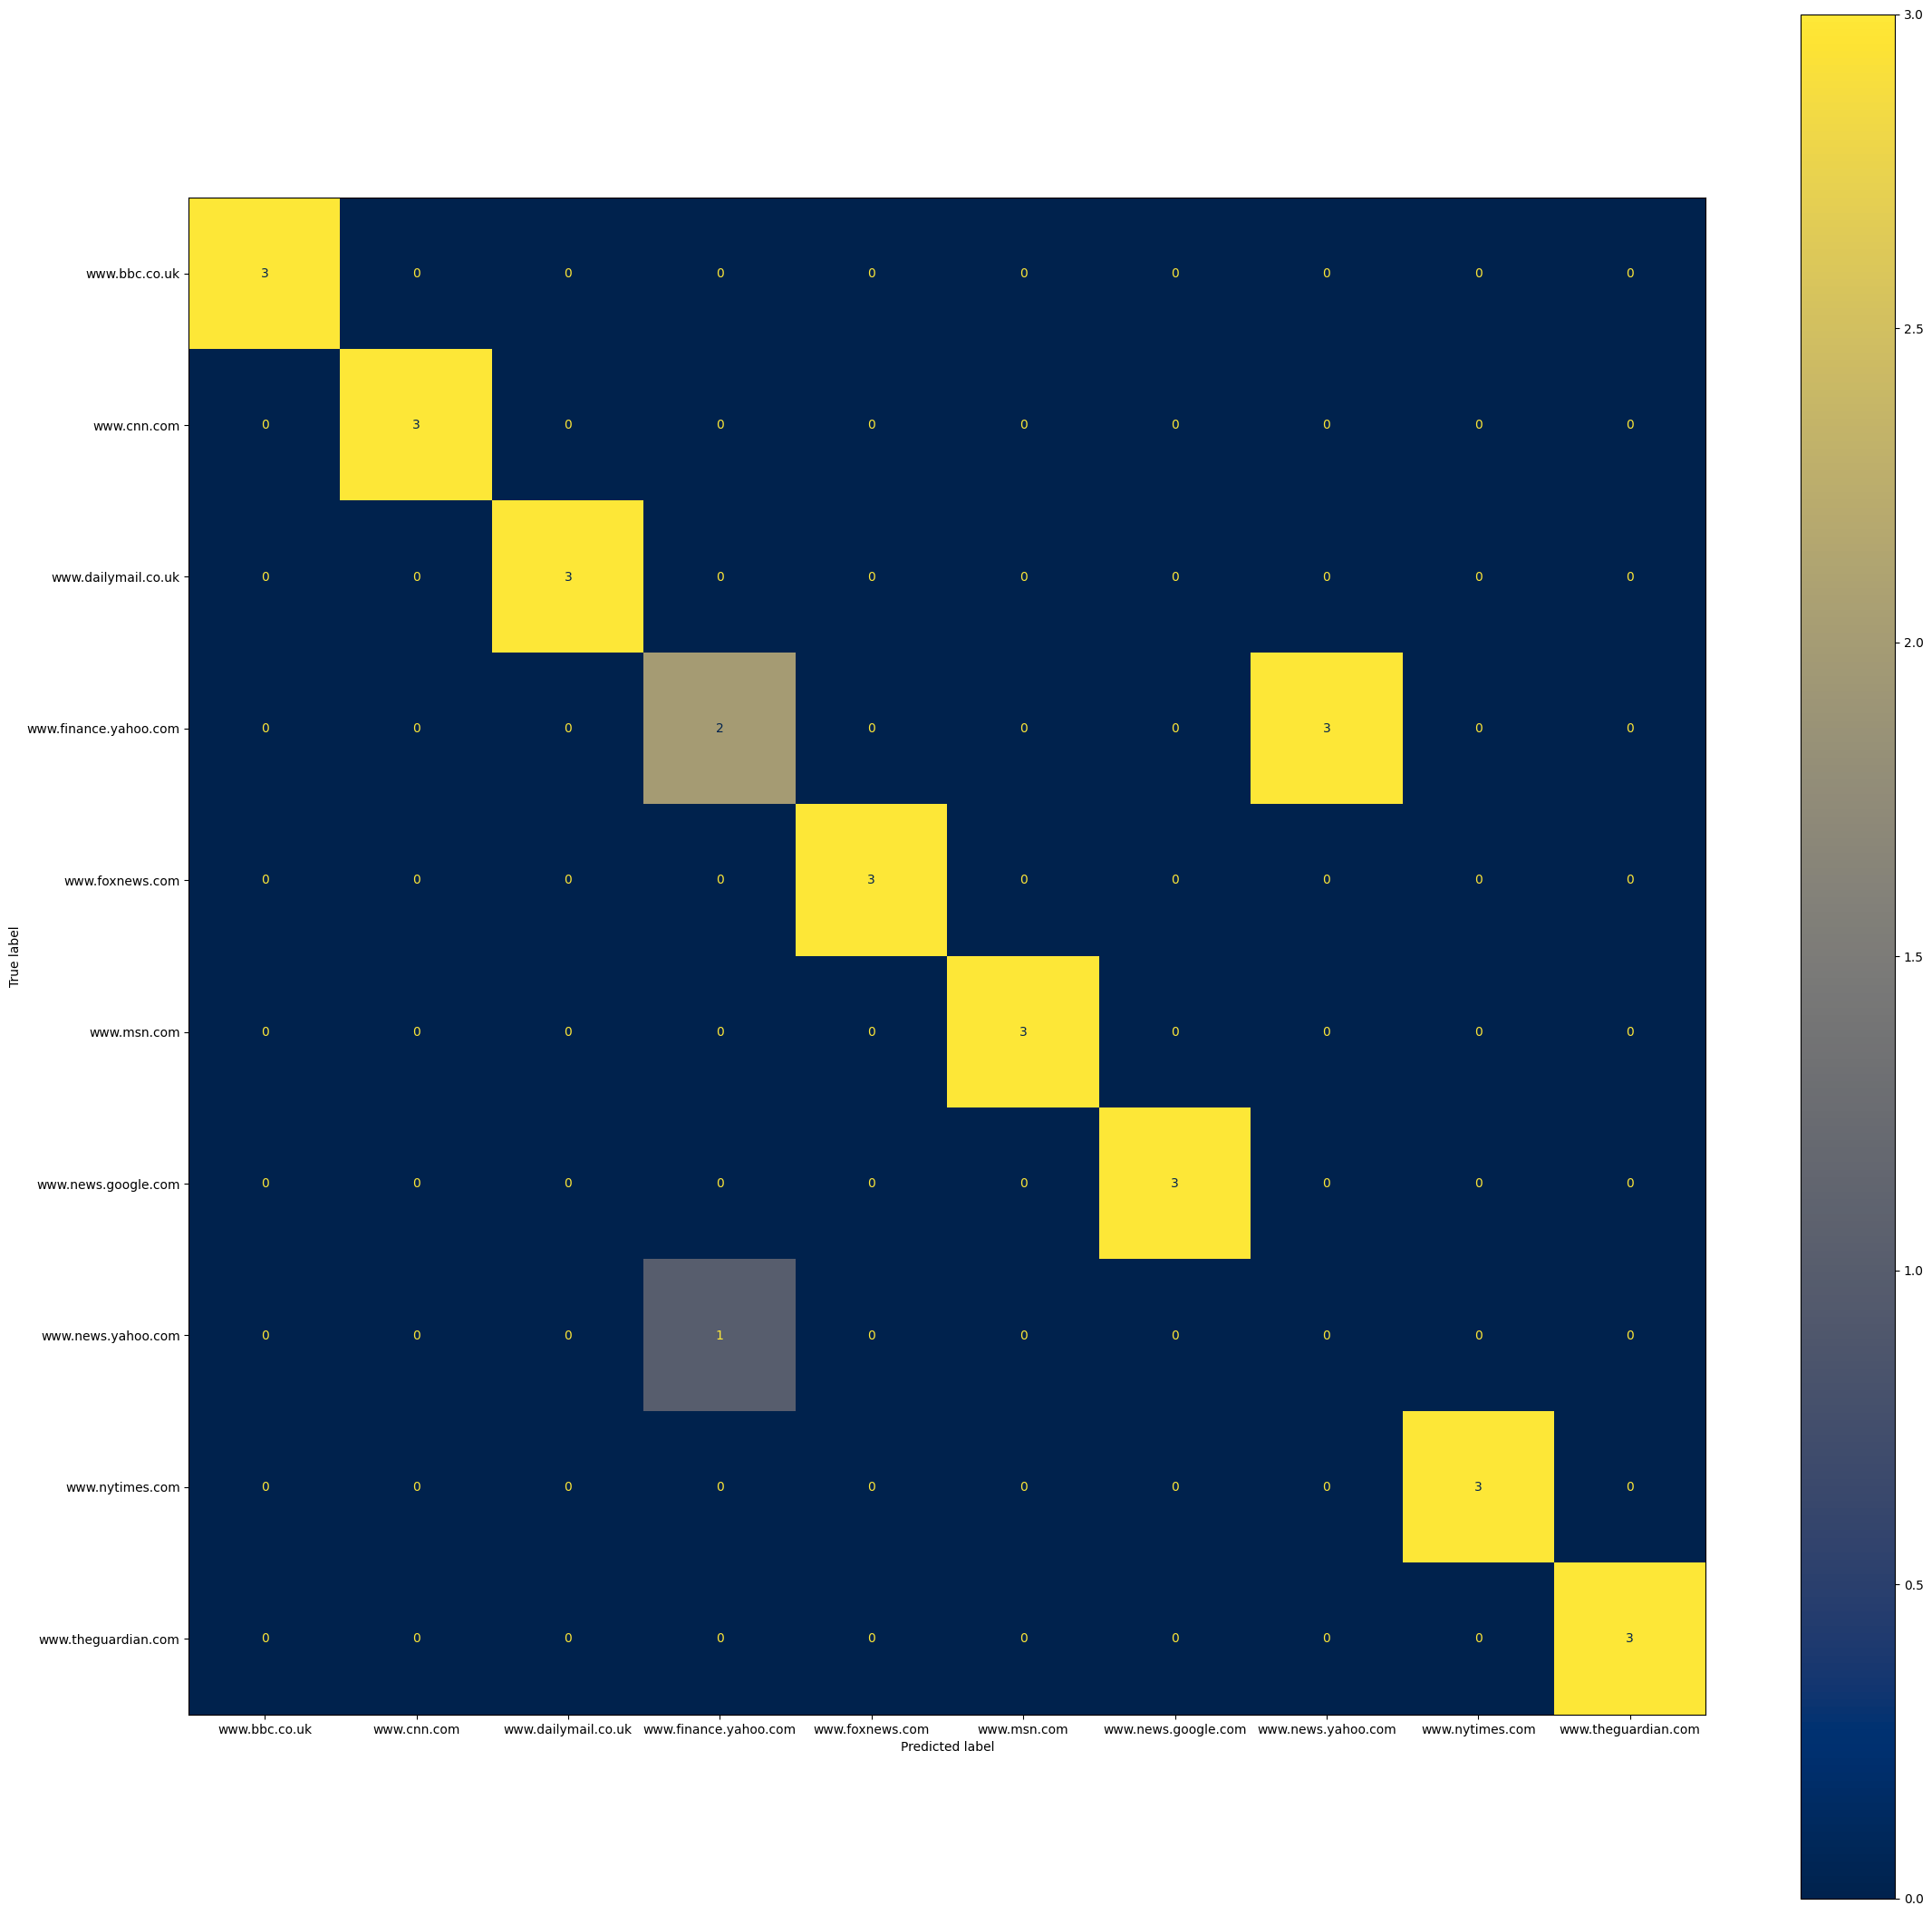

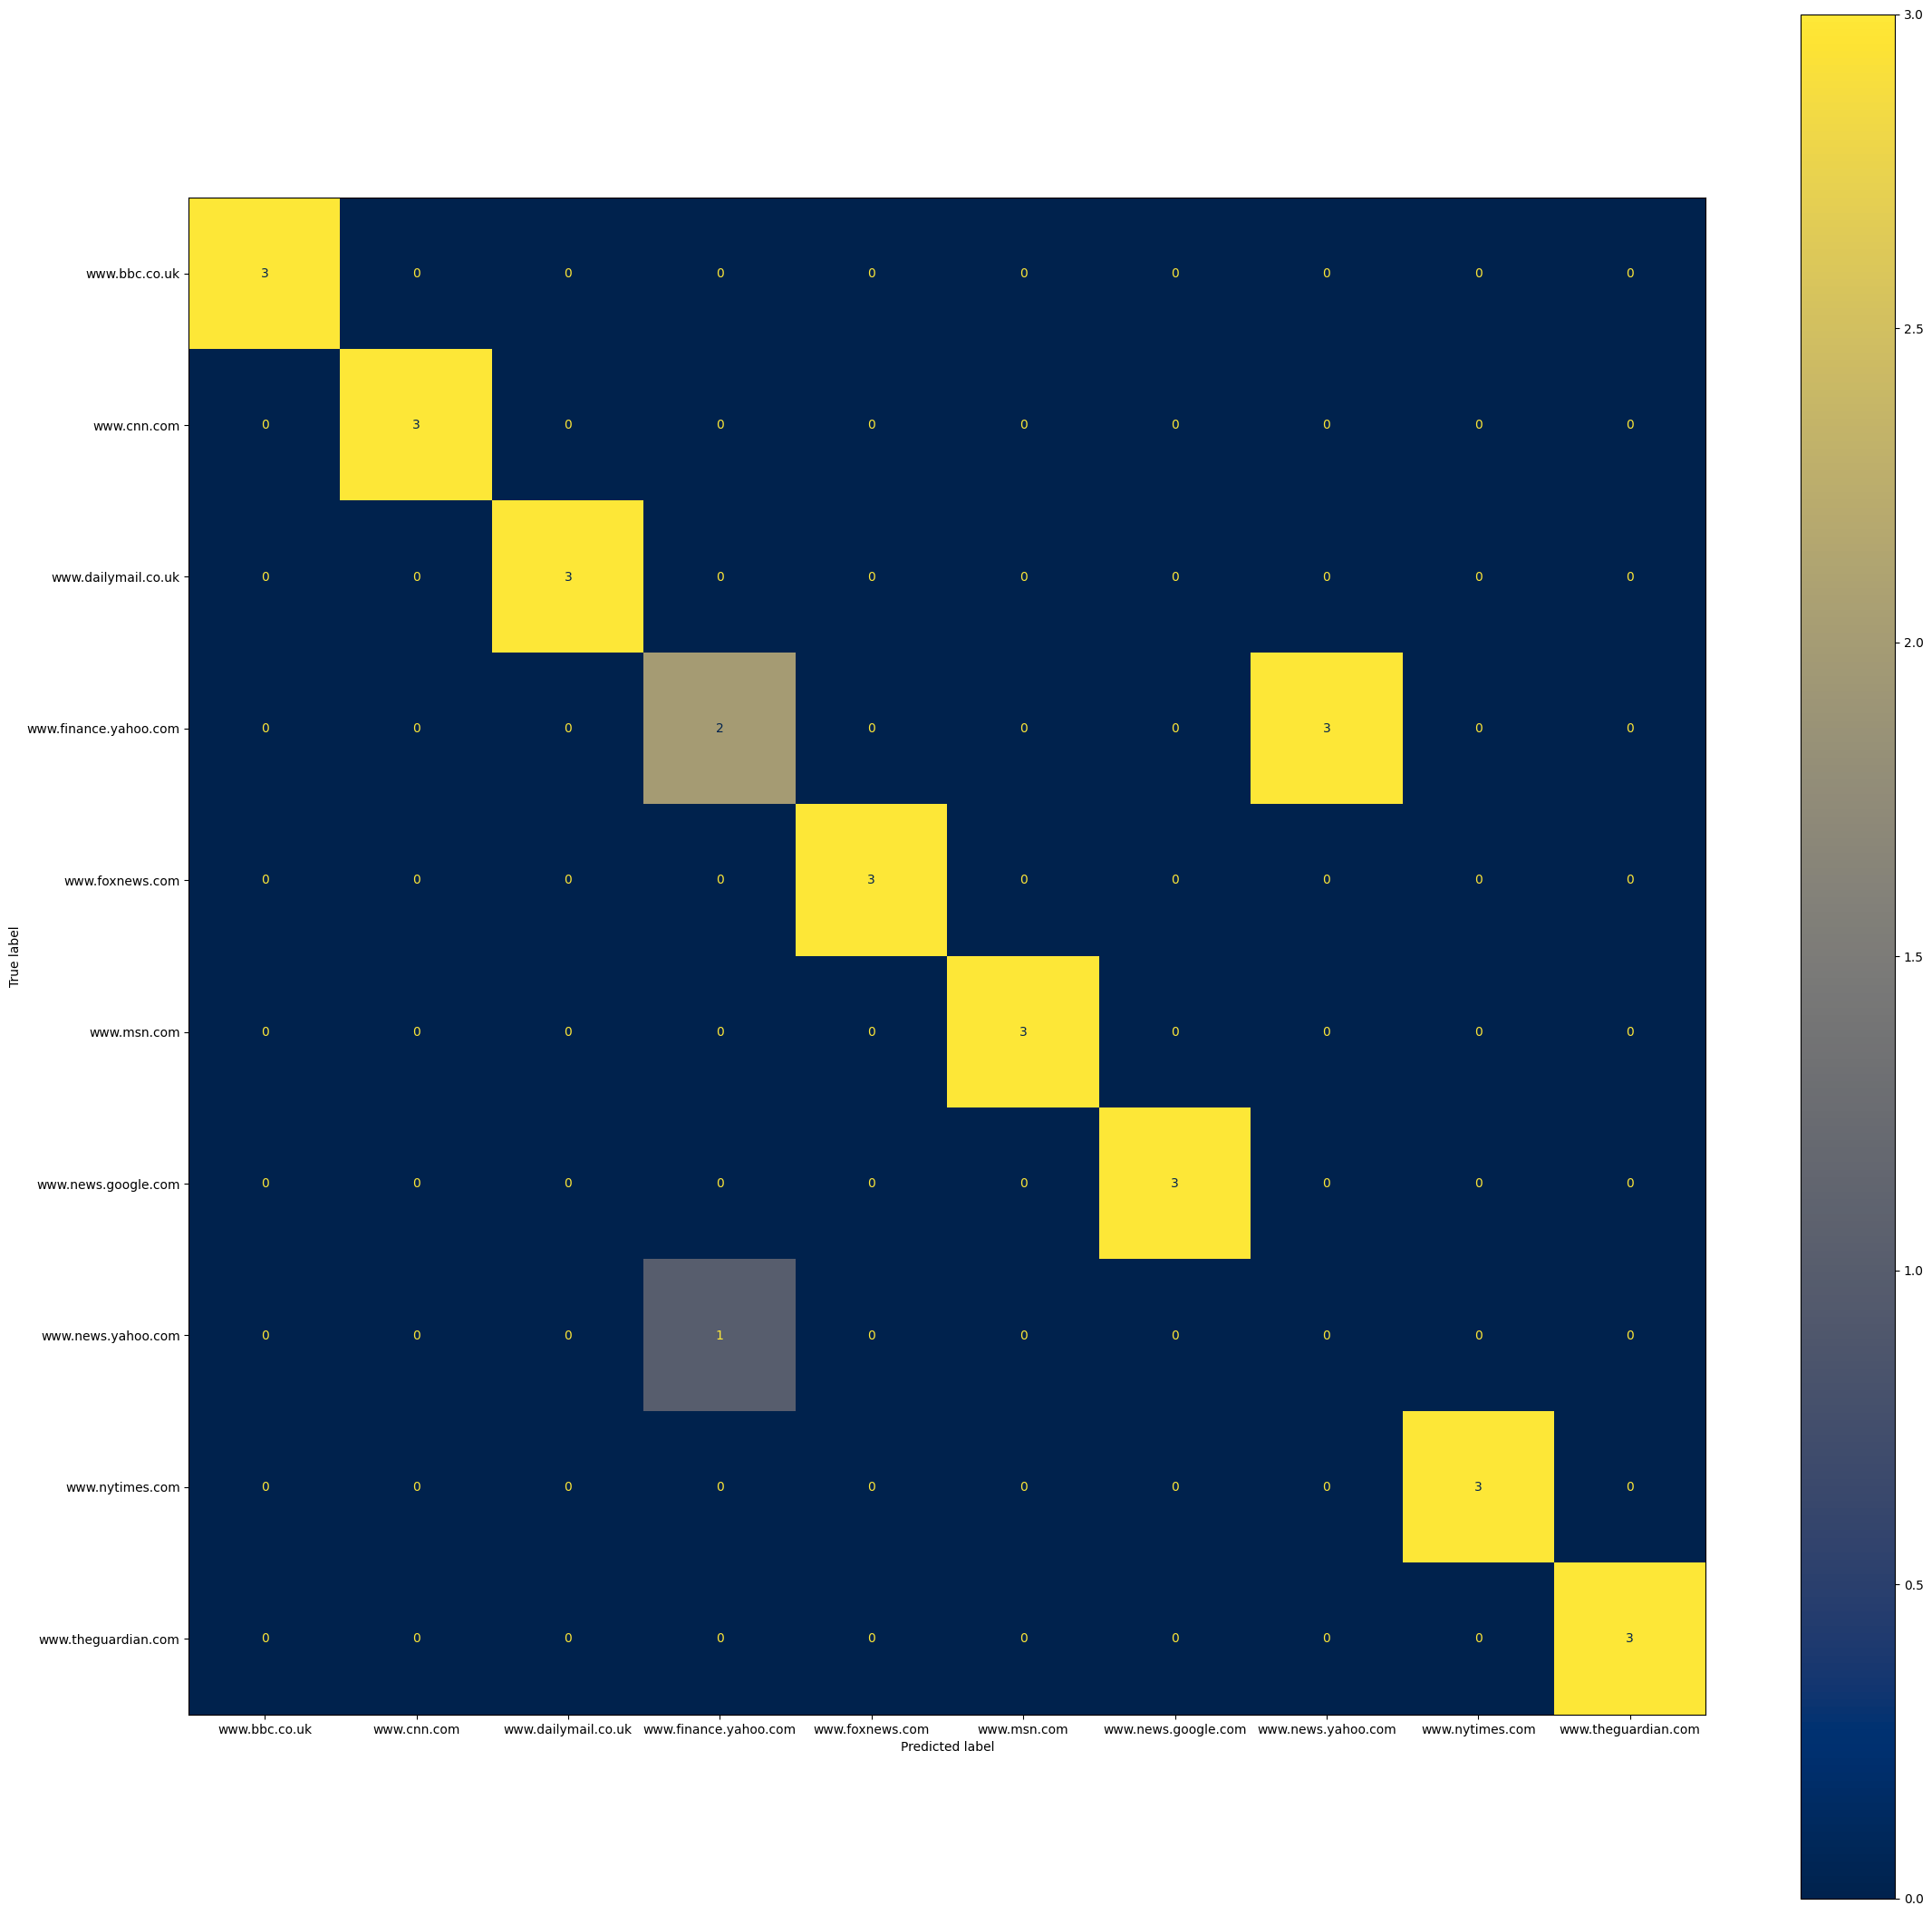

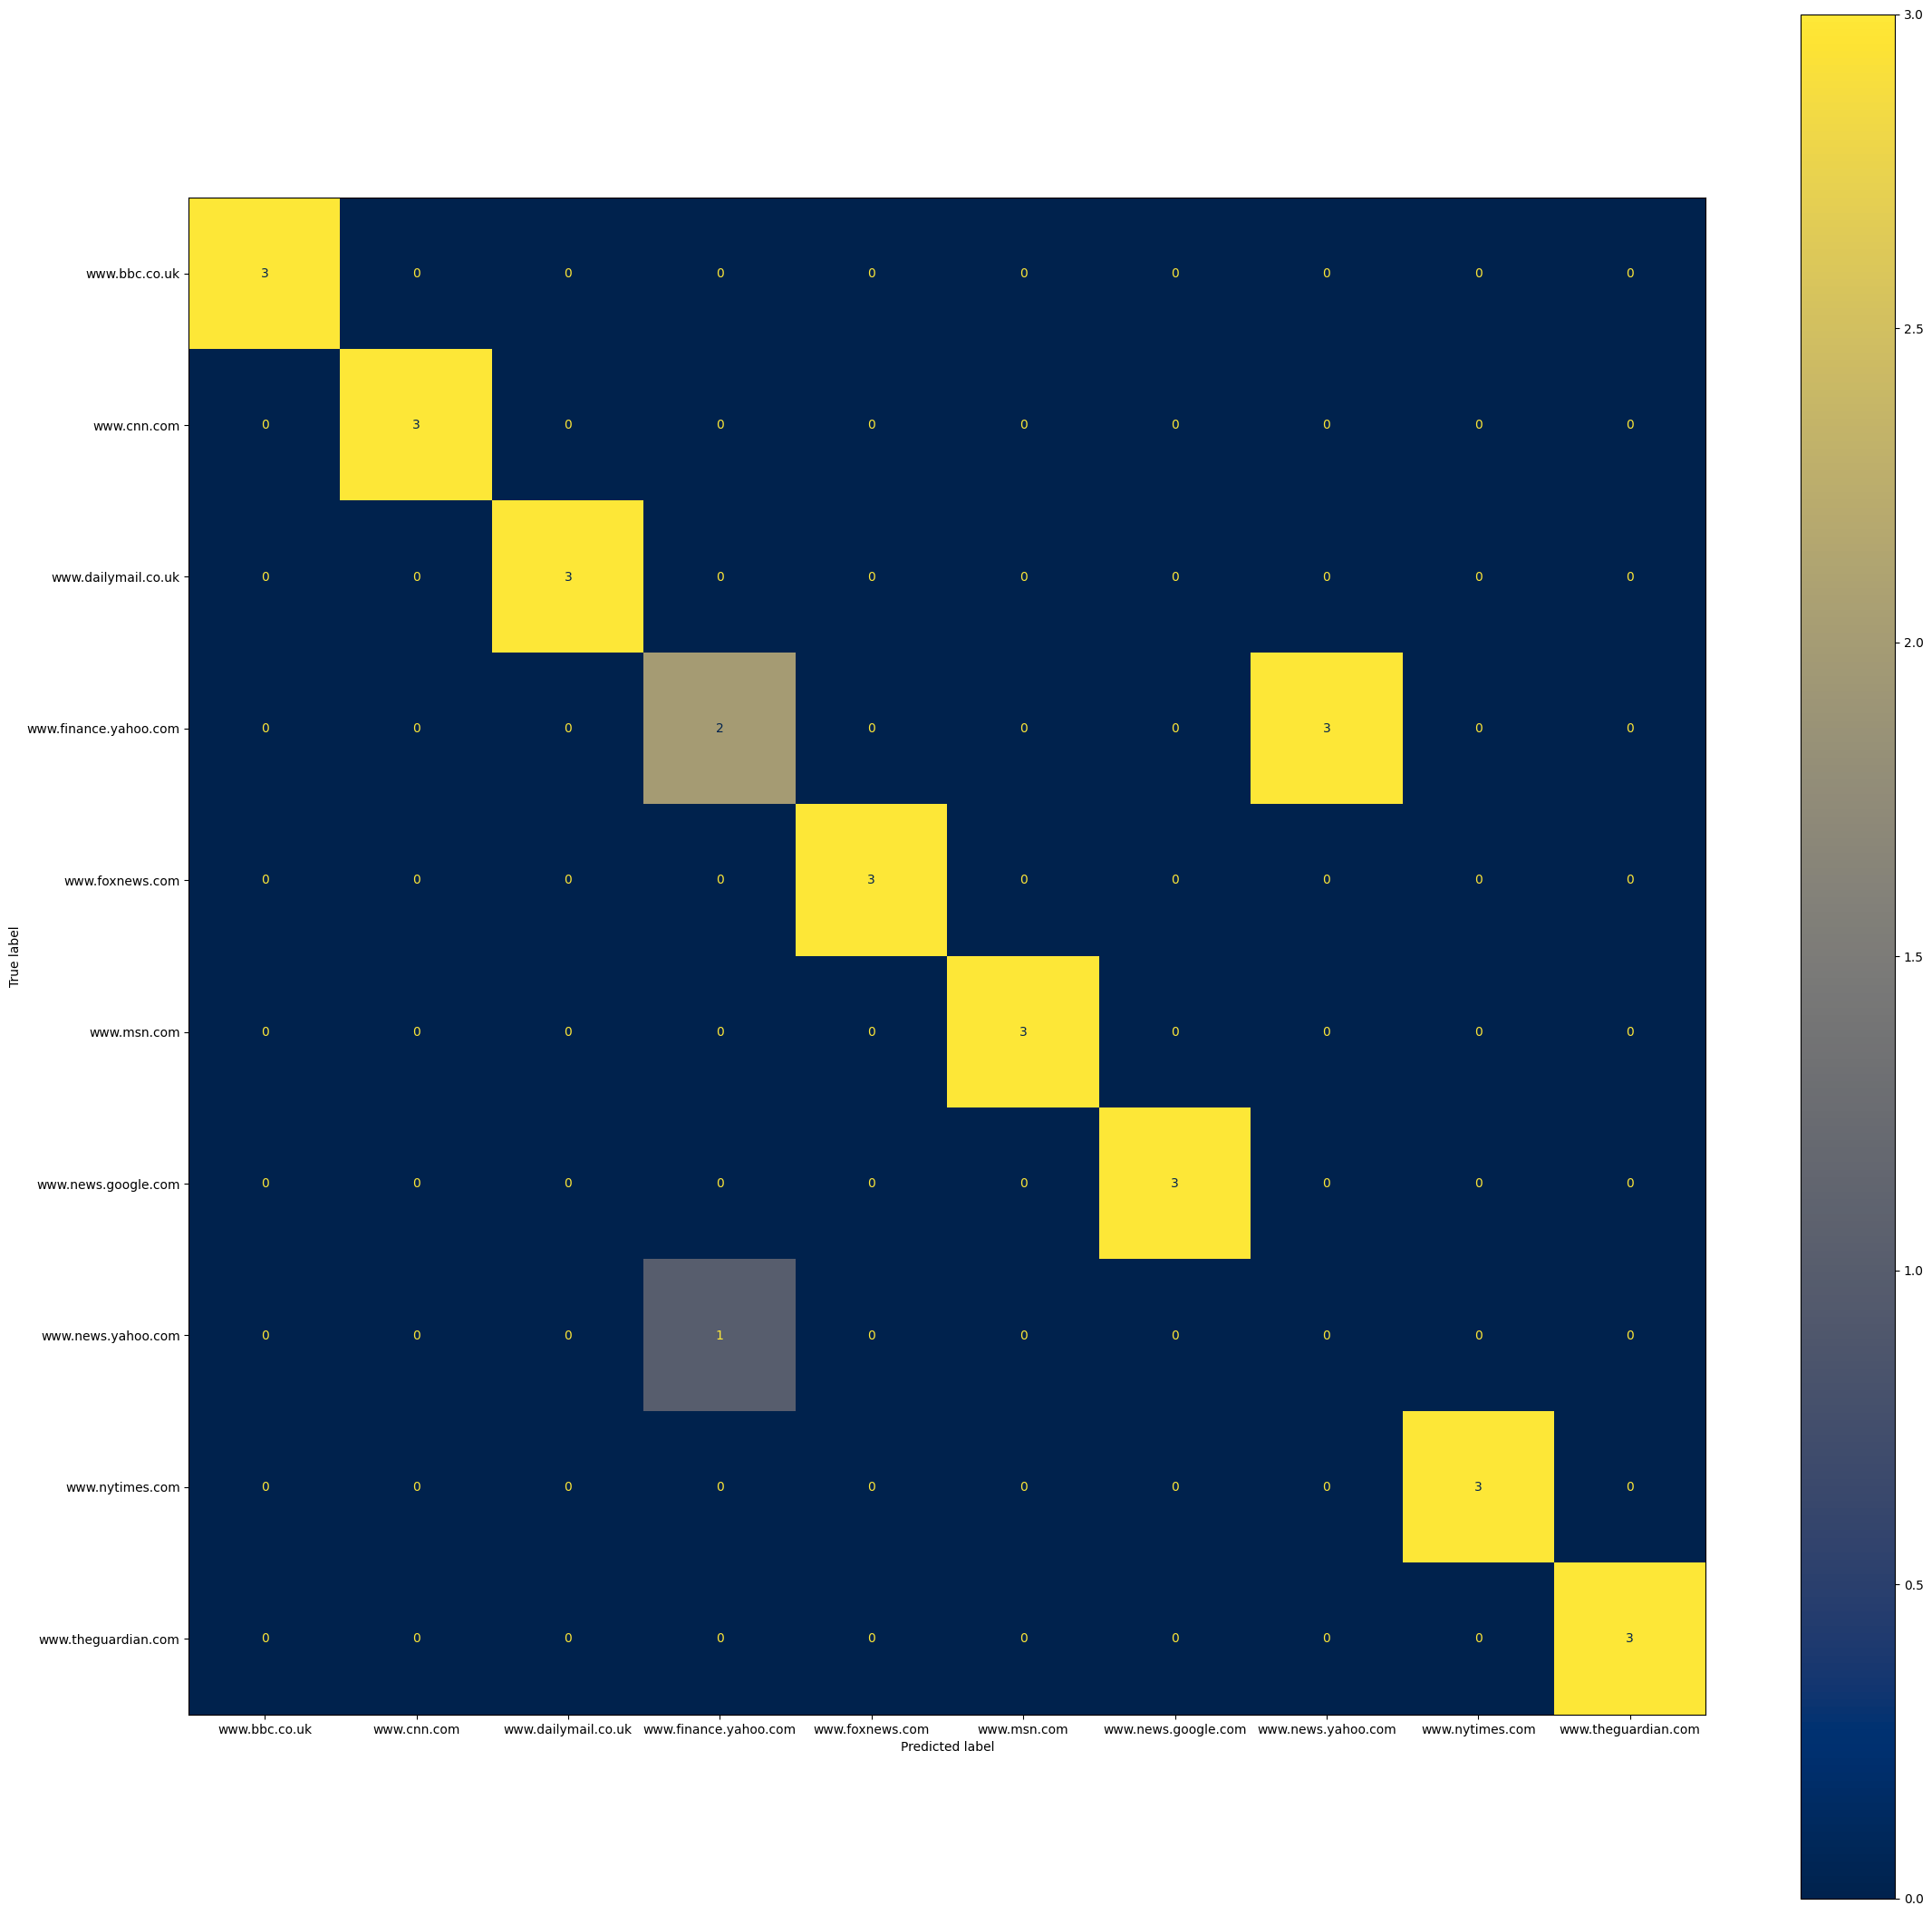

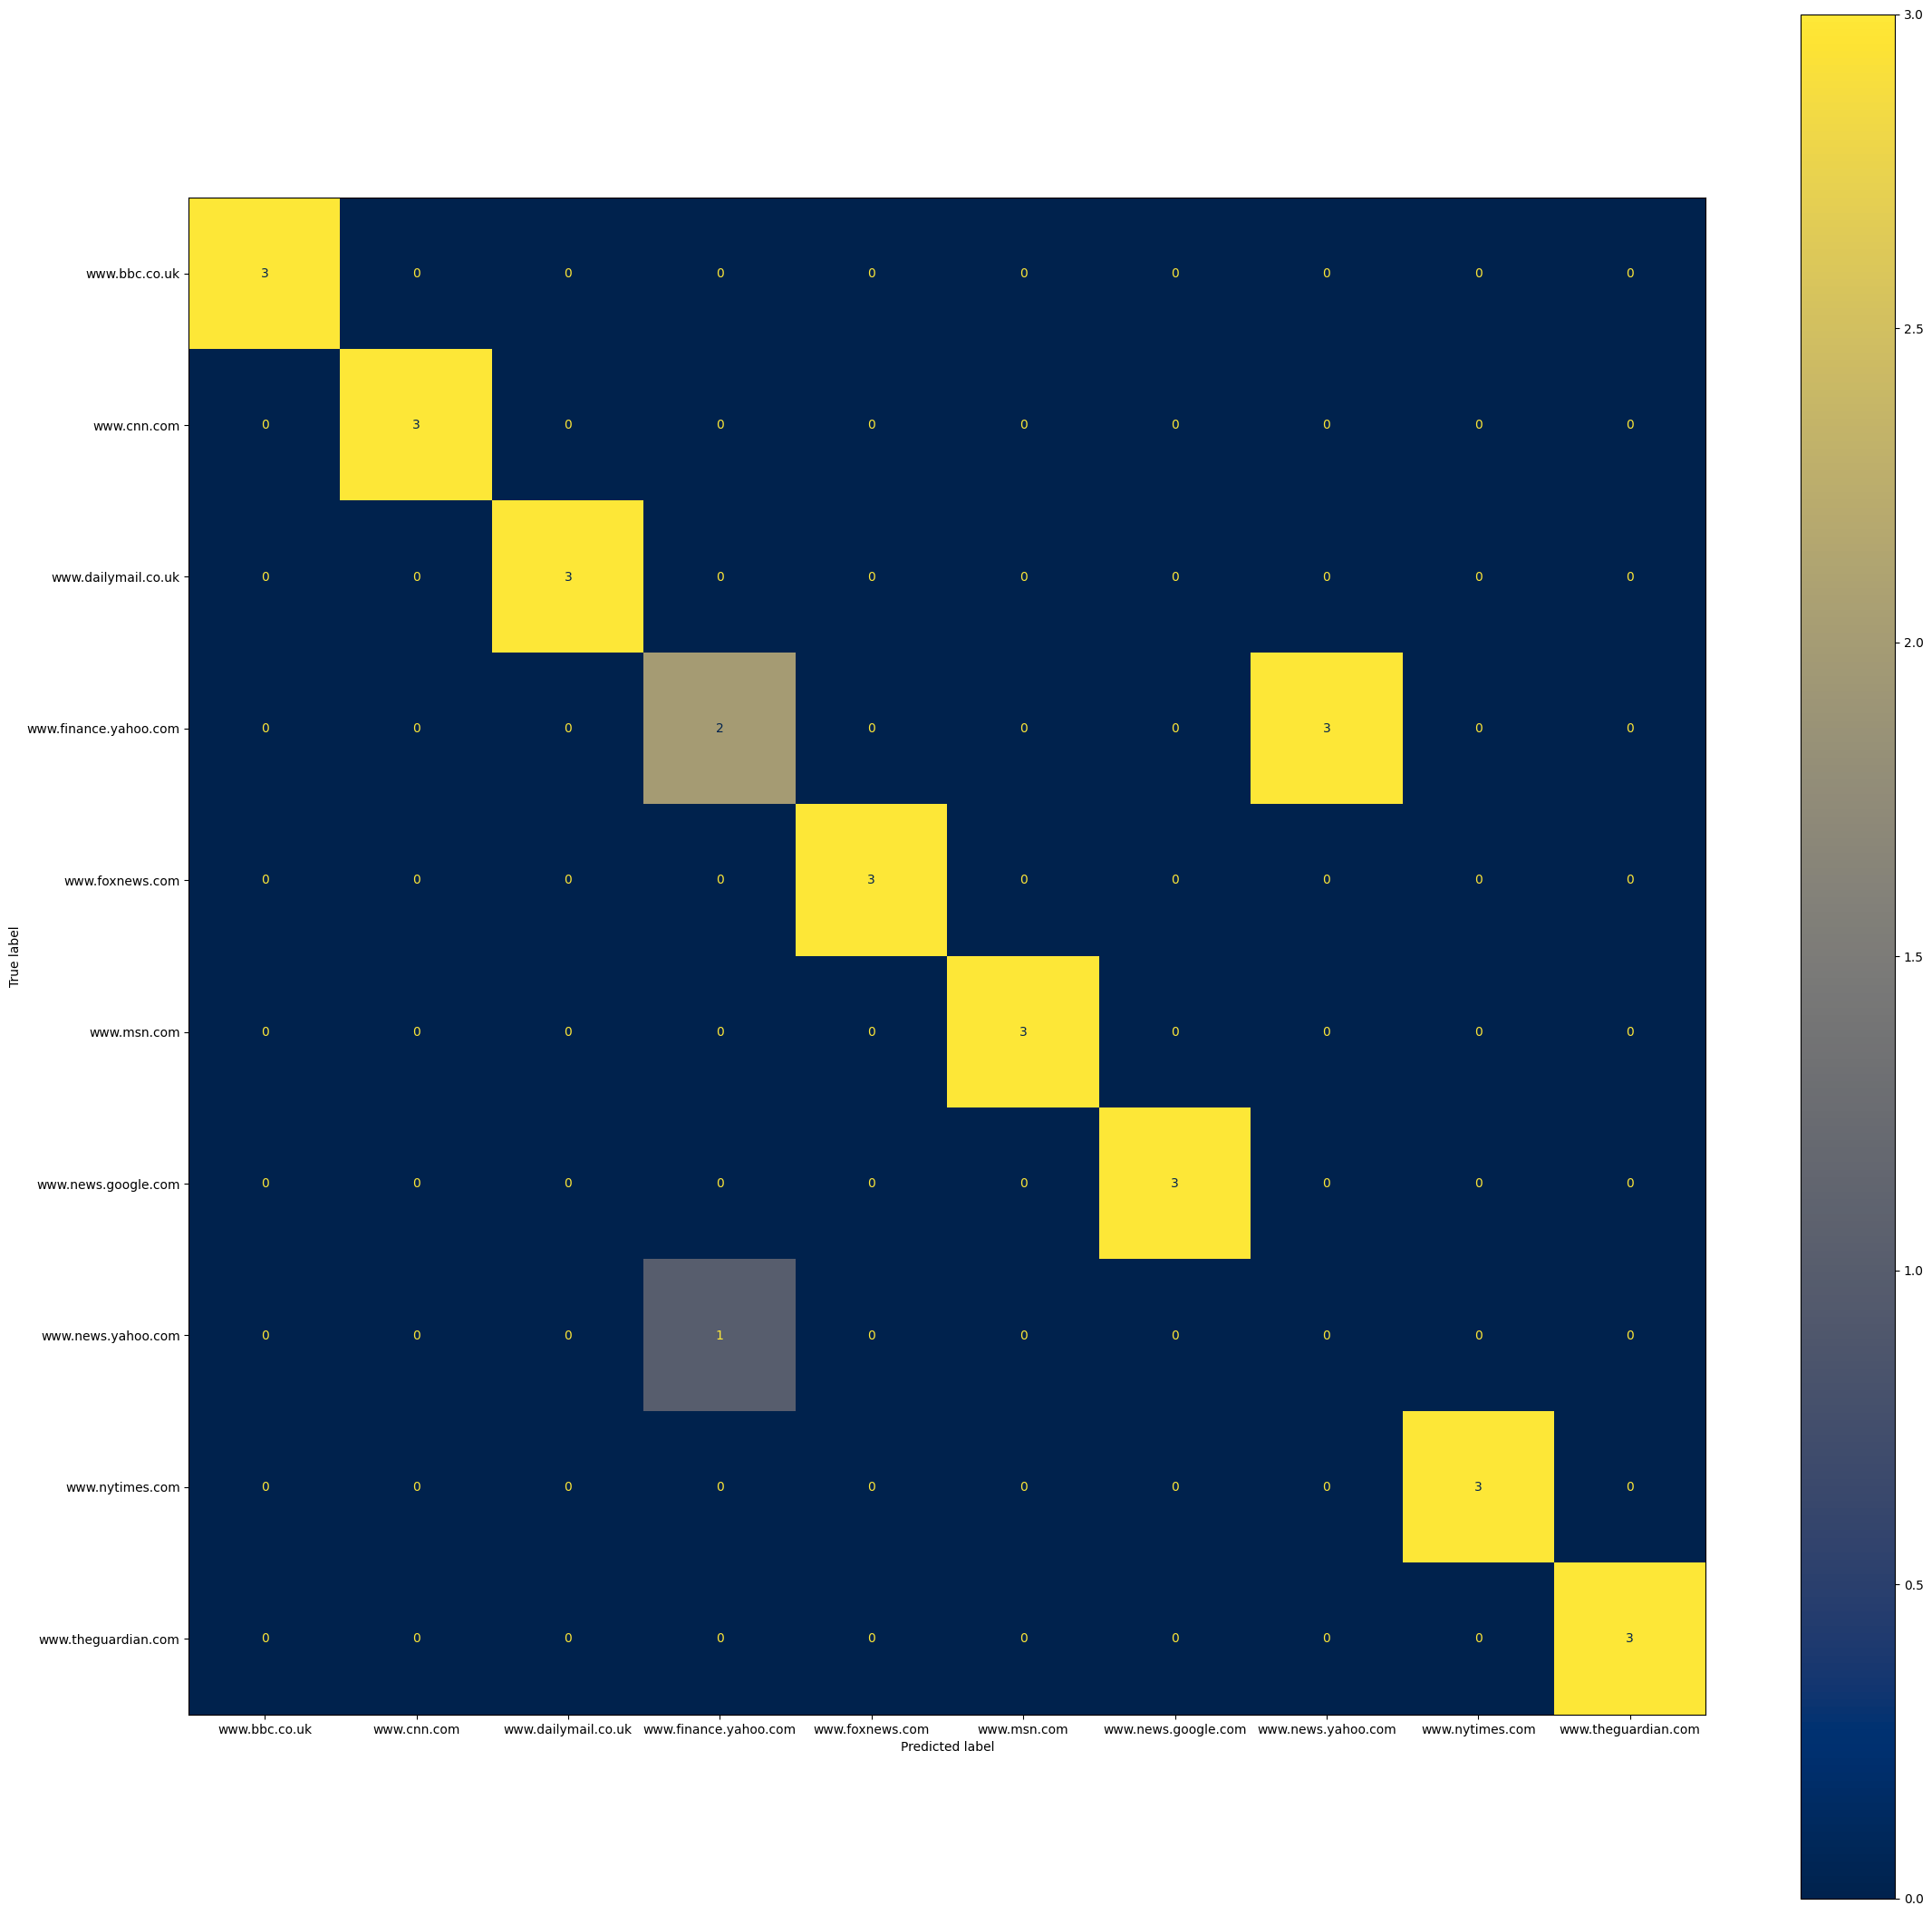

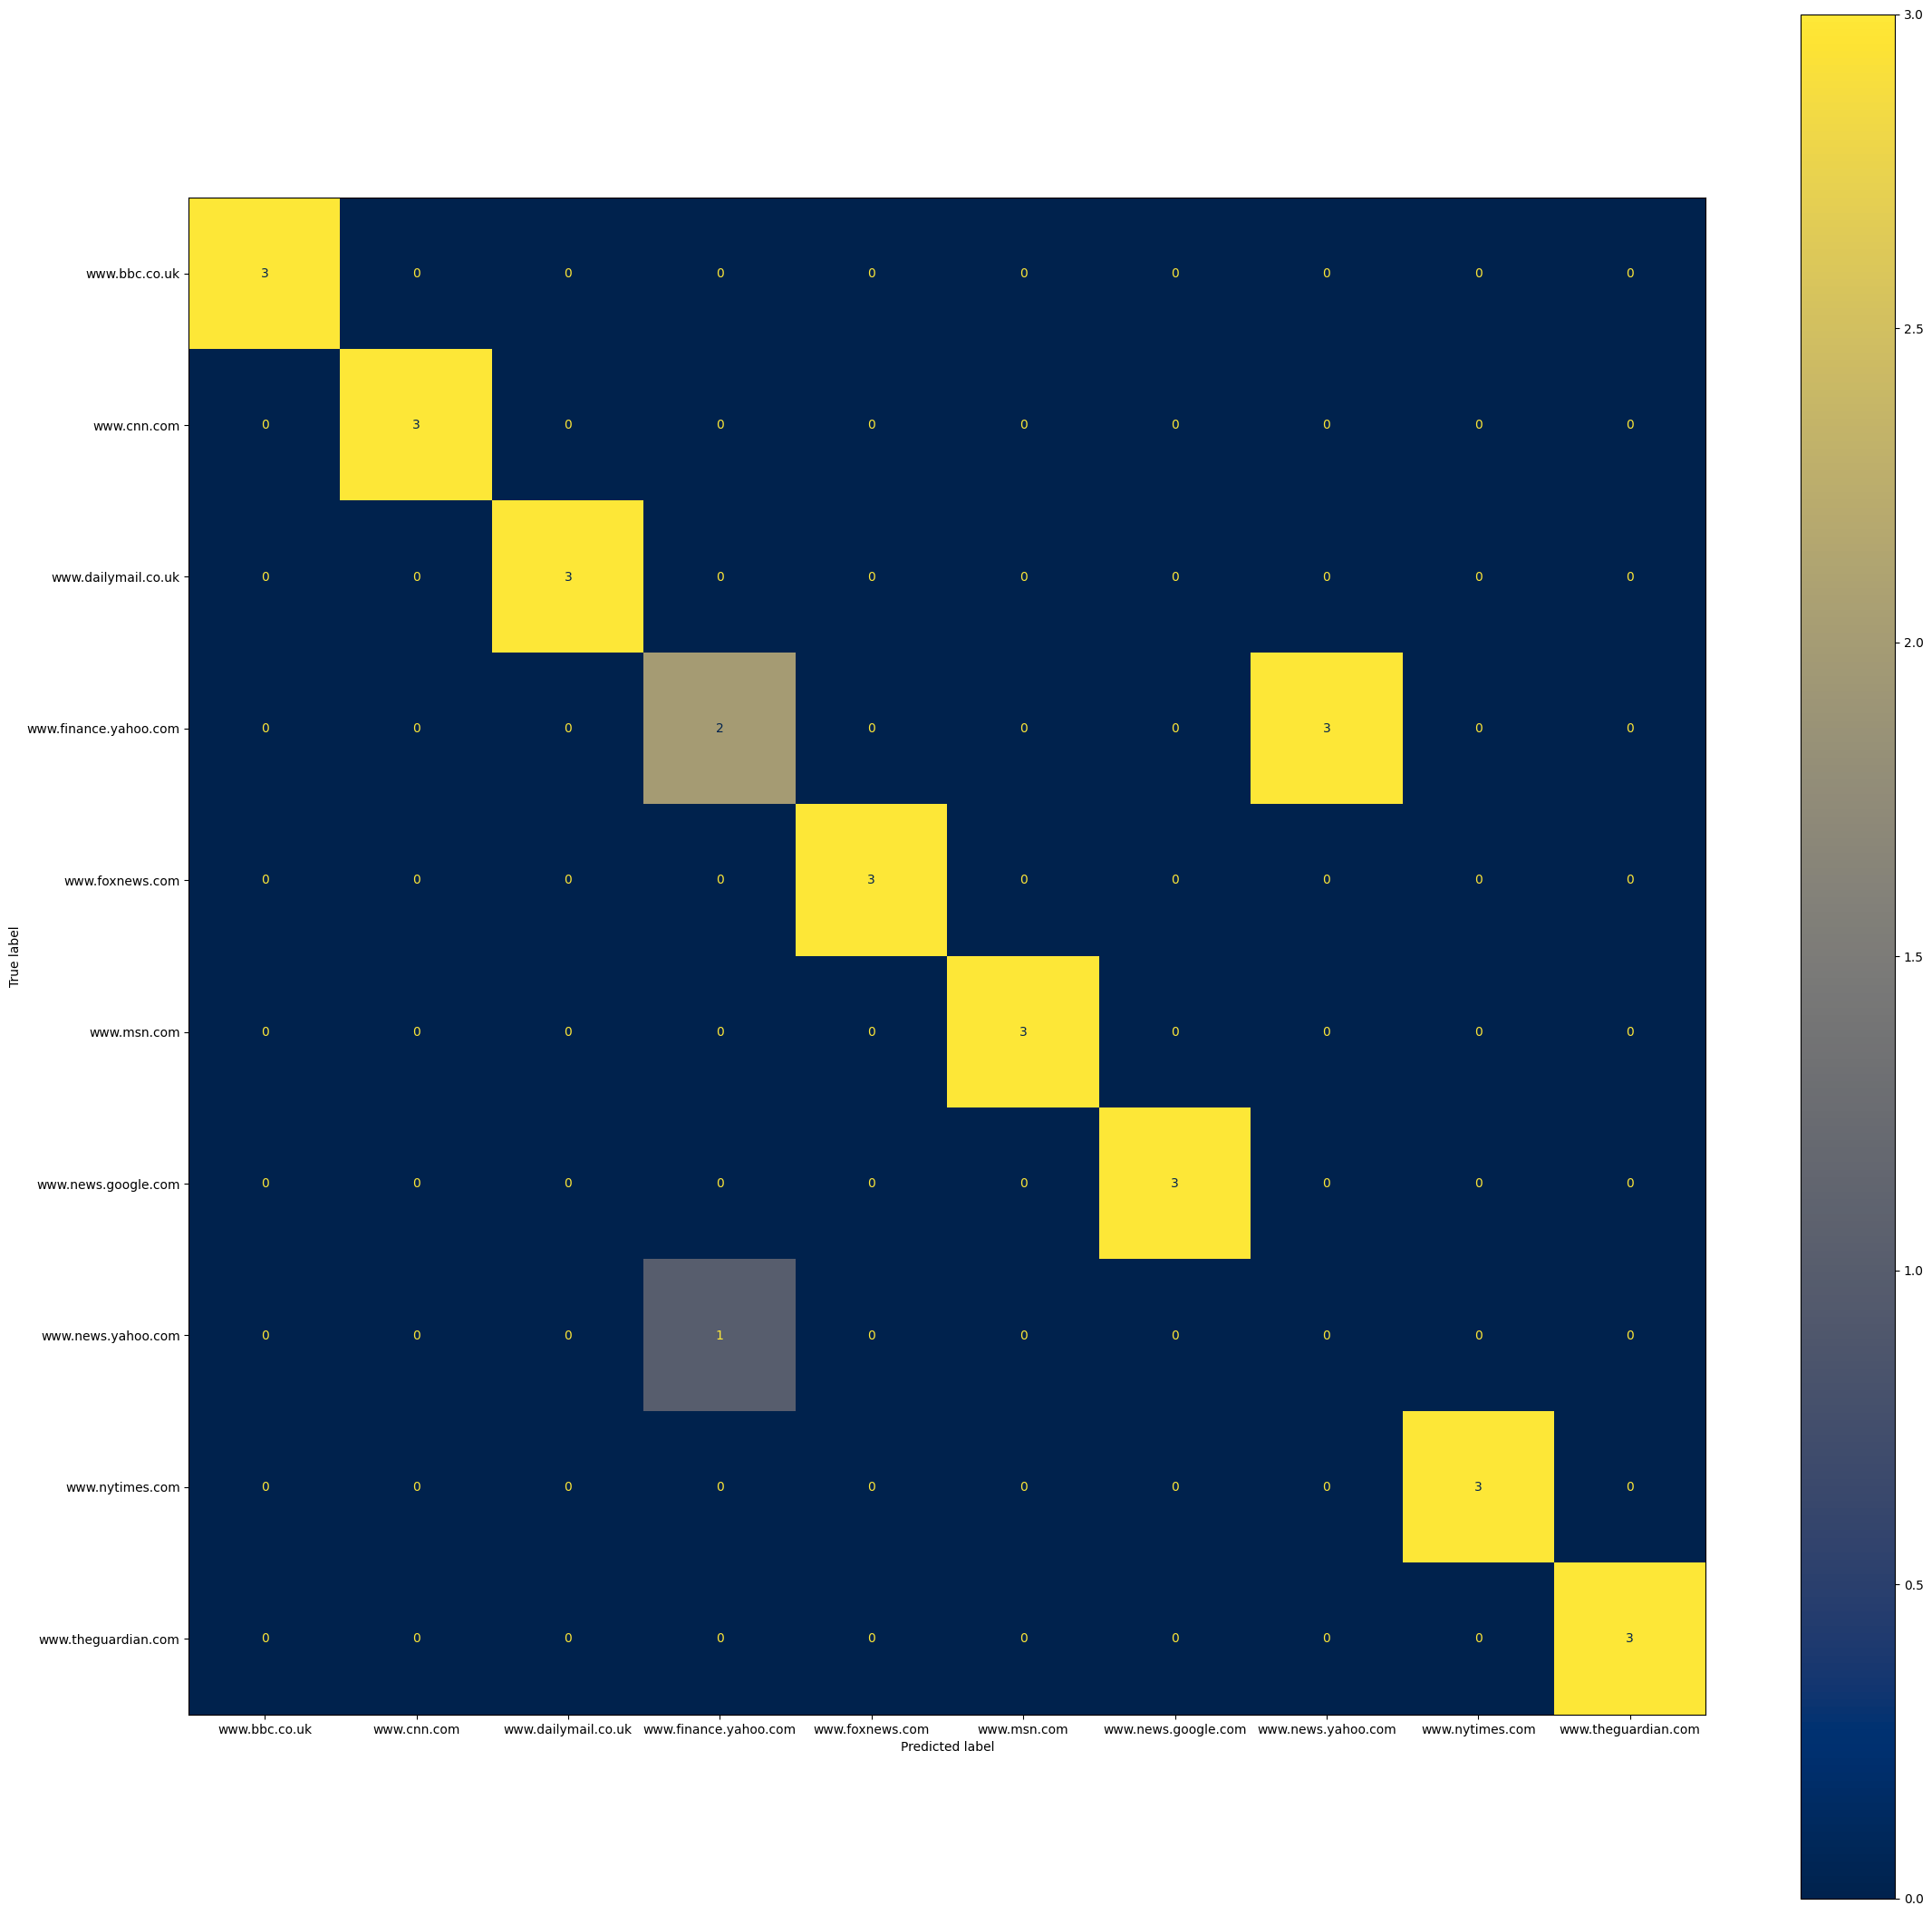

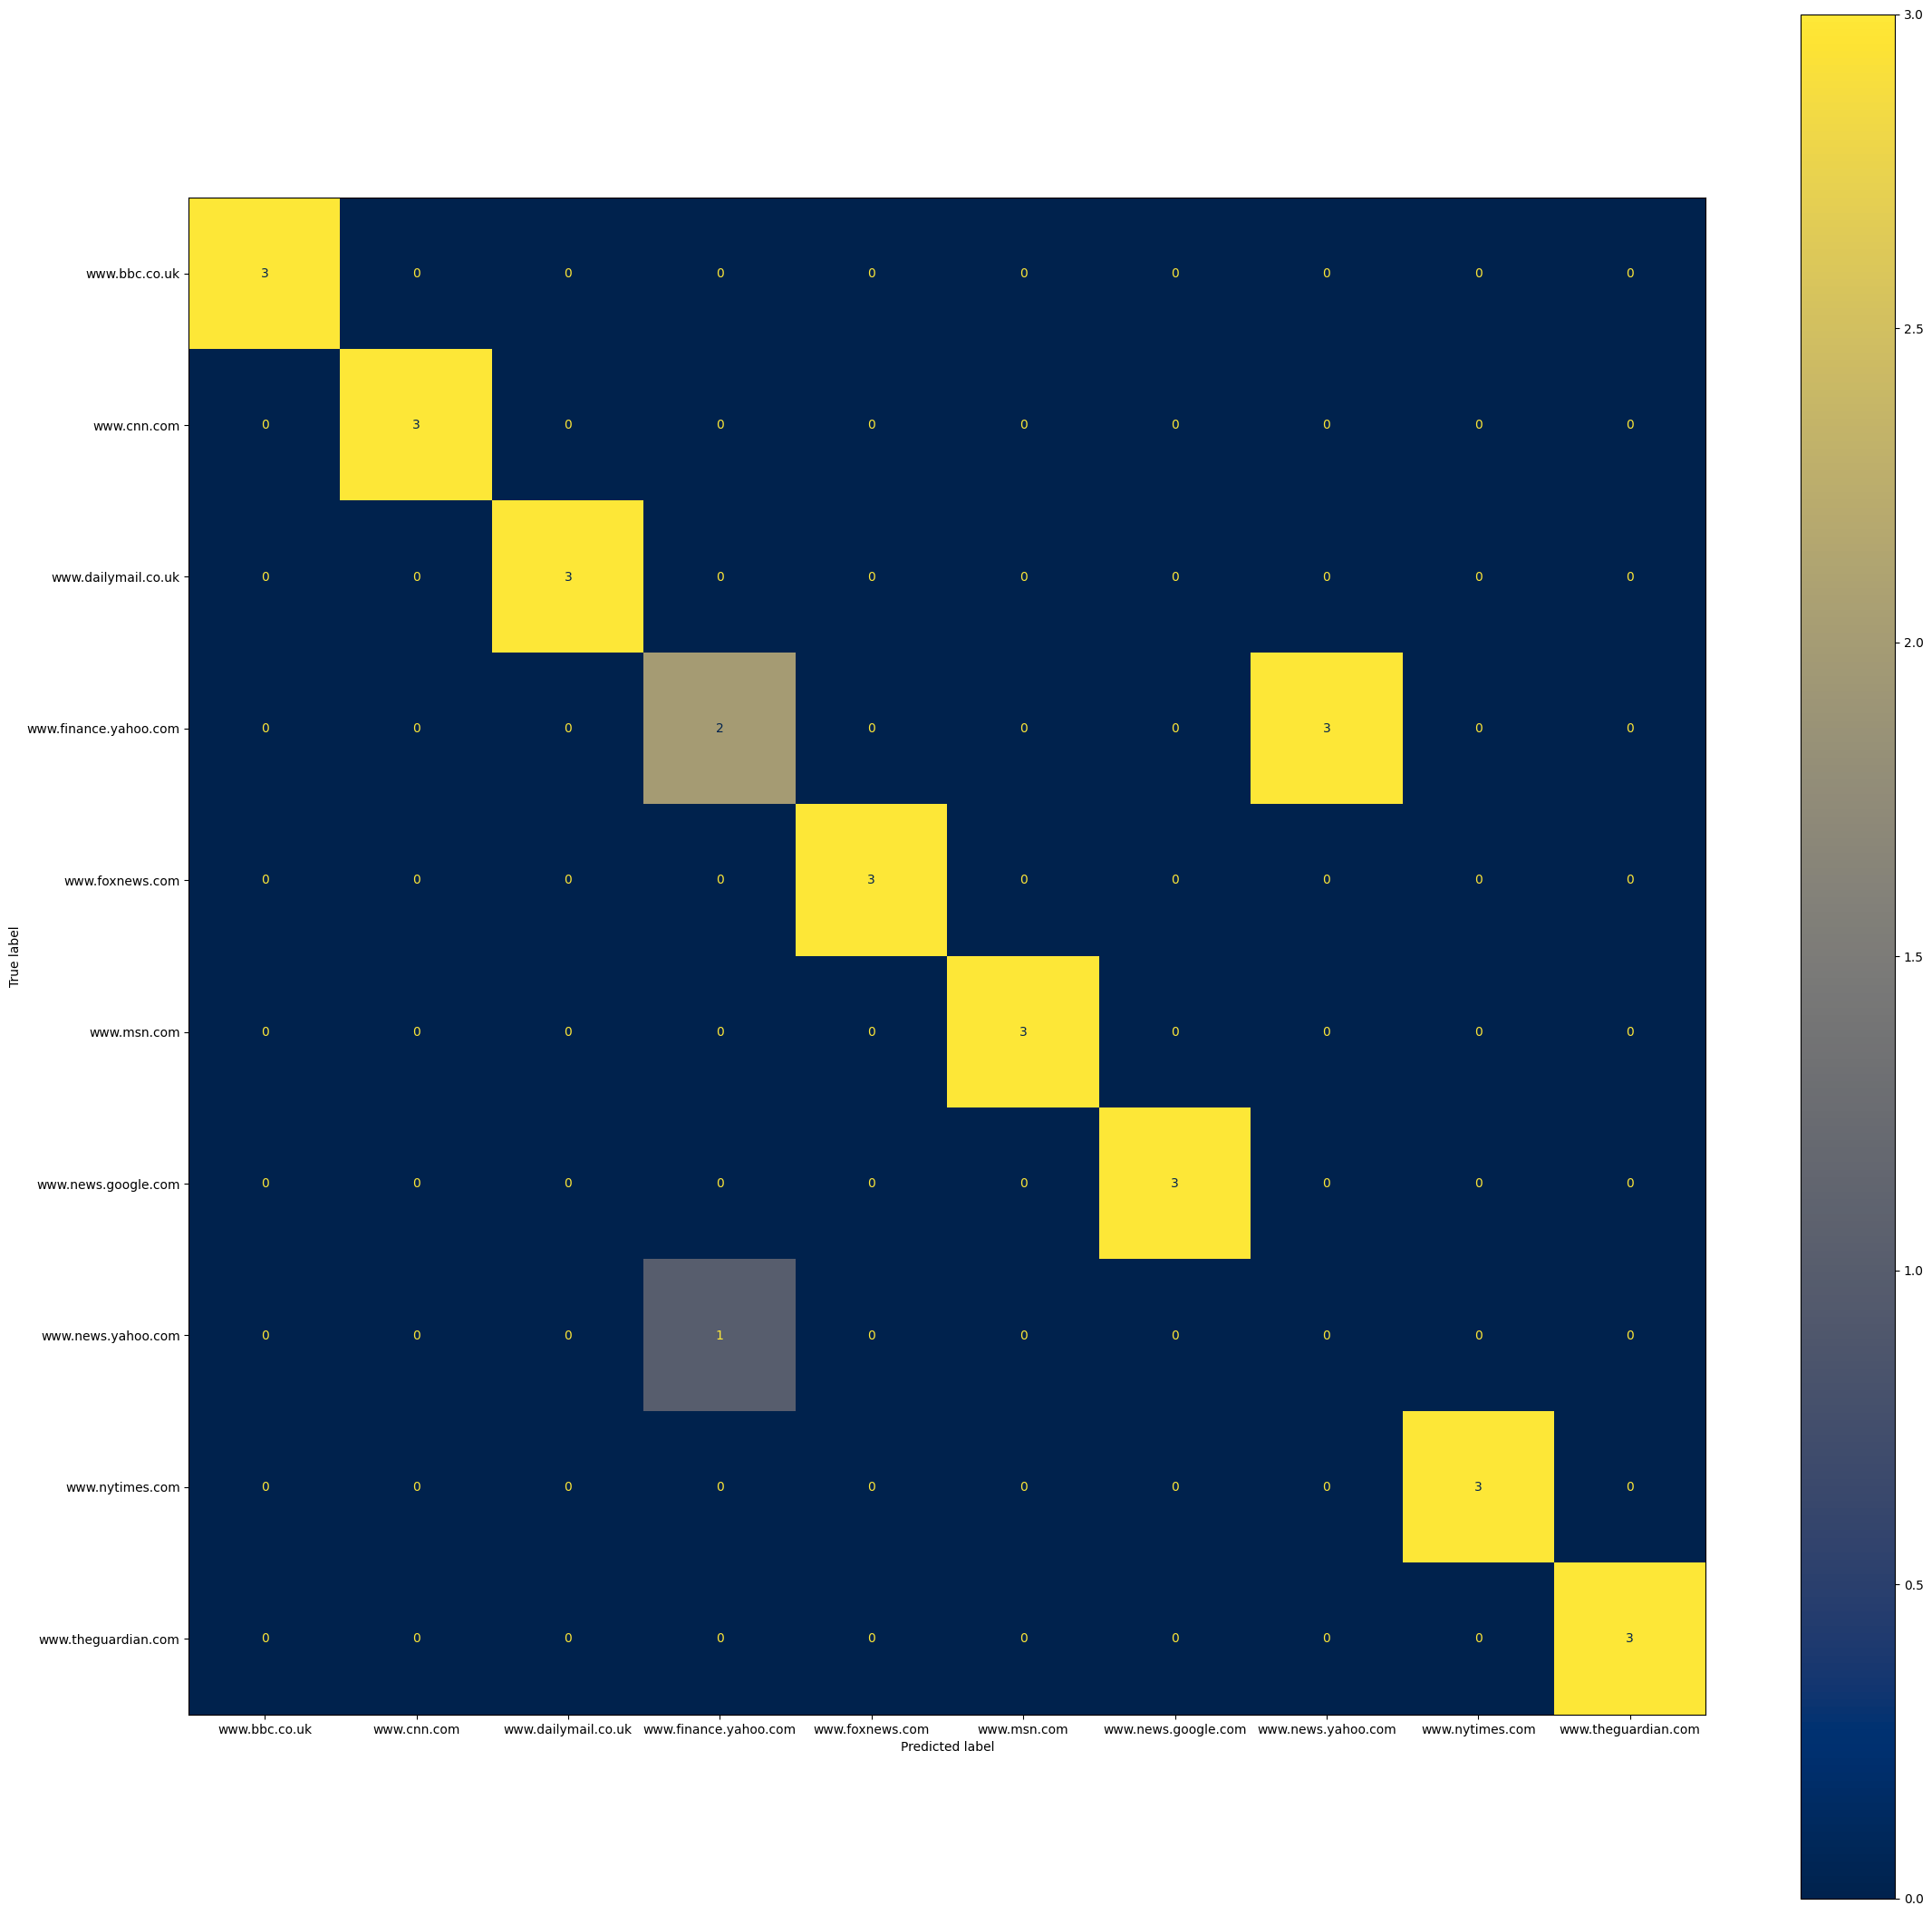

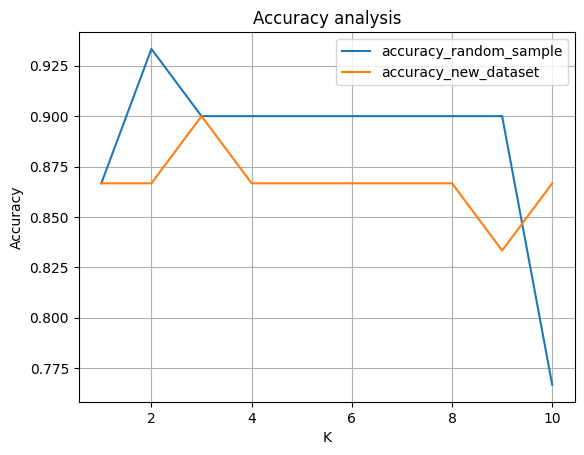

In [21]:
X_new = dataset_new.drop(['srcport','dport'],axis=1).dropna();

y_new = X_new['site']

X_new = X_new.drop(['site'],axis=1)

k_tot = 10;
accuracy_new = []
k = []

for i in range(1, k_tot+1):

  knn_new = KNeighborsClassifier(n_neighbors=i)
  knn_new.fit(X_norm_train, y_train)

  # Make predictions on test set
  y_pred_new = knn_new.predict(X_new)

  # Calculate accuracy
  accuracy_new.append(accuracy_score(y_new, y_pred_new))
  k.append(i)
print("Accuracy:", accuracy_new)

scores_new = []

#scaler = StandardScaler()
#X_cross = scaler.fit_transform(X)

for j in range(1, k_tot+1):

    #knn_new = KNeighborsClassifier(n_neighbors=j)
    #crossvalidation could be wrong
    #score_new = cross_val_score(knn_new, X_new, y_new, cv=3)
    #print(score)
    #scores_new.append(np.mean(score_new))

    # Show the confusion matrix
    fig, ax = plt.subplots(figsize=(27, 27));
    ConfusionMatrixDisplay.from_predictions(y_pred_new, y_new, ax=ax,cmap='cividis');
    plt.show()

#Accuracy analysis
plt.title('Accuracy analysis')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(visible= True)
plt.plot(k,accuracy)
plt.plot(k,accuracy_new)

plt.legend(["accuracy_random_sample","accuracy_new_dataset"])

The results obtained by using the new test set(obtained on 22/03/2024) with the old training set(obtained on 21/03/2024) show that in one day the accuracy is a little bit lower compared to previous case. Theoretically as time passes performance should decrease due to changes in the websites, this is shown in Juarez work (A. Panchenko et al."Website Fingerprinting at Internet Scale" NDSS 2016), in his research on WFP attacks, classification accuracy decreases by 40% in less than 10 days and further declines almost to zero after 90 days for Alexa Top 100 pages due to content changes.

#***BONUS POINT***

FILTER TCP ACKS

In [ ]:
!rm -r filtered_csv_files

In [22]:
# Specify the path to the folder containing the CSV files
folder_path = '/content/csv_files/'
# Specify the path to the new folder for filtered files
filtered_folder_path = '/content/filtered_csv_files/'

# Create the new folder if it doesn't already exist
os.makedirs(filtered_folder_path, exist_ok=True)

sampled_features = []
#array representing the cumulative trace
C = []
names=[]
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Load the CSV file into a DataFrame
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        # Filter out TCP ACK packets
        filtered_df = df[df['tcp.flags'] != "0x0010"].copy()
        #print(filtered_df['ip.src'])

        # Create a new column 'direction' with initial empty values
        filtered_df['direction'] = ""

        # Apply conditions to assign values to the 'direction' column
        filtered_df.loc[filtered_df['ip.src'] == "172.28.0.12", 'direction'] = "uplink"
        filtered_df.loc[filtered_df['ip.src'] != "172.28.0.12", 'direction'] = "downlink"

        # Modify the 'frame.len' column for downlink
        filtered_df.loc[filtered_df['direction'] == "uplink", 'frame.len'] *= -1

        filtered_df['cumulative_trace'] = filtered_df['frame.len'].cumsum()
        C = filtered_df['frame.len'].cumsum()

        # Save the filtered data to a new CSV file in the new folder
        filtered_csv_file = os.path.join(filtered_folder_path, f'filtered_{filename}')
        filtered_df.to_csv(filtered_csv_file, index=False)
        #C.extend(filtered_df['cumulative_trace'].values)  # Use values instead of tolist()

        # Number of equidistant points to sample the interpolator
        M = 20

        # Calculate equidistant points
        x = np.linspace(1,len(C) , M)

        # Perform piecewise linear interpolation of C in x
        interpolated_C = np.interp(x, range(1, len(C) + 1), C)
        sampled_features.append(interpolated_C)
        names.append(filename.split("_")[0])
print(sampled_features)



[array([-7.40000000e+01,  3.17736842e+03,  2.89231579e+03,  3.04273684e+03,
        1.48572632e+04,  2.77615789e+04,  4.09698947e+04,  5.66862105e+04,
        8.64477895e+04,  1.40786842e+05,  1.85383158e+05,  2.31499474e+05,
        3.03227789e+05,  3.76020105e+05,  4.46608421e+05,  5.03440737e+05,
        5.69317053e+05,  6.37701368e+05,  6.68557316e+05,  6.68580000e+05]), array([-7.40000000e+01,  2.60447368e+03,  2.26415789e+03,  2.81473684e+03,
        3.72689474e+03,  1.46846316e+04,  2.57531579e+04,  3.84983158e+04,
        5.49777895e+04,  7.52677895e+04,  1.04017158e+05,  1.31089895e+05,
        1.71194632e+05,  2.44069895e+05,  3.21441579e+05,  3.77816684e+05,
        4.95808579e+05,  5.93788053e+05,  5.93635684e+05,  5.93660000e+05]), array([ -74.,    0., -583., 2371., 3872., 3742., 3630., 3515., 3414.,
       3283., 3408., 3311., 4288., 4198., 4132., 4222., 4168., 4234.,
       4180., 4126.]), array([  -74.,     0.,  -583.,  3579.,  4353.,  4223.,  4111.,  3996.,
        389

In [23]:
# Concatenate all the sampled features into a single matrix
X = np.vstack(sampled_features)

# Create a dataframe having interpolated_C as raws
interpolated_df = pd.DataFrame(X, columns=[f'Sample_{i+1}' for i in range(X.shape[1])])
interpolated_df["site"] =names
display(interpolated_df)

# Save the dataframe into a new csv_file
interpolated_csv_file = '/content/interpolated_dataframe.csv'
interpolated_df.to_csv(interpolated_csv_file, index=False)

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,...,Sample_12,Sample_13,Sample_14,Sample_15,Sample_16,Sample_17,Sample_18,Sample_19,Sample_20,site
0,-74.0,3177.368421,2892.315789,3042.736842,14857.263158,27761.578947,40969.894737,56686.210526,86447.789474,140786.842105,...,231499.473684,303227.789474,376020.105263,446608.421053,503440.736842,569317.052632,637701.368421,668557.315789,668580.0,www.nytimes.com
1,-74.0,2604.473684,2264.157895,2814.736842,3726.894737,14684.631579,25753.157895,38498.315789,54977.789474,75267.789474,...,131089.894737,171194.631579,244069.894737,321441.578947,377816.684211,495808.578947,593788.052632,593635.684211,593660.0,www.foxnews.com
2,-74.0,0.000000,-583.000000,2371.000000,3872.000000,3742.000000,3630.000000,3515.000000,3414.000000,3283.000000,...,3311.000000,4288.000000,4198.000000,4132.000000,4222.000000,4168.000000,4234.000000,4180.000000,4126.0,www.theguardian.com
3,-74.0,0.000000,-583.000000,3579.000000,4353.000000,4223.000000,4111.000000,3996.000000,3895.000000,3762.000000,...,4889.000000,5242.000000,6630.000000,9340.000000,10390.000000,10293.000000,10203.000000,10137.000000,10203.0,www.finance.yahoo.com
4,-74.0,0.000000,-583.000000,683.000000,1458.000000,1328.000000,1216.000000,1101.000000,1000.000000,869.000000,...,1997.000000,2350.000000,3738.000000,6448.000000,7498.000000,7401.000000,7311.000000,7245.000000,7311.0,www.news.yahoo.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-74.0,-3.894737,-521.631579,2921.842105,4191.631579,4259.210526,4148.368421,4040.368421,3939.526316,3827.000000,...,4688.631579,5023.052632,5684.315789,7606.105263,10307.578947,10216.789474,10134.052632,10078.473684,10141.0,www.finance.yahoo.com
96,-74.0,-357.000000,3438.052632,3638.105263,3417.789474,3196.789474,4326.263158,8326.315789,12008.263158,14340.894737,...,21197.736842,25459.789474,29740.157895,32074.368421,40791.526316,45743.421053,50387.947368,50679.473684,50675.0,www.msn.com
97,-74.0,0.000000,-583.000000,3579.000000,4353.000000,4223.000000,4111.000000,3996.000000,3895.000000,3762.000000,...,4468.000000,4586.000000,4489.000000,5877.000000,8587.000000,9607.000000,9517.000000,9451.000000,9517.0,www.finance.yahoo.com
98,-74.0,-3.894737,-521.631579,2911.736842,4169.368421,4234.210526,4123.368421,4015.368421,3914.526316,3803.052632,...,4647.578947,4970.631579,6455.473684,9479.157895,10223.578947,10132.789474,10050.052632,9993.842105,10045.0,www.news.yahoo.com


Accuracy: [0.8333333333333334, 0.8, 0.7666666666666667, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7333333333333333]
[0.88 0.88 0.8  0.8 ]
[0.76 0.8  0.84 0.8 ]
[0.84 0.84 0.76 0.72]
[0.8  0.8  0.84 0.76]
[0.8  0.8  0.84 0.76]
[0.76 0.8  0.84 0.76]
[0.76 0.8  0.84 0.72]
[0.72 0.8  0.8  0.68]
[0.72 0.8  0.8  0.68]
[0.72 0.8  0.8  0.72]


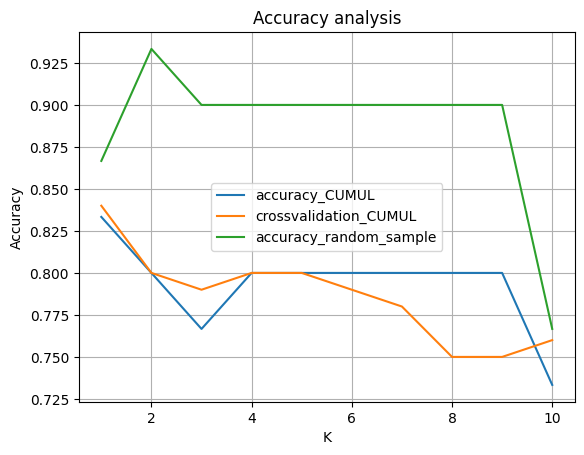

In [28]:
data = interpolated_df;

labels = data['site']

data = data.drop(['site'],axis=1)

# Divide the dataset in training set and test set
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3)

k_tot = 10;
accuracy_cum = []
k = []

for i in range(1, k_tot+1):

  knn_cum = KNeighborsClassifier(n_neighbors=i)
  knn_cum.fit(data_train, labels_train)

  # Do predictions on the test set
  labels_pred = knn_cum.predict(data_test)

  # Calculate accuracy
  accuracy_cum.append(accuracy_score(labels_test, labels_pred))
  k.append(i)
print("Accuracy:", accuracy_cum)

scores_cum = []

for j in range(1, k_tot+1):

    knn_cum = KNeighborsClassifier(n_neighbors=j)
    score = cross_val_score(knn_cum, data, labels, cv=4)
    print(score)
    scores_cum.append(np.mean(score))

    # Show the confusion matrix
    #fig, ax = plt.subplots(figsize=(27, 27));
    #ConfusionMatrixDisplay.from_predictions(labels_pred, labels_test, ax=ax,cmap='cividis');
    #plt.show()

plt.title('Accuracy analysis')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(visible= True)
plt.plot(k,accuracy_cum)
plt.plot(k,scores_cum)
plt.plot(k,accuracy)
plt.legend(["accuracy_CUMUL", "crossvalidation_CUMUL","accuracy_random_sample"])

The results obtaied in this section are similar to the ones obtained with the previous approach, there is just a slight decrease in performance, maybe it is related to the fact that the number of features that are used is work is not so high